# Act 3: Generate from Data

In this notebook, you'll generate new data from existing data. We'll be using AI models to get creative:

✂️ Extract frames from video scenes  
🧪 Compose scene descriptions using Gemini with frames and transcripts  
🧞‍♀️ Generate images with Imagen using Gemini scene descriptions  
🍿 (Optional) Generate videos from images and prompts using Veo

In a typical workflow, this means: loading video files, extracting frames with OpenCV or ffmpeg, encoding images to base64, constructing API requests, managing authentication, parsing JSON responses, handling rate limits and errors, writing batch processing loops, saving outputs to disk, and tracking which items have been processed.

In Pixeltable, we can express this workflow without any explicit data handling. It is still the same work, same conceptual flow, but you don't have to craft the data operations. Instead, you can focus on the logic and Pixeltable handles the rest. 

## In this notebook

The techniques you'll learn apply to any workflow that chains transformations and applies them across data. We'll use Pixeltable to:

1. **Extract Frames** - Pull a frame from each video scene
2. **Generate Creative Prompts** - Use multimodal AI to create trailer descriptions from frames and transcripts
3. **Create Visual Content** - Generate images and videos from AI prompts
4. **Apply Across All Scenes** - Run the workflow on your entire scene library automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models and Pixeltable UDFs used in this notebook:**

| Google Model | Pixeltable UDF | Purpose |
|--------------|----------------|----------|
| `gemini-2.0-flash` | `pxtf.gemini.generate_content()` | Generate text descriptions from images |
| `imagen-4.0-fast-generate-001` | `pxtf.gemini.generate_images()` | Generate images from text prompts |
| `veo-3.1-generate-preview` | `pxtf.gemini.generate_videos()` | Generate videos from images and text |

In [62]:
import pixeltable as pxt
import pixeltable.functions as pxtf

As we've been doing, we'll take a look at the tables we can "get":

In [63]:
pxt.list_tables('primetime-workshop')

['primetime-workshop/video-frame-view',
 'primetime-workshop/primetime_vids',
 'primetime-workshop/scene_view',
 'primetime-workshop/sentences']

We'll be working with our `scene_view` table. 

In [64]:
scene_view = pxt.get_table('primetime-workshop/scene_view')

You can uncomment the code below if you have already gone through this notebook and want to start fresh with the state of `scene_view` before adding any generative AI model inputs or outputs.

In [ ]:
#scene_view.drop_column(scene_view.scene_image)
#scene_view.drop_column(scene_view.scene_prompt)
#scene_view.drop_column(scene_view.prompt_response)
#scene_view.drop_column(scene_view.beginning_frame)
#scene_view.drop_column(scene_view.prompt_text)

We can also check out the history of our table, to revisit where we've been!

In [65]:
# Your may look different than mine
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,4,2026-01-29 01:23:45.307915+00:00,None,data,101,0,0,0,NaN
1,3,2026-01-29 01:14:18.447759+00:00,None,schema,0,10,0,0,Added: transcript_text
2,2,2026-01-29 01:13:17.995543+00:00,None,schema,0,10,0,0,Added: transcription
3,1,2026-01-29 01:12:59.768463+00:00,None,schema,0,10,0,0,Added: audio
4,0,2026-01-29 01:12:46.255198+00:00,None,schema,10,0,0,0,Initial Version


In addition to viewing table history, you can do time travel, rollback to a previous version, and revert changes. See this page in our docs for more: https://docs.pixeltable.com/platform/version-control

As a reminder, here is our view schema:

In [66]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

You already have `scene_view` from Act 2 with video segments for each scene. Now you'll add a computed column to extract a frame from each segment.

As a reminder, `scene_view` is a view built on top of `primetime_vids`, which means it automatically has access to all the parent table's columns (like `title` and `promo_text`).

Computed columns work on views the same way they work on tables - they're automatically applied to every row:

- `extract_frame()` is a Pixeltable UDF that pulls a single frame at a specific timestamp from each video segment - we used this UDF already in Act 1
- Output frames are stored persistently
- If you add a new row to `primetime_vids`, only those new scenes are processed (incremental updates)

In [67]:
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=5),
    if_exists='replace'
)

Added 18 column values with 0 errors in 1.48 s (12.15 rows/s)


18 rows updated.

Let's look at the frames we just extracted:

pos,video_segment,beginning_frame
5,,
6,,
7,,

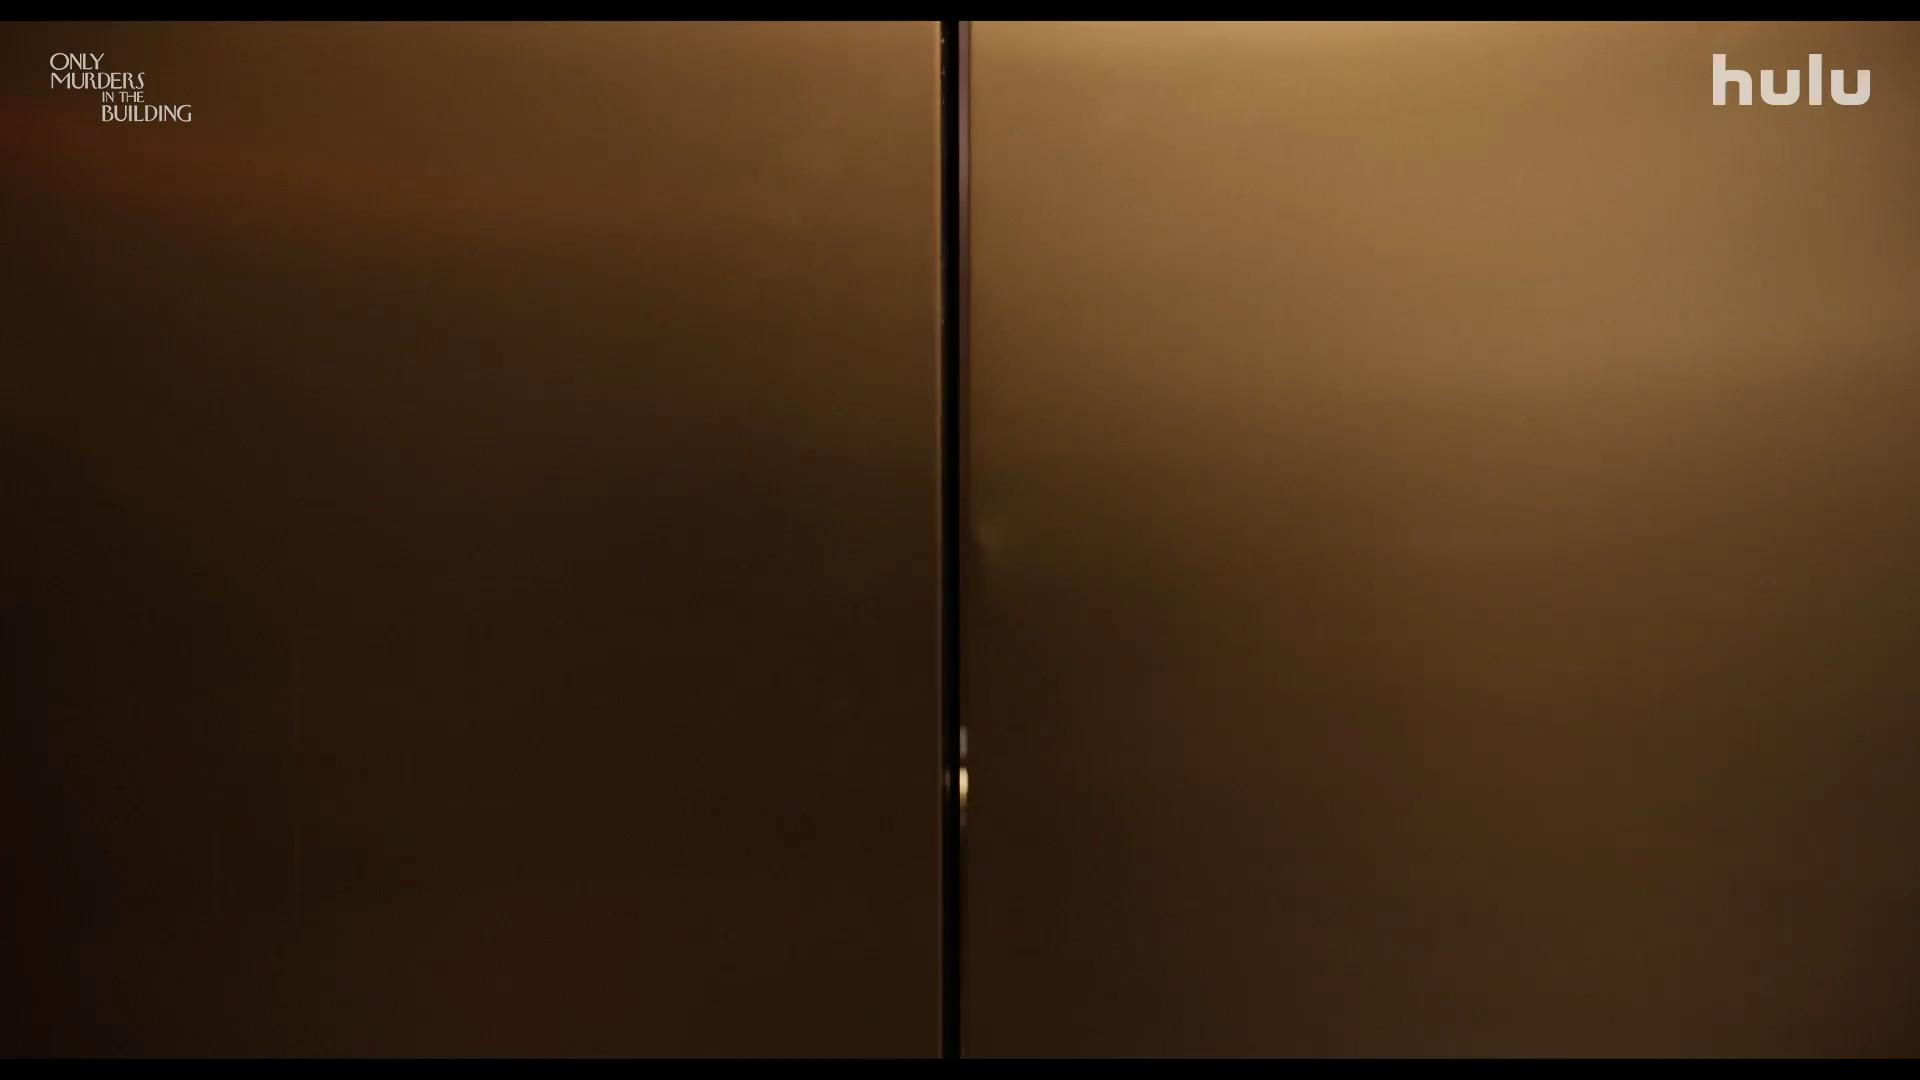
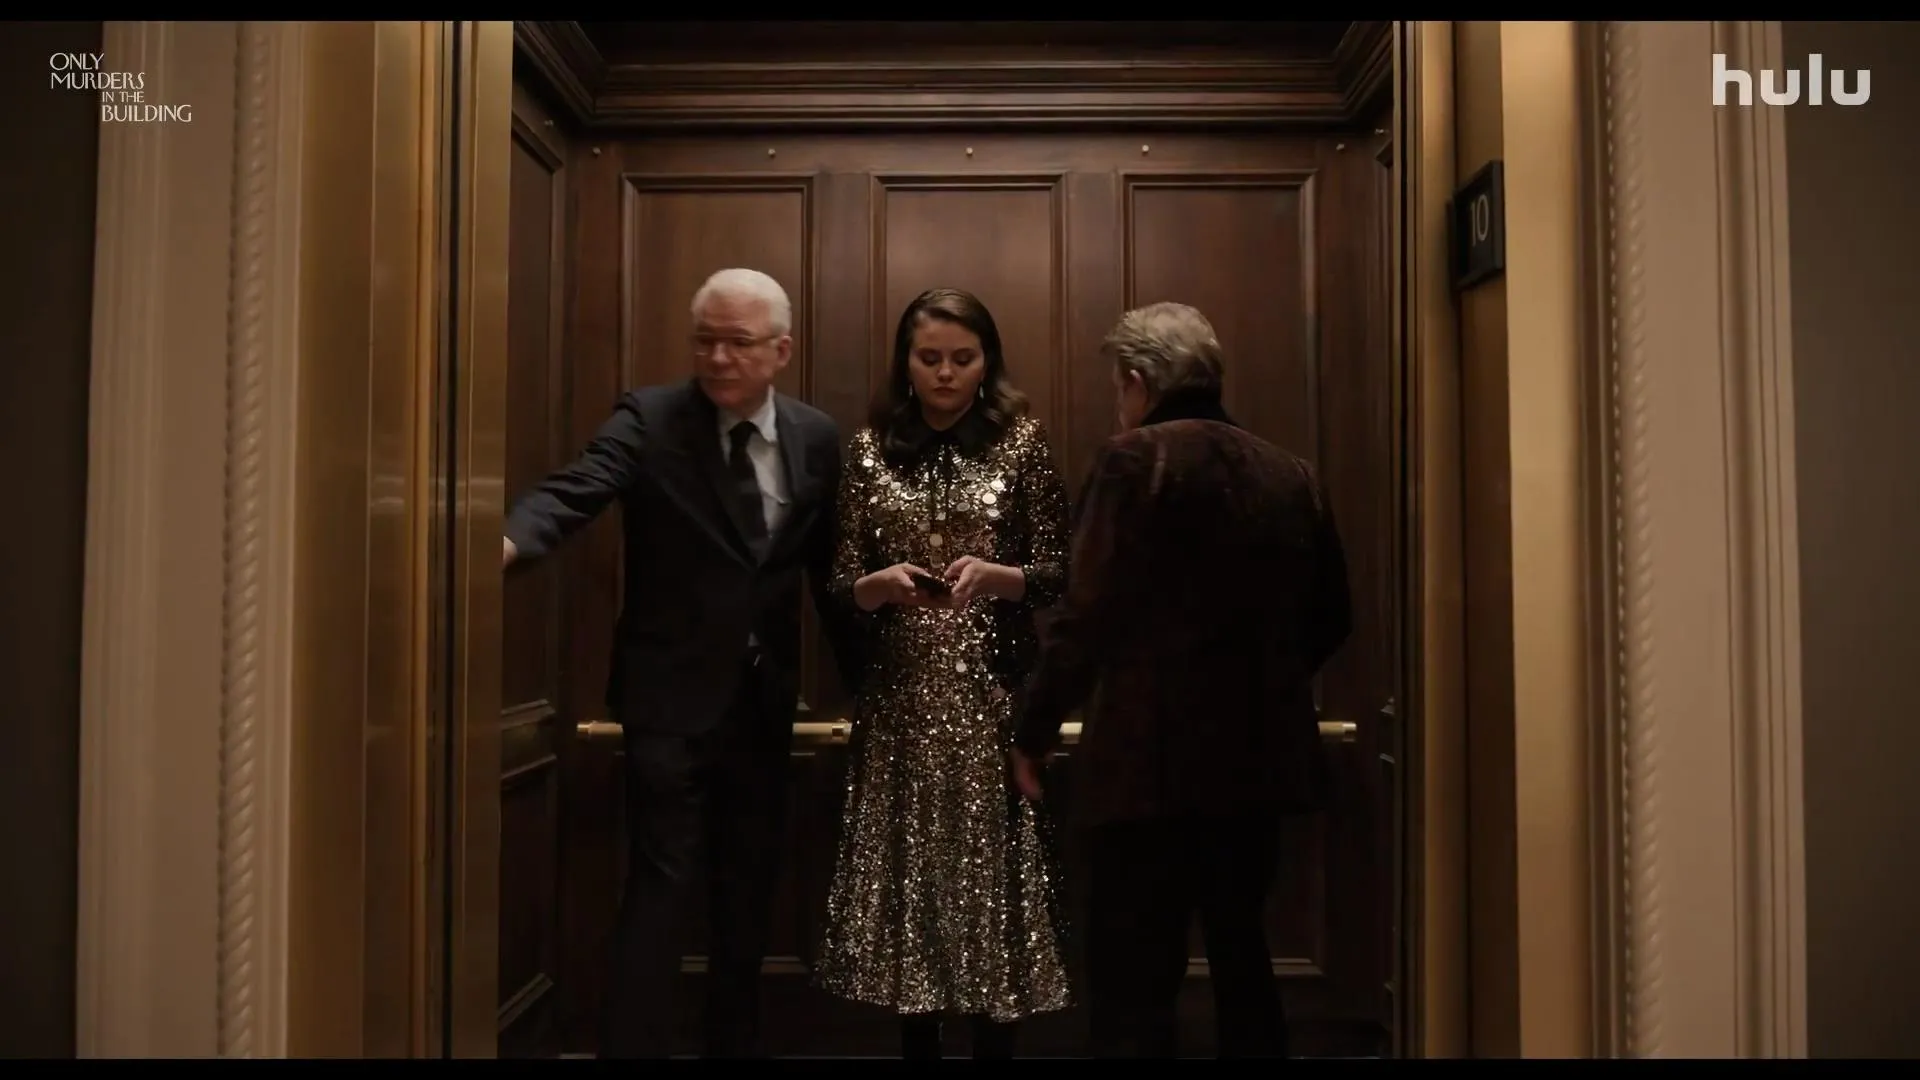
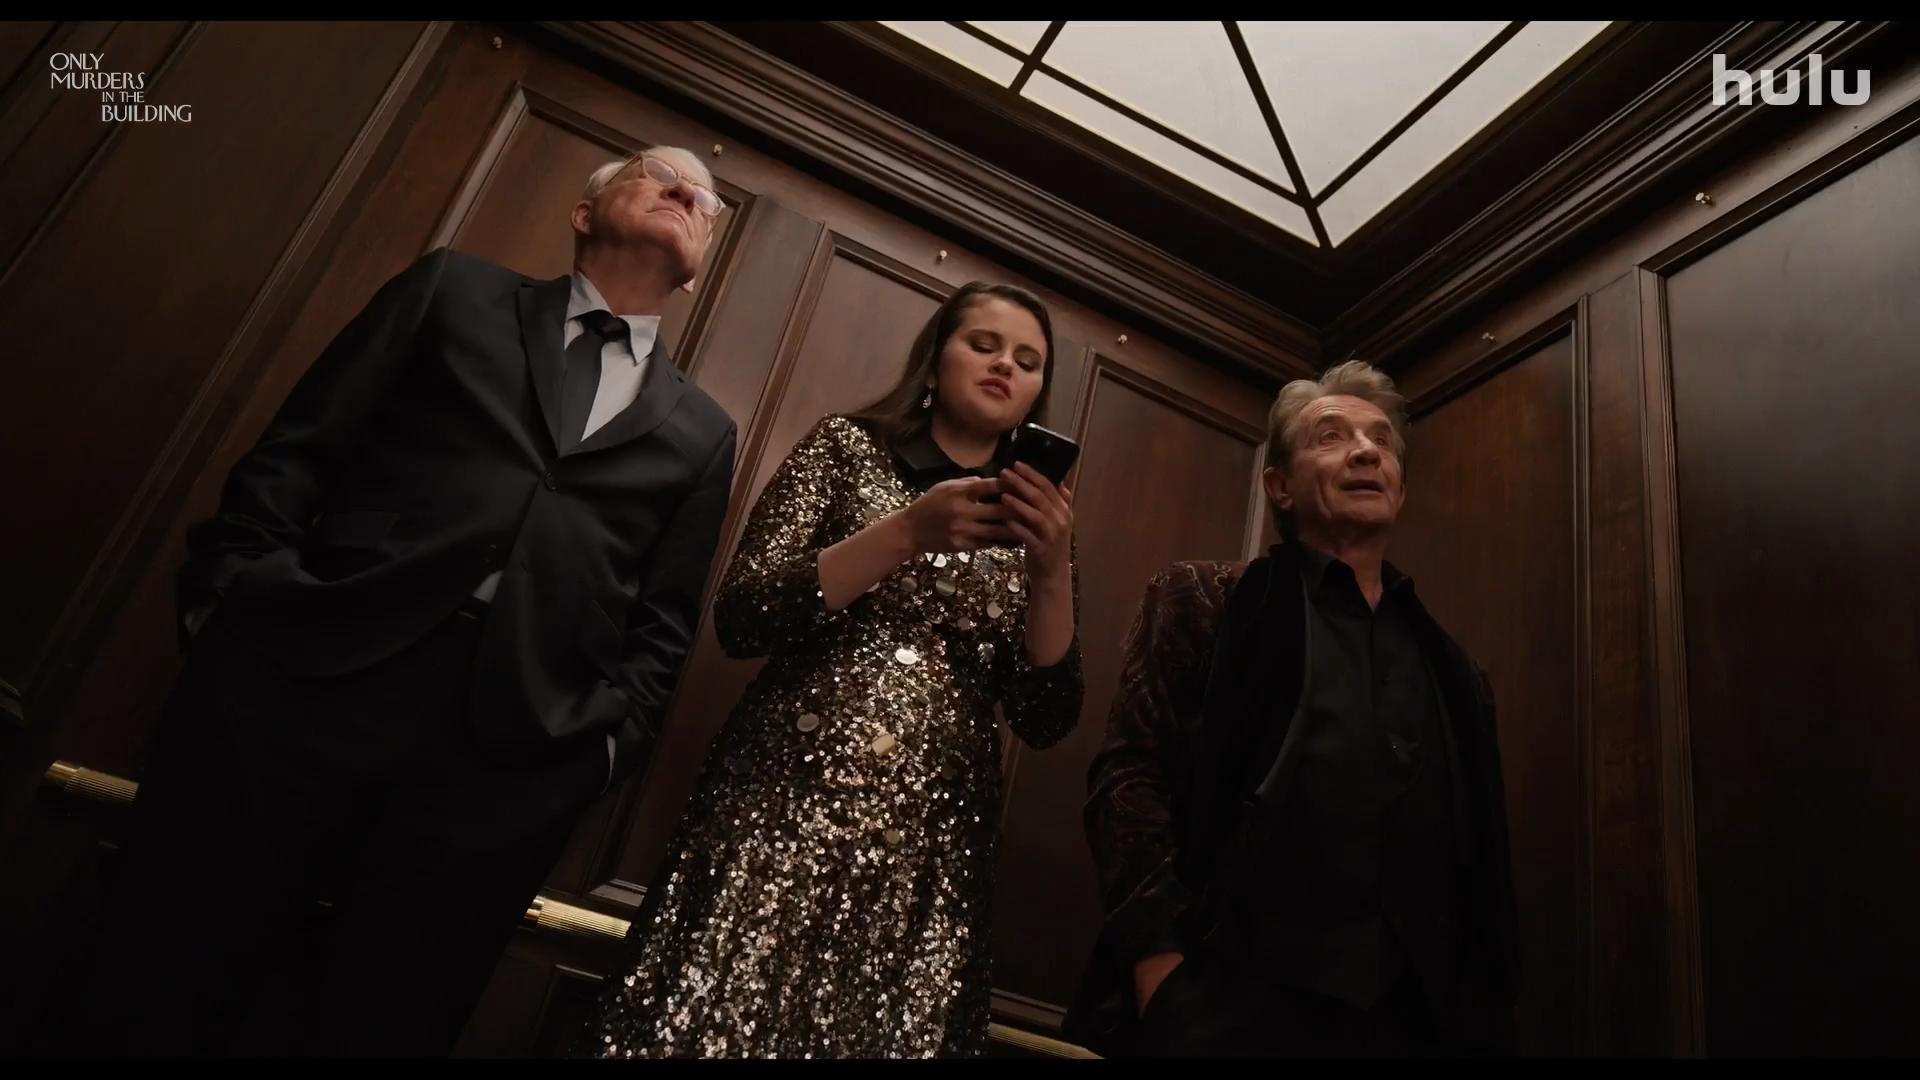
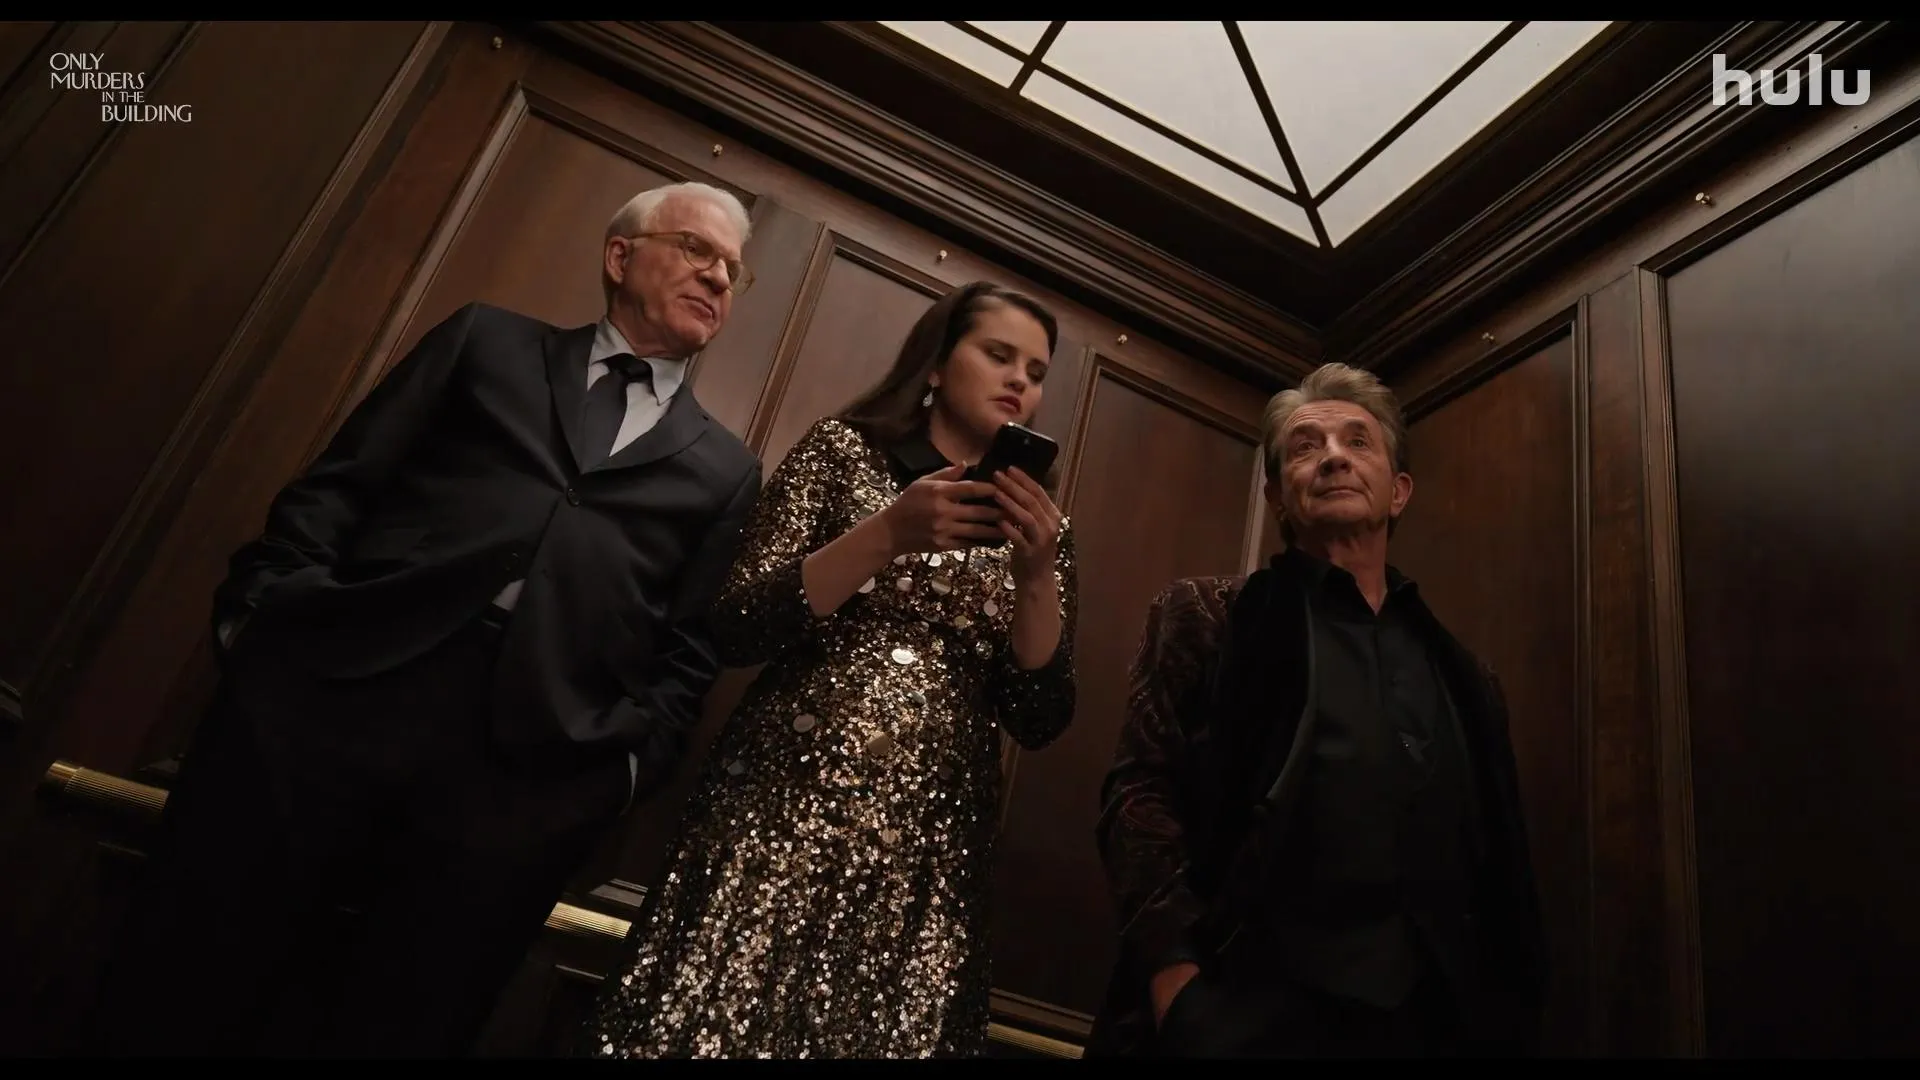
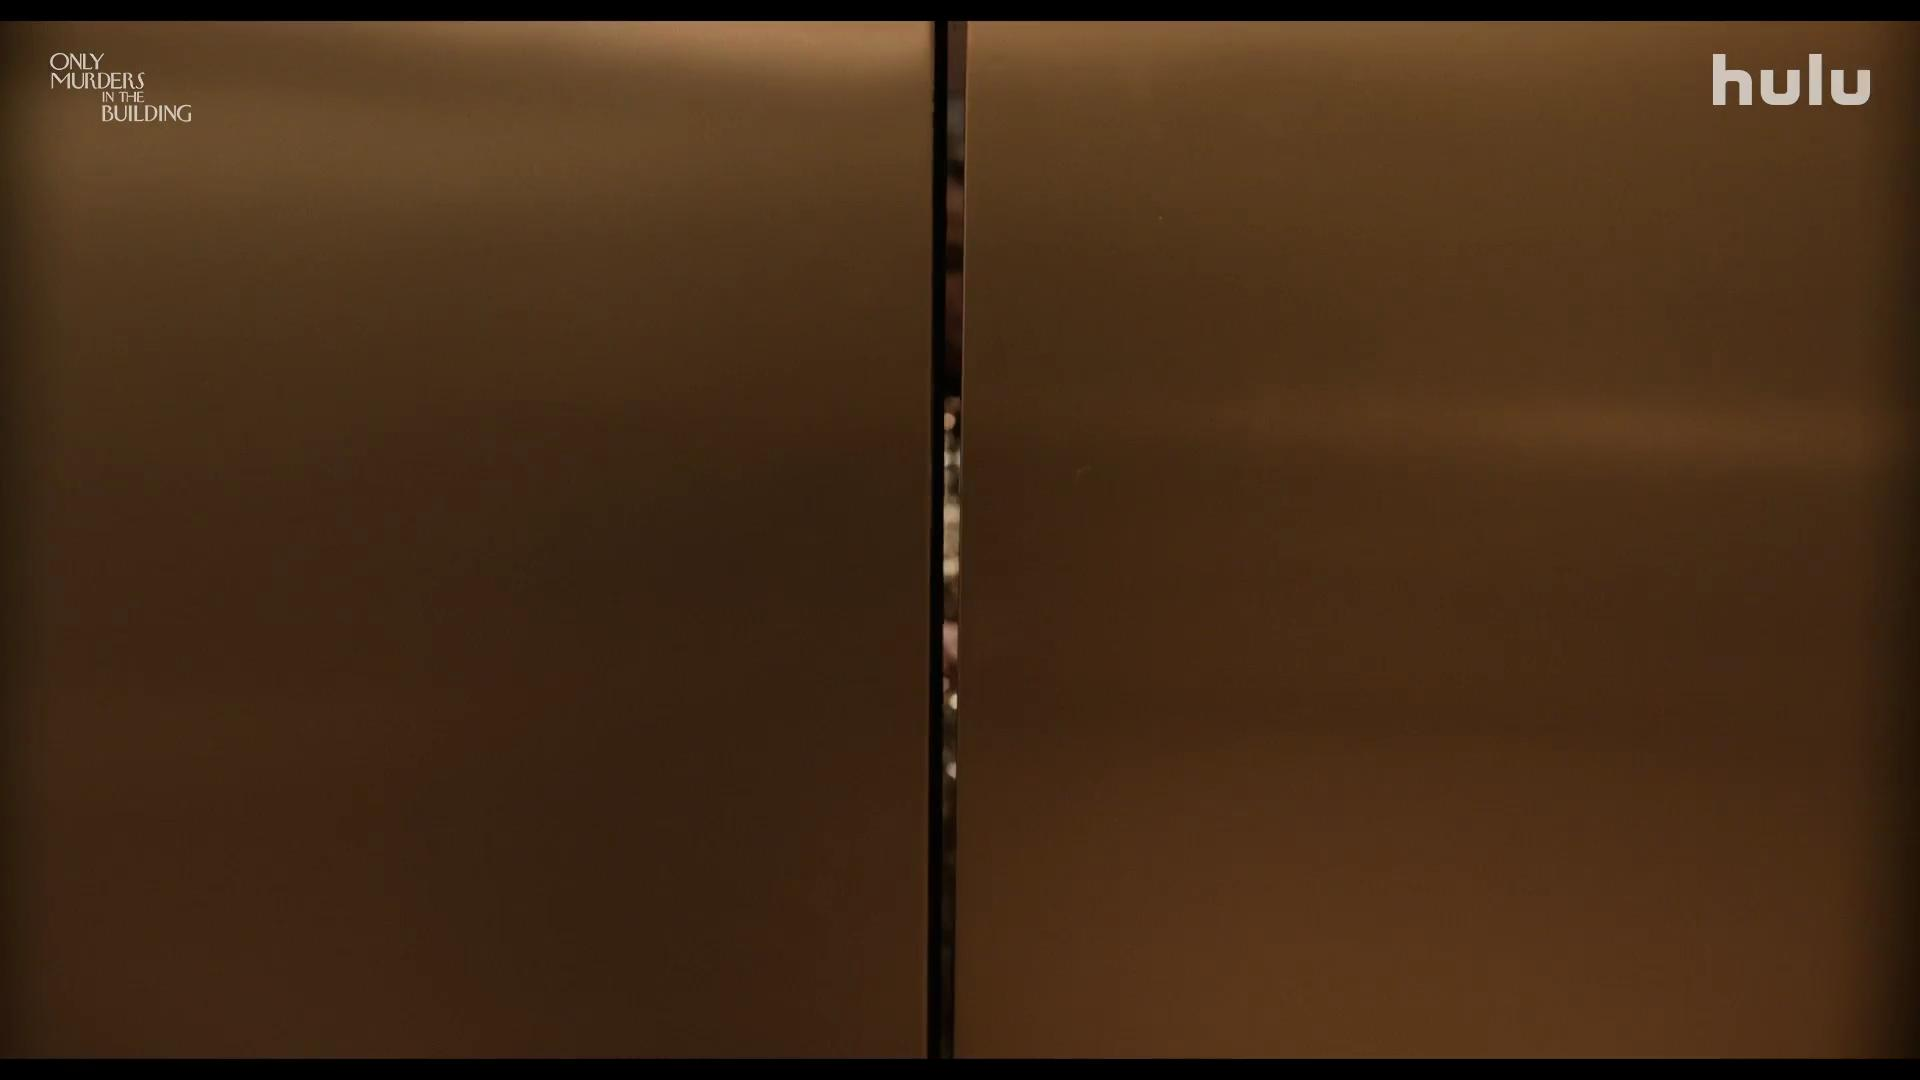
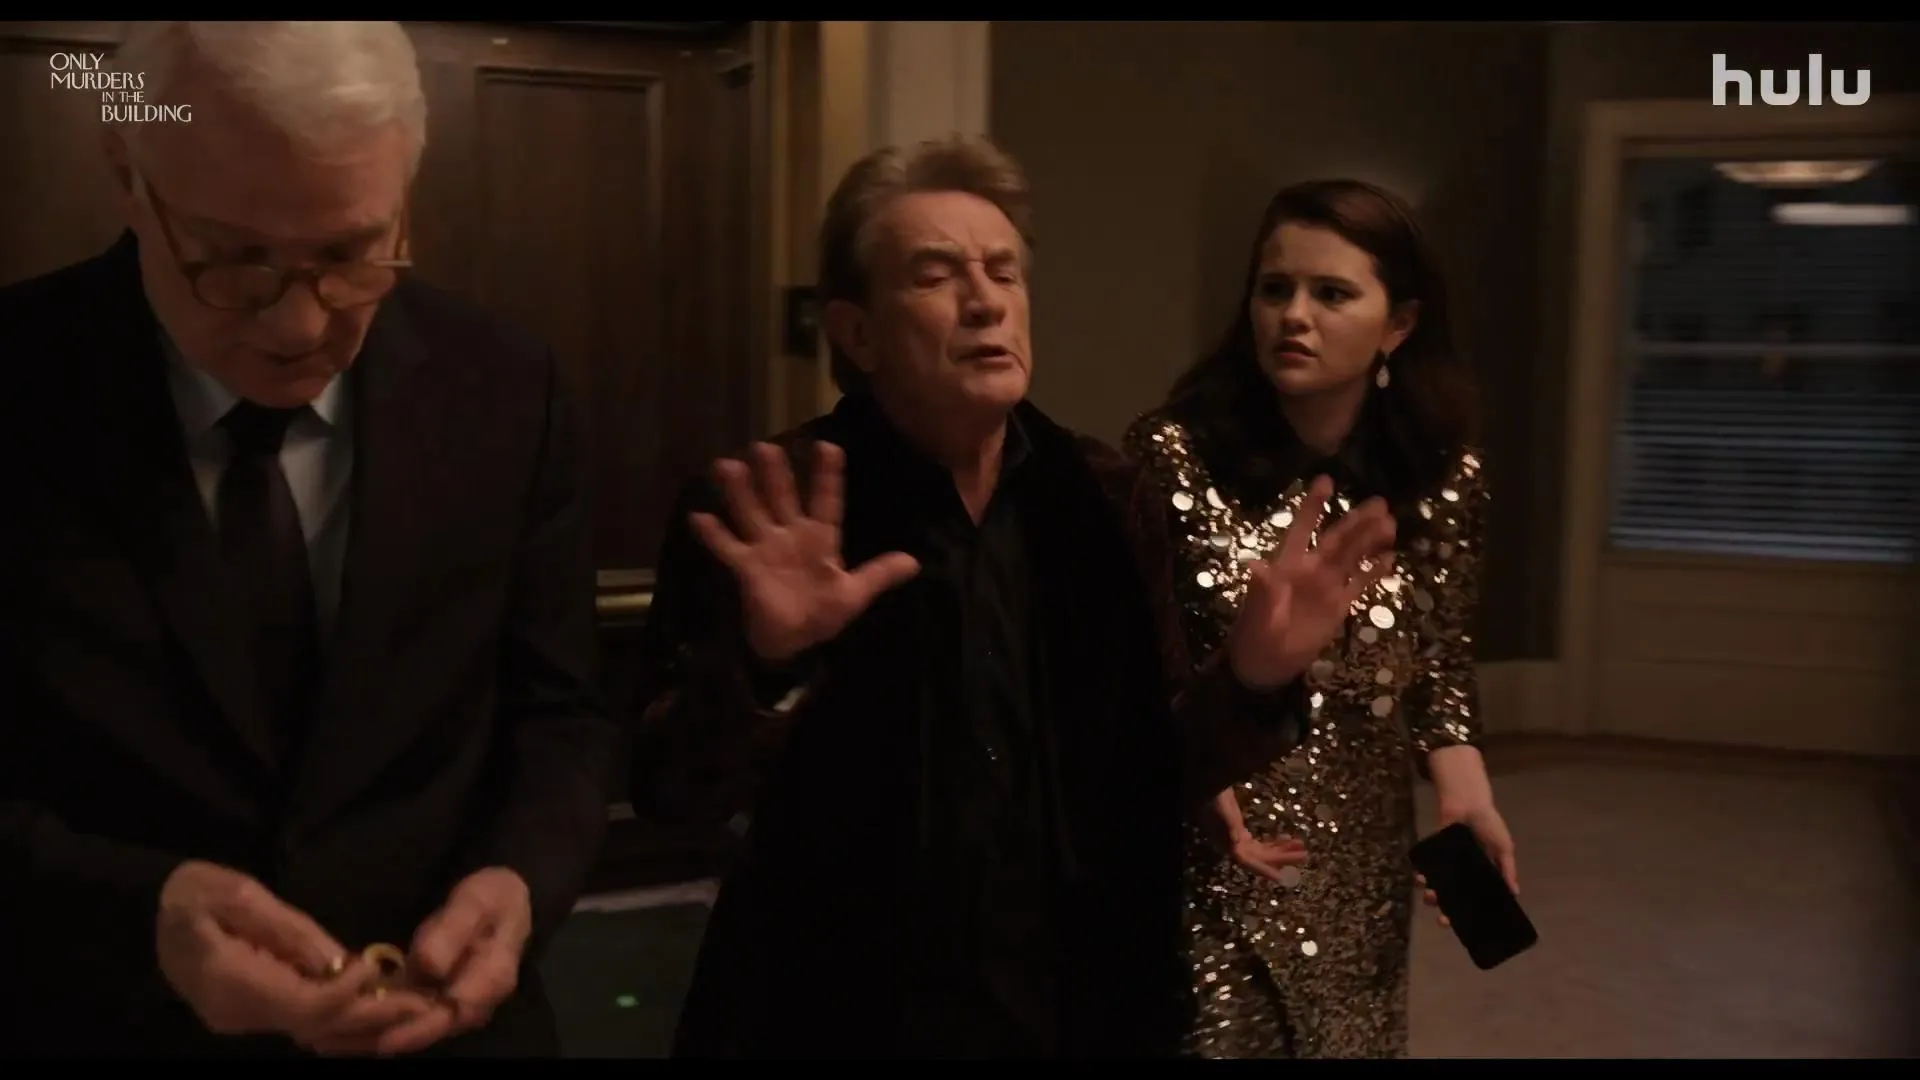

In [68]:
scene_view.select(scene_view.pos, scene_view.video_segment, scene_view.beginning_frame).tail(3)

## 02 - Build Scene Prompts

Now let's build scene descriptions that we can use in later sections to generate images and videos with AI models. We'll once again use a built-in UDF (User-Defined Function) to do this. Pixeltable provides a `format()` function in `pixeltable.functions.string` that works like Python's `str.format()`, but operates on table columns. 


We'll use this UDF to compose a custom scene text prompt with a template, and using data from columns in our view. Here's the workflow:

1. Add a computed column called `prompt_text` to compose the text prompt (no AI needed here)
2. We pass the text prompt + frame image to Gemini in another computed column
3. Gemini returns a JSON response with the scene description
4. We extract the text from the JSON response

We are using a prompt template based on Google's [guide to prompting Gemini for image generation](https://developers.googleblog.com/en/how-to-prompt-gemini-2-5-flash-image-generation-for-the-best-results/). 

In [69]:
# Define the template string
prompt_template = (
    'You are creating a miniature diorama scene. '
    'Movie: "{title}". '
    'Plot: {promo_text}. '
    'This frame shows a key moment where: {transcript_text}. '
    'Create a detailed prompt for an image generator following this structure: '
    'An intricate miniature diorama of [describe the scene], '
    'photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. '
    'Describe the shot type, lighting (emphasize dramatic miniature lighting), '
    'tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. '
    'The scene should feel both cinematic and charmingly handmade. '
    'Write only the prompt, no preamble or explanation. '
    'Do not include text, typography, or words in the image.'
)

Now we add the computed column:

In [70]:
# Add computed column using string.format()
scene_view.add_computed_column(
    prompt_text=pxtf.string.format(
        prompt_template,
        title=scene_view.title,
        promo_text=scene_view.promo_text,
        transcript_text=scene_view.transcript_text
    ),
    if_exists='replace'
)

Added 18 column values with 0 errors in 0.03 s (544.60 rows/s)


18 rows updated.

In [72]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    beginning_frame             Image           video_segment.extract_frame(timestamp=5)
        prompt_text  Required[String]  format('You are creating a miniature diorama s...
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

So we have `prompt_text` as a new column in our view schema. Let's look at two of them - notice where there are boilerplate elements here.

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?. Create a detailed prompt for an imag ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

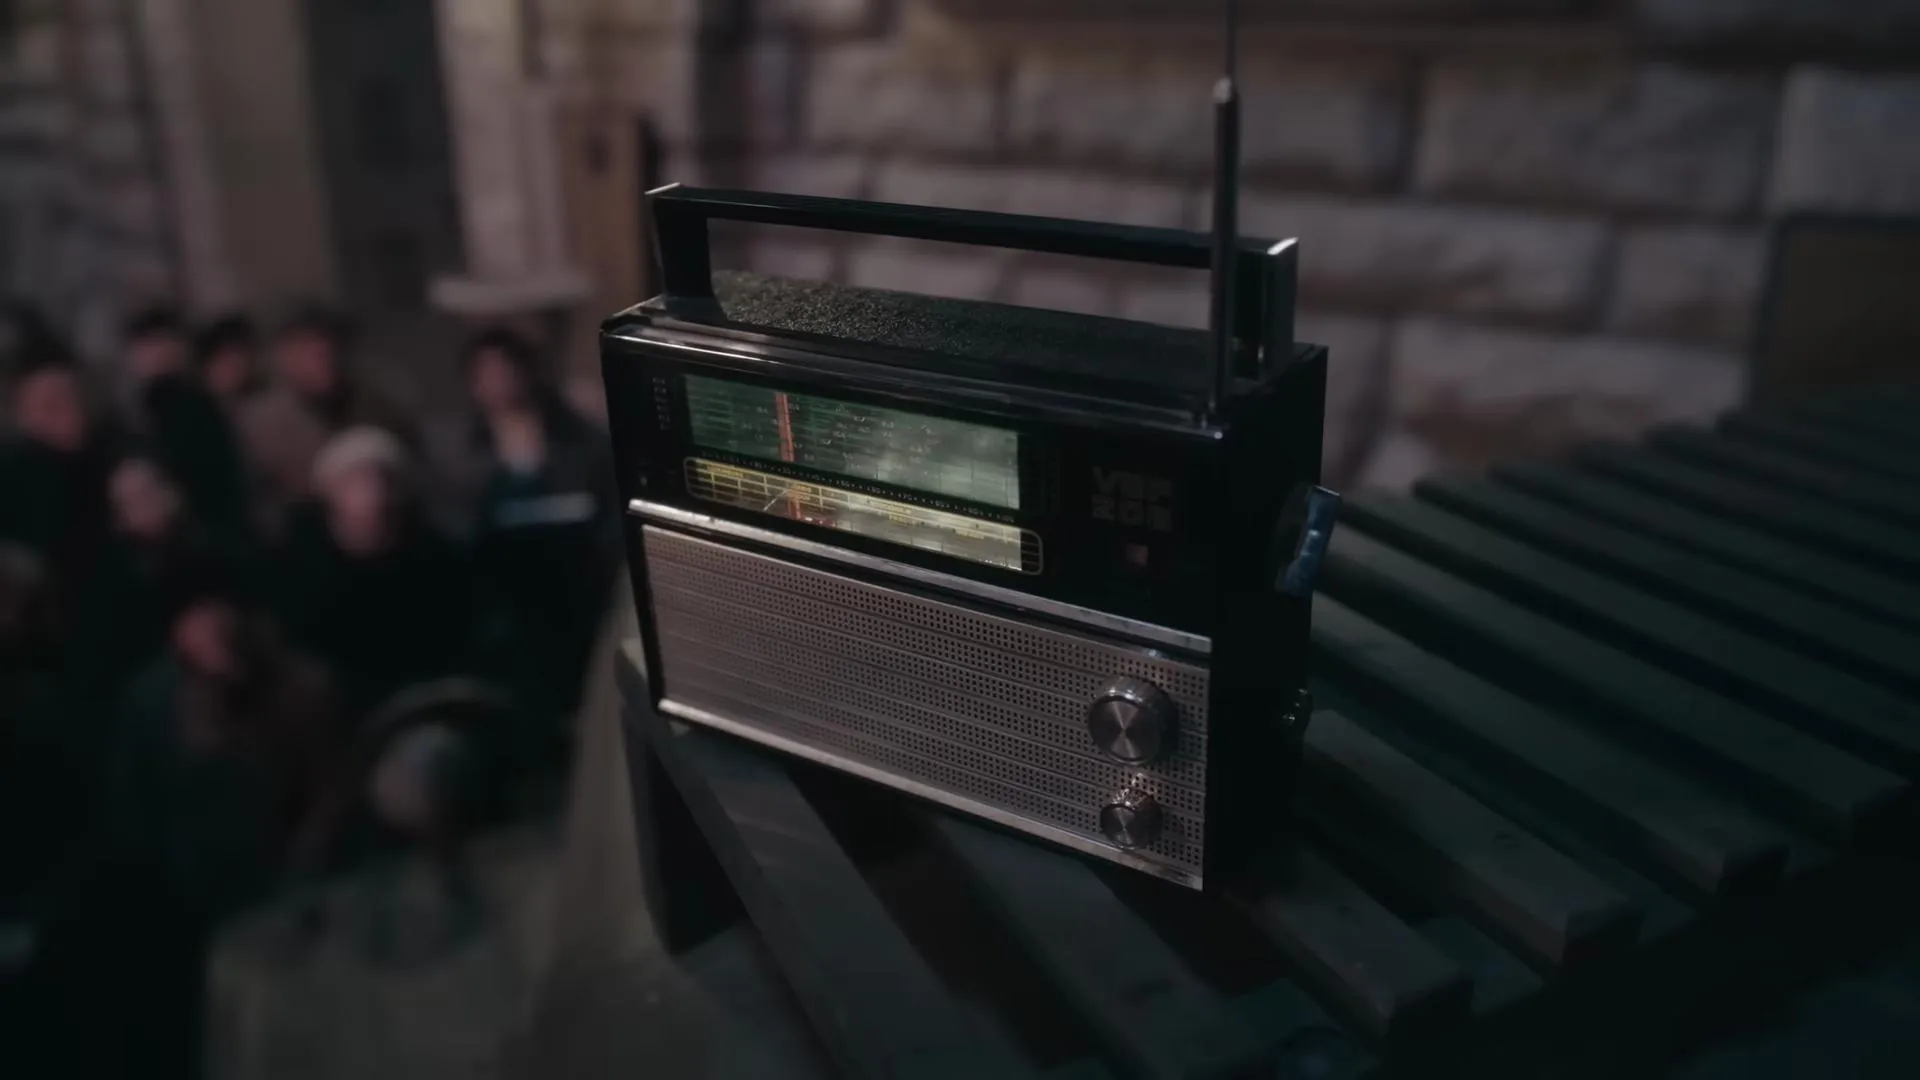

In [73]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).head(1)

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

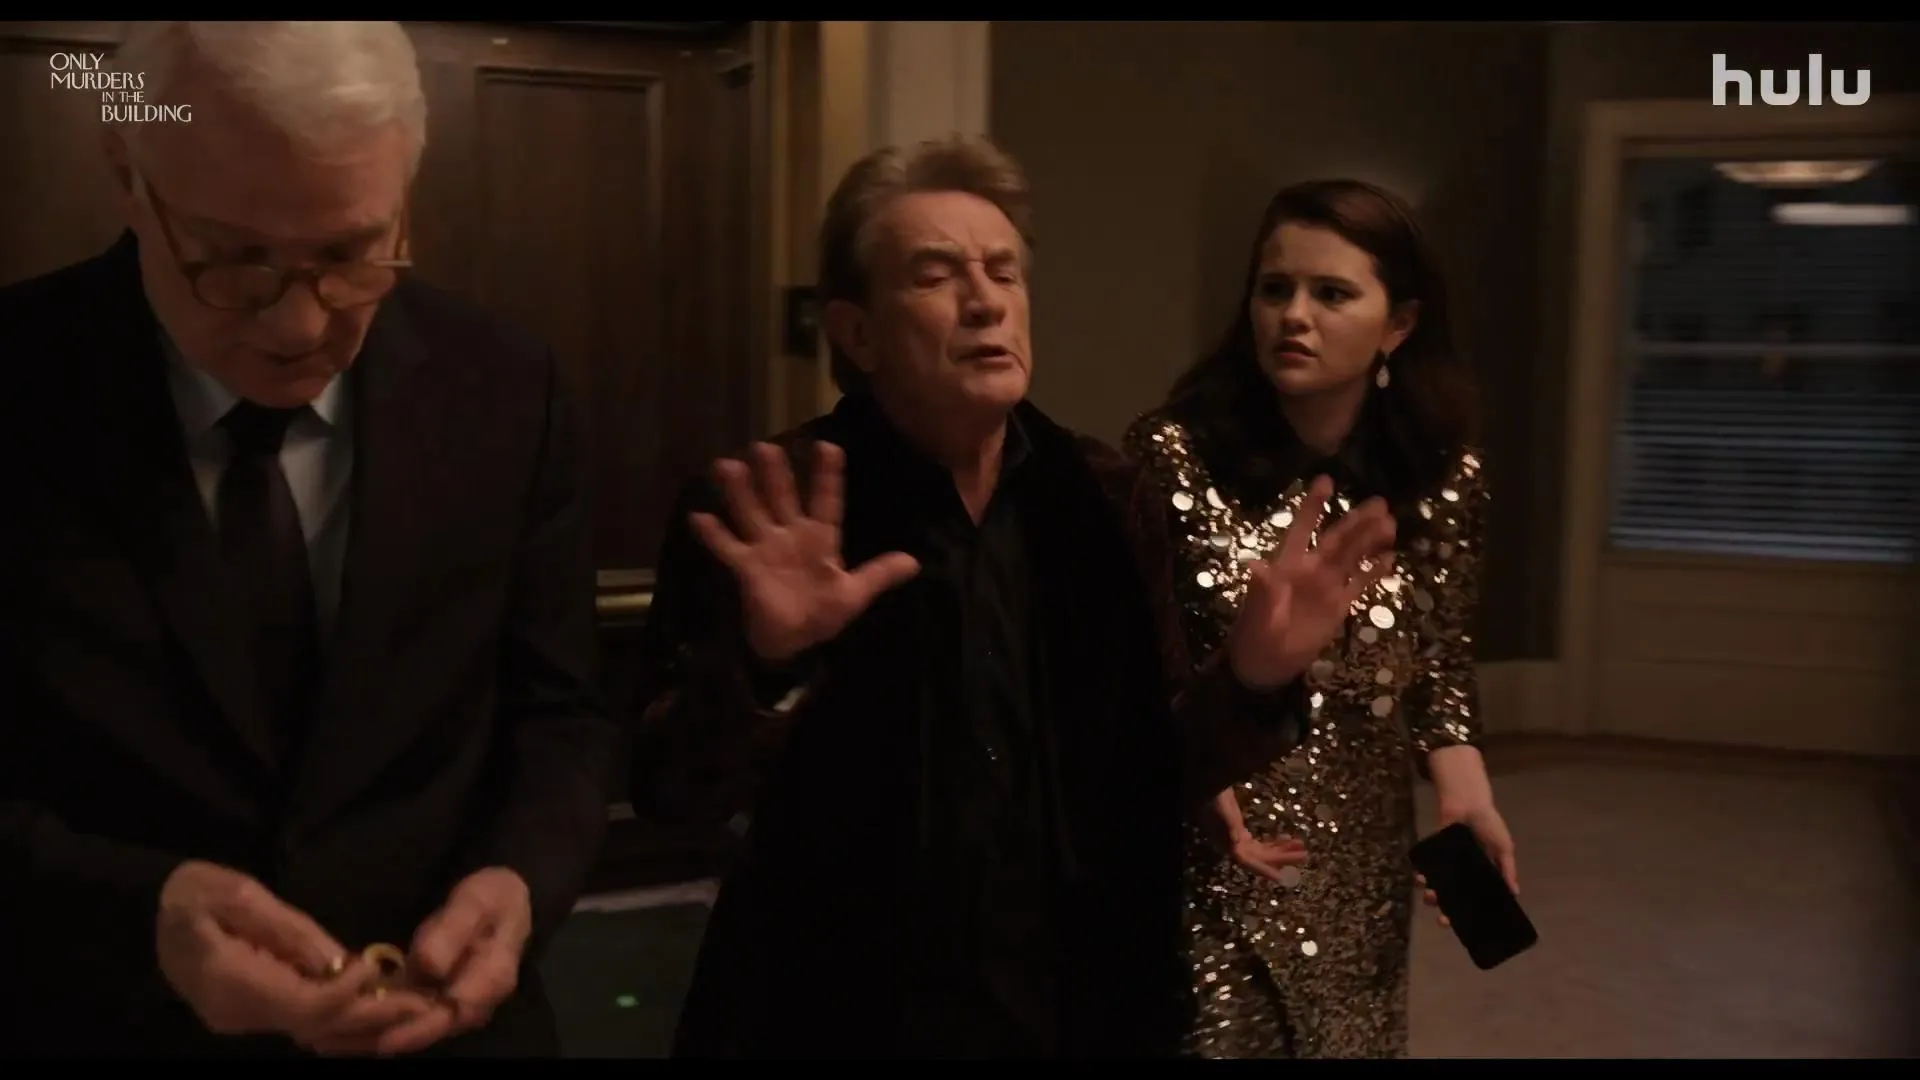

In [14]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).tail(1)

## 03 - Compose Scene Descriptions

Now we'll actually use these text prompts to generate scene prompts for AI image/video models. 

Recall from Act 1 that writing a query using `select()` does not change the underlying table - you can think of this like a purely "in memory" operation that is great for experimentation and transparency in your workflow. Here, we are calling the Gemini model but just for two scenes:

beginning_frame,prompt_text,scene_prompt
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: You're gonna miss the flood? Come on. Come on. Lisa, come on.. Create a detailed prompt for an image generator following this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image.","{""sdk_http_response"": {""headers"": {""Content-Type"": ""application/json; charset=UTF-8"", ""Vary"": ""Origin, X-Origin, Referer"", ""Content-Encoding"": ""gzip"", ""Date"": ""Thu, 29 Jan 2026 01:31:06 GMT"", ""Server"": ""scaffolding on HTTPServer2"", ""X-XSS-Protection"": ""0"", ""X-Frame-Options"": ""SAMEORIGIN"", ""X-Content-Type-Options"": ""nosniff"", ""Server-Timing"": ""gfet4t7; dur=2675"", ""Alt-Svc"": ""h3=\"":443\""; ma=2592000,h3-29=\"":443\""; ma=2592000"", ""Transfer-Encoding"": ""chunked""}, ""body"": null}, ""candidates"": [{""content"": {""parts"": [{""media_resolution"": null, ""code_execution_result"": null, ""executable_code"": null, ""file_data"": null, ""function_call"": null, ""function_response"": null, ""inline_data"": null, ""text"": ""An intricate miniature diorama of Beth Harmon, in full white coat and beret, striding confidently down a grey Berlin street, a gleaming black vint ...... lor palette: predominantly grey, white, black, with subtle hints of beige and red. Mood: Determined, triumphant, slightly melancholic, cinematic.\n"", ""thought"": null, ""thought_signature"": null, ""video_metadata"": null}], ""role"": ""model""}, ""citation_metadata"": null, ""finish_message"": null, ""token_count"": null, ""finish_reason"": ""STOP"", ""avg_logprobs"": -0.584, ""grounding_metadata"": null, ""index"": null, ""logprobs_result"": null, ""safety_ratings"": null, ""url_context_metadata"": null}], ""create_time"": null, ""model_version"": ""gemini-2.0-flash"", ""prompt_feedback"": null, ""response_id"": ""V7h6ae_bOPON_PUPru2i6AM"", ""usage_metadata"": {""cache_tokens_details"": null, ""cached_content_token_count"": null, ""candidates_token_count"": 169, ""candidates_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 169}], ""prompt_token_count"": 1988, ""prompt_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 182}, {""modality"": ""IMAGE"", ""token_count"": 1806}], ""thoughts_token_count"": null, ""tool_use_prompt_token_count"": null, ""tool_use_prompt_tokens_details"": null, ""total_token_count"": 2157, ""traffic_type"": null}, ""automatic_function_calling_history"": [], ""parsed"": null}"
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade.
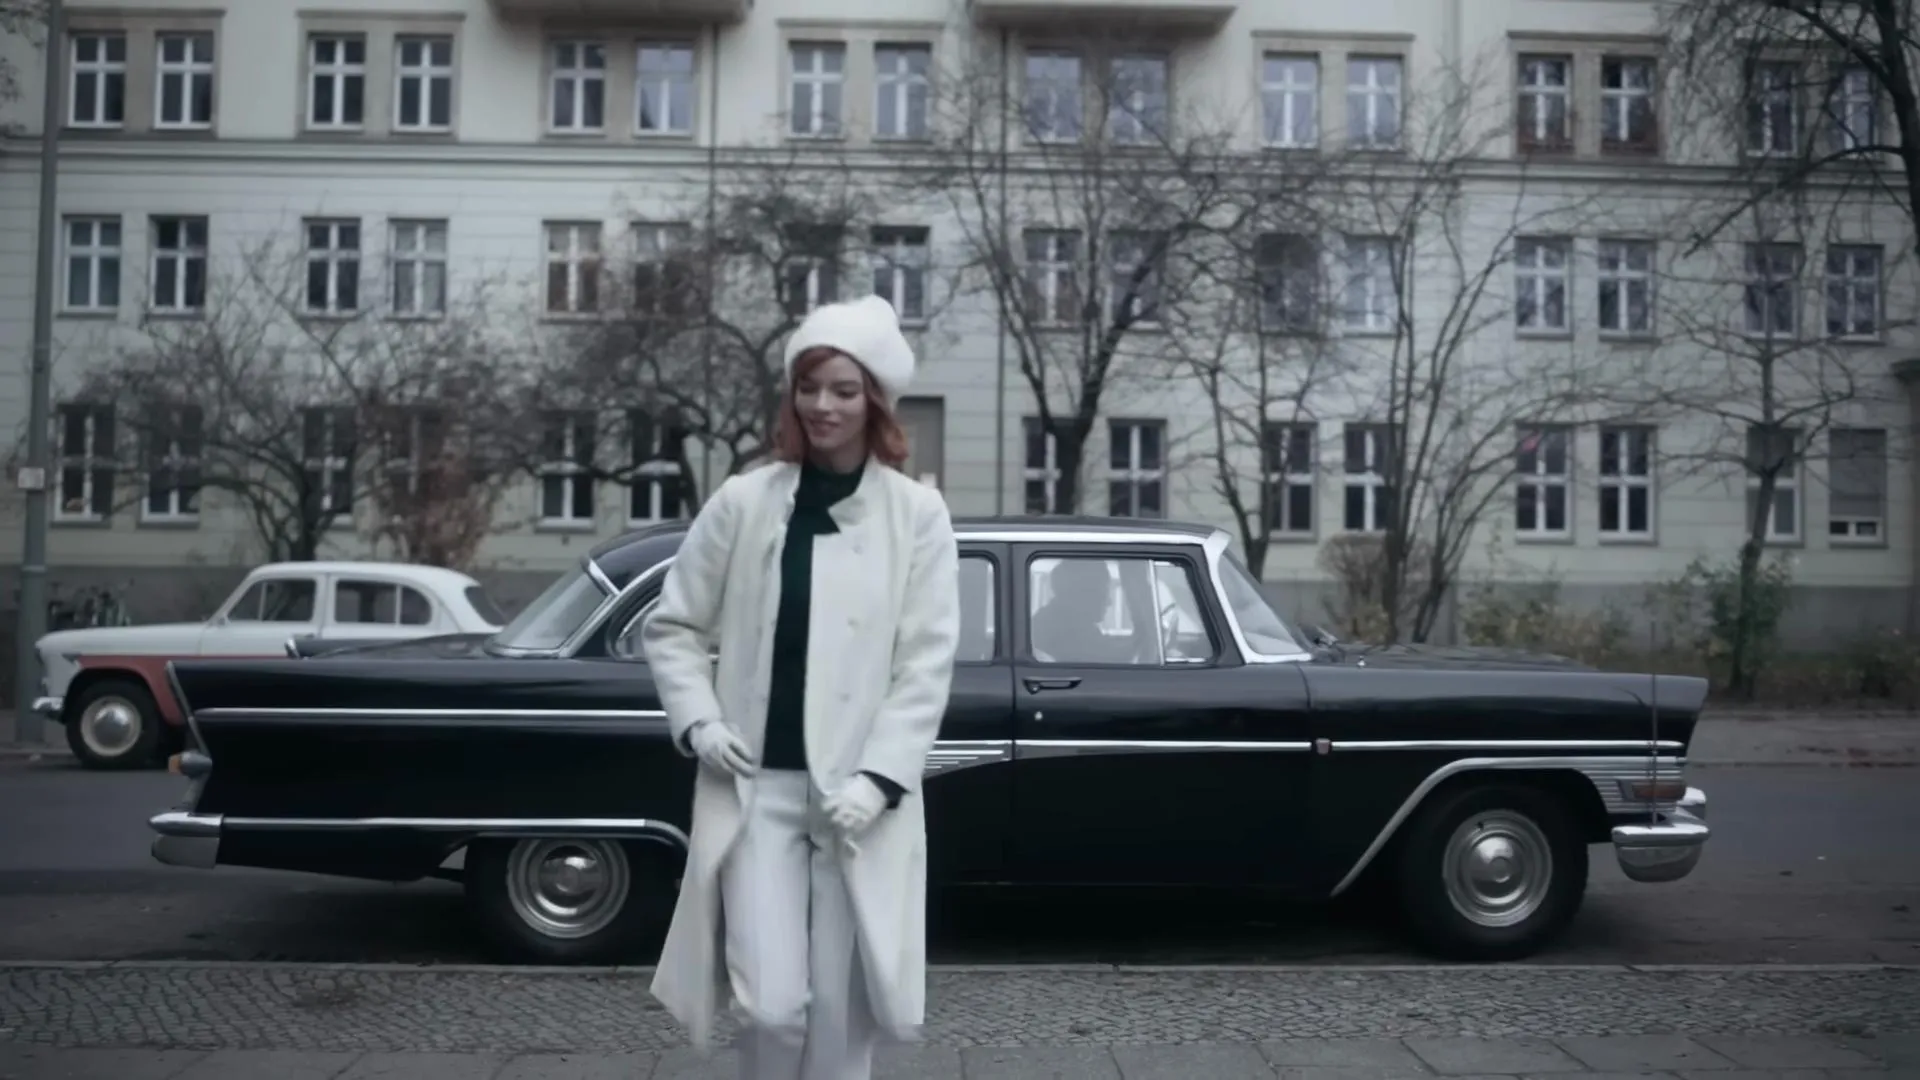
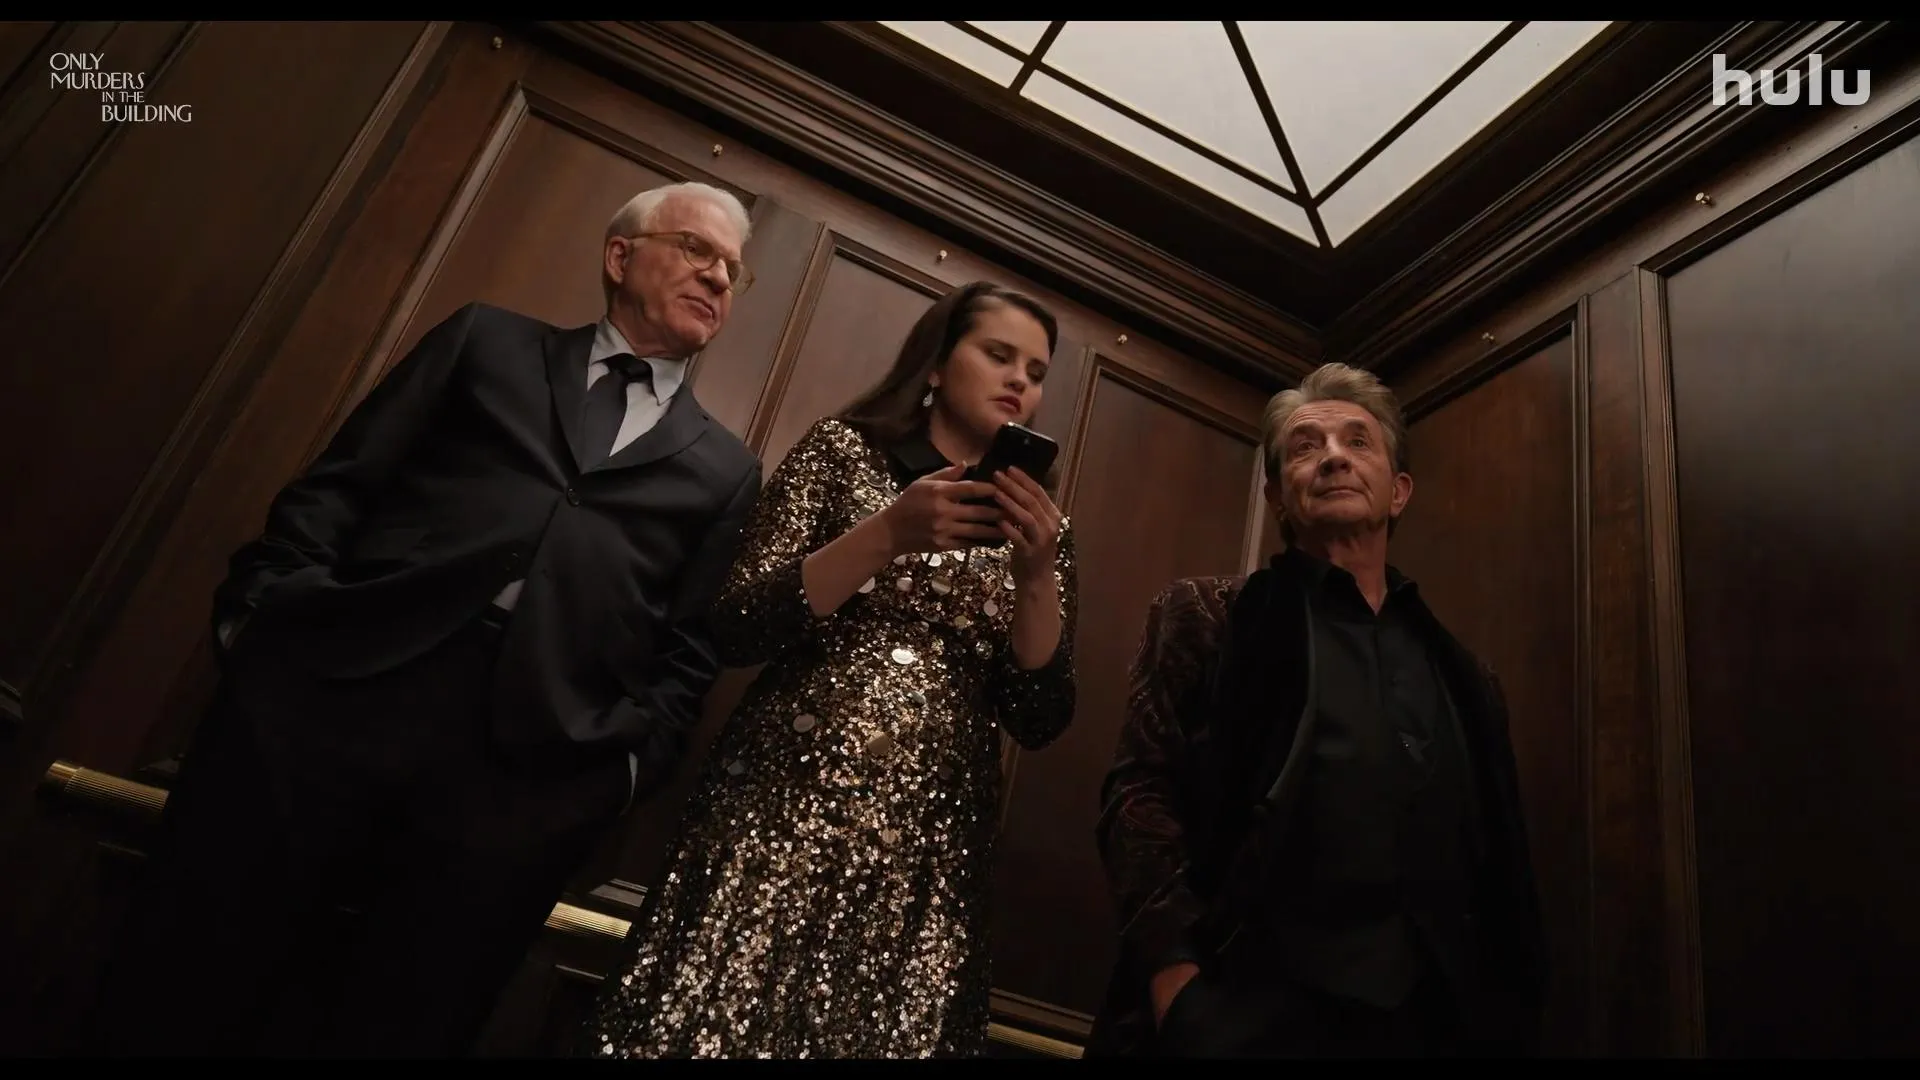

In [74]:
# Test on a single scene
scene_view.where(scene_view.pos == 6).select(
    scene_view.beginning_frame,
    scene_view.prompt_text,
    scene_prompt=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    )
).collect()

You can see that Gemini returns JSON output that needs to be parsed, because we only want the text. We'll take care of that in the next section.

So now we've called the Gemini API for two scenes (one from each video). Our view table remains unchanged:

In [75]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    beginning_frame             Image           video_segment.extract_frame(timestamp=5)
        prompt_text  Required[String]  format('You are creating a miniature diorama s...
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

Now let's add our AI-generated scene prompt as a computed column, and extract just the text we need from the Gemini response.

- This calls the Gemini API for each scene and saves the output in a column in our table persistently. 
- This will take longer (>1 minute) because we are generating across all rows in our table. 
- We'll parse the response to get just the text we need as a separate computed column.

In [76]:
scene_view.add_computed_column(
    prompt_response=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    ), if_exists='replace')

scene_view.add_computed_column(
    scene_prompt=scene_view.prompt_response['candidates'][0]['content']['parts'][0]['text'],
    if_exists='replace'
)

Added 18 column values with 0 errors in 7.29 s (2.47 rows/s)
Added 18 column values with 0 errors in 0.02 s (912.92 rows/s)


18 rows updated.

In [77]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    beginning_frame             Image           video_segment.extract_frame(timestamp=5)
        prompt_text  Required[String]  format('You are creating a miniature diorama s...
    prompt_response    Required[Json]  generate_content(contents=[prompt_text, beginn...
       scene_prompt              Json  prompt_response.candidates[0].content.parts[0]...
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

beginning_frame,scene_prompt
,"An intricate miniature diorama of Beth Harmon, the chess prodigy, arriving in Moscow, surrounded by shadowy figures of onlookers and a imposing Russian official standing guard at the entrance to the Central Chess Club, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, low-key lighting, dramatic miniature lighting emphasizing Beth's face and the cold stone facade. Tiny handcrafted details on the miniature figures, sculpted clay faces with hand-painted expressions, felt clothing, wooden building facades with etched details, signage in Russian visible but illegible. Color palette of muted grays, blues, and beige, with a pop of red in the Russian official's tie. Mood is suspenseful, cold, and a little intimidating, yet charmingly handmade."
,"An intricate miniature diorama of a scene from ""The Queen's Gambit"" in Moscow, depicting a friendly chess encounter in a public square. An elderly man in a dark coat and cap, crafted from felt and wire, reaches out his hand in greeting with a warm smile. Behind him, a small table with a clay chessboard and miniature chess pieces. The background shows buildings made of painted wood, representing the architecture of Cold War Moscow. Photographed with a tilt-shift lens creating selective focus, ...... ature lighting from a hidden source casts long shadows, enhancing the scene's depth and adding a sense of mystery. Tiny handcrafted details include patterned felt for the man's scarf, minute details on the building facades, and precisely arranged chess pieces. The color palette is muted, with grays, browns, and a touch of red in the building details, evoking a Cold War atmosphere. The mood is nostalgic and charmingly handmade, creating a cinematic yet intimate toy-world feel. Close-up shot."
,"An intricate miniature diorama of a tense chess match, the black and cream squares of the handmade wooden chessboard dominate the scene. The chess pieces, crafted from clay and felt, are mid-game, poised for a critical move. A pale hand, disproportionately large for the diorama scale, delicately holds a white queen above the board. An old-fashioned black clock sits slightly out of focus in the background, next to a sheet of paper and a tiny pencil. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Shot type: extreme close-up, focusing on the hand and queen piece. Lighting: Dramatic miniature lighting from a single overhead source creates long shadows and highlights the textures of the tiny objects. The color palette is muted creams, blacks, and browns, evoking a sense of vintage elegance and Cold War austerity. Mood: Intense, suspenseful, and subtly melancholic."

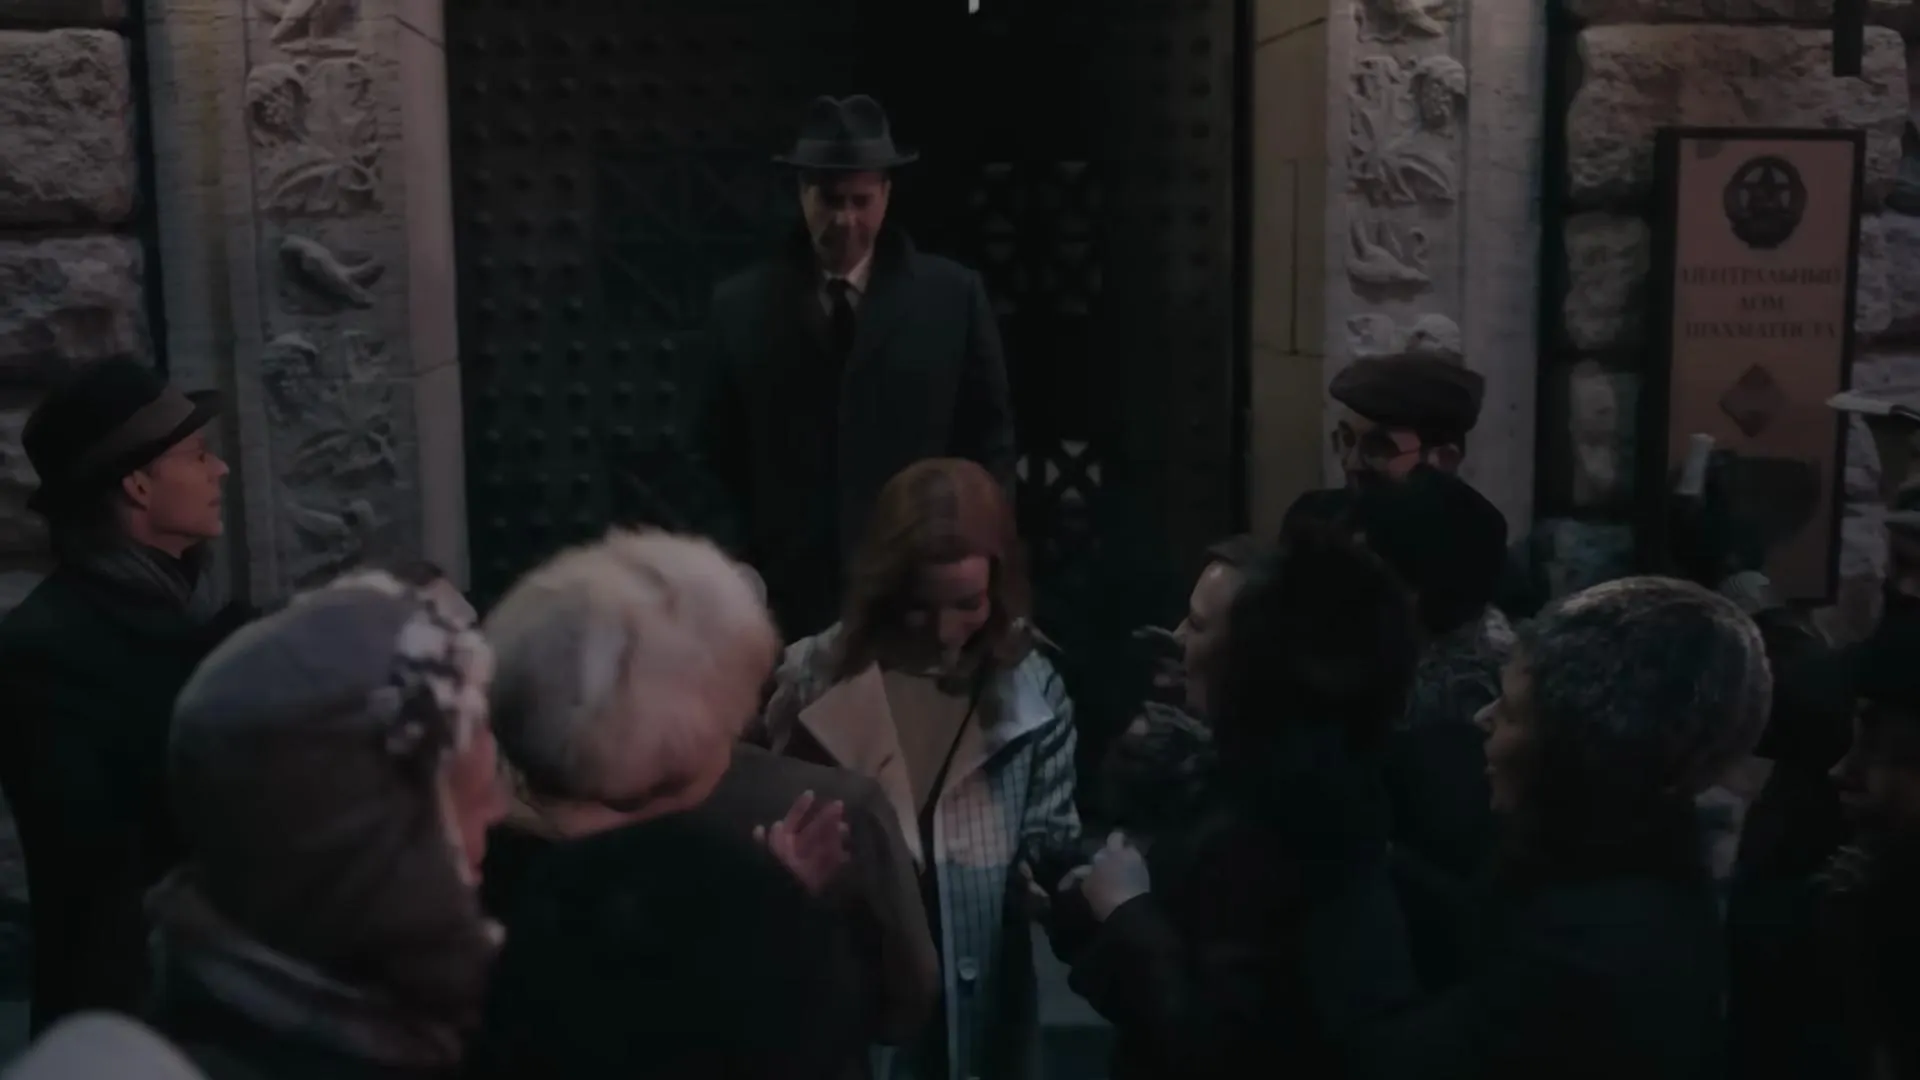
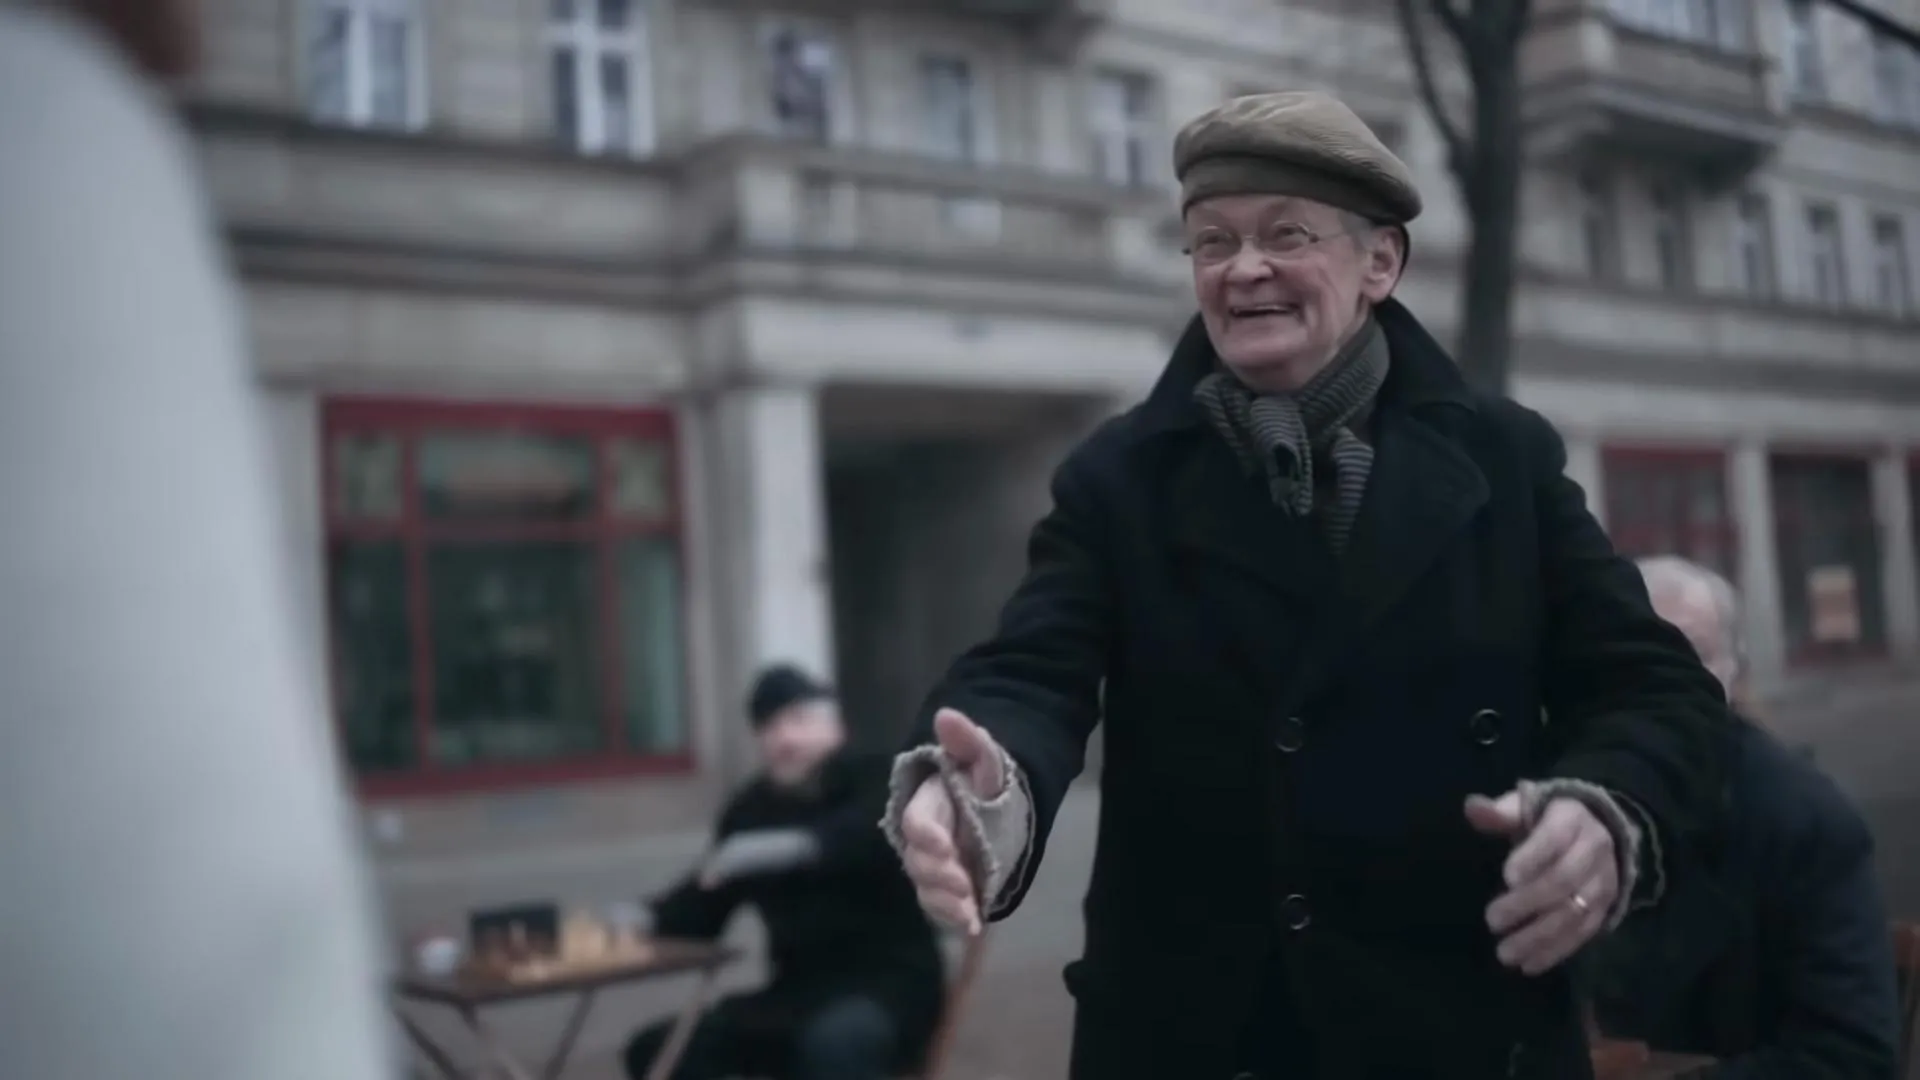
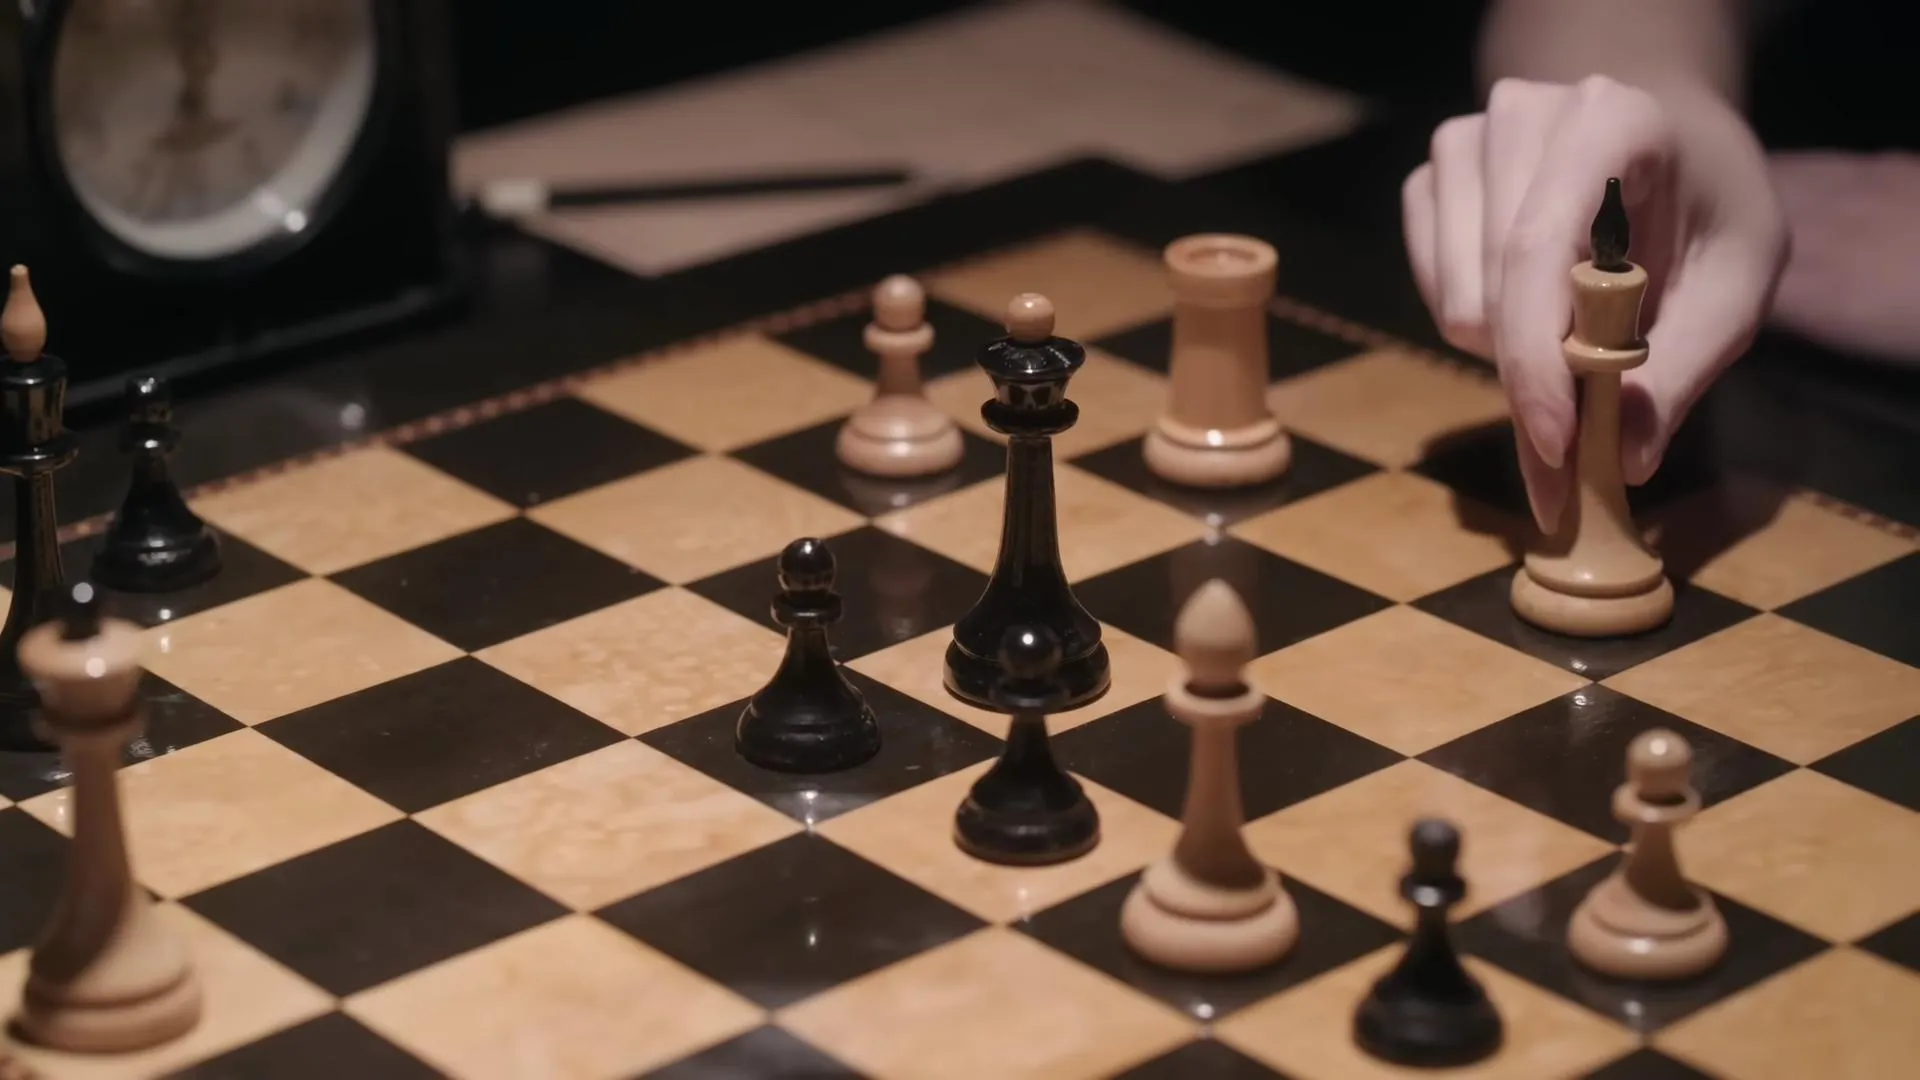

In [78]:
scene_view.select(scene_view.beginning_frame, scene_view.scene_prompt).limit(3).collect()

Now we have a `scene_prompt` column that contains the generated text descriptions. This prompt will be reused for both image and video generation in the next sections.

Let's look at our table history again:

In [79]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,8,2026-01-29 01:33:03.353542+00:00,None,schema,0,18,0,0,Added: scene_prompt
1,7,2026-01-29 01:32:56.052252+00:00,None,schema,0,18,0,0,Added: prompt_response
2,6,2026-01-29 01:29:18.803080+00:00,None,schema,0,18,0,0,Added: prompt_text
3,5,2026-01-29 01:28:09.769716+00:00,None,schema,0,18,0,0,Added: beginning_frame
4,4,2026-01-29 01:23:45.307915+00:00,None,data,101,0,0,0,NaN
5,3,2026-01-29 01:14:18.447759+00:00,None,schema,0,10,0,0,Added: transcript_text
6,2,2026-01-29 01:13:17.995543+00:00,None,schema,0,10,0,0,Added: transcription
7,1,2026-01-29 01:12:59.768463+00:00,None,schema,0,10,0,0,Added: audio
8,0,2026-01-29 01:12:46.255198+00:00,None,schema,10,0,0,0,Initial Version


## 04 - Generate Scene Images

Now let's put these prompts from `gemini-2.0-flash` to the test. We will use these scene prompts to generate visual images, using `imagen-4.0-fast-generate-001` as our text-to-image model.

The examples below use `.select().where()` to test generation on a single scene. This is a **query** - it runs once and returns results without storing anything. This is perfect for testing expensive operations before applying them to all rows. Later, you'll see how to add image generation as a **computed column** to process all scenes automatically and store the results persistently.

Some things to note as you consider these options:

1. All frames are resized from 1920x1080 to 640x360 before being sent to Gemini. Gemini's API limit for combined text and image data is 100MB per request (recently increased from 20MB). We resize to stay well under this limit.

1. In Pixeltable, you can chain image operations like [`.resize()`](https://docs.pixeltable.com/sdk/latest/image#udf-resize) directly on image columns - you don't need to save the resized image to disk or create a separate column to include it in your API call.

1. Many model providers, including Gemini, limit how many requests you can send per minute (RPM = requests per minute), per day (RPD = requests per day), or both (these also may vary by model, too). Pixeltable gives you a few options for working within those rate limits:
    - First, do nothing! Pixeltable defaults to 600 requests per minute, but dynamically listens to model return messages to walk that pace back. For example, Google will tell you at some point to wait for 50+ seconds before submitting another API request. Pixeltable listens to these messages from Google and schedules requests appropriately.
    - Second, you can set rate limits globally across all your Pixeltable projects with a `~./pixeltable/config.toml` per provider and per model. This is a good option if you want to "cap" Pixeltable's API request pace based on known rate limits or budget constraints.
    - Third, you can set rate limits as environment variables. This is a good option for either overriding your global settings from your `config.toml` file, or just to cap the Pixeltable request pace in a specific notebook or Python session.

In [ ]:
# Uncomment to set rate limits in your Python session
#os.environ['GEMINI_RATE_LIMITS'] = '{"gemini-2.0-flash": 10}'
#os.environ['IMAGEN_RATE_LIMITS'] = '{"imagen-4.0-fast-generate-001": 10}'
#os.environ['VEO_RATE_LIMITS'] = '{"veo-3.1-generate-preview": 2}'

Here, we are creating a variable `scene_image` to hold the result of the query. This is an in memory result and does not change your stored table. It is also limited: you can pull this result back up within your Python session only. We'll persist outputs in the next section.

In [80]:
scene_image = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    )
).collect()

pos,scene_prompt,scene_image
7,"An intricate miniature diorama of a scene from ""The Queen's Gambit"" in Moscow, depicting a friendly chess encounter in a public square. An elderly man in a dark coat and cap, crafted from felt and wire, reaches out his hand in greeting with a warm smile. Behind him, a small table with a clay chessboard and miniature chess pieces. The background shows buildings made of painted wood, representing the architecture of Cold War Moscow. Photographed with a tilt-shift lens creating selective focus, ...... ature lighting from a hidden source casts long shadows, enhancing the scene's depth and adding a sense of mystery. Tiny handcrafted details include patterned felt for the man's scarf, minute details on the building facades, and precisely arranged chess pieces. The color palette is muted, with grays, browns, and a touch of red in the building details, evoking a Cold War atmosphere. The mood is nostalgic and charmingly handmade, creating a cinematic yet intimate toy-world feel. Close-up shot.",
7,"An intricate miniature diorama of the ""Only Murders in the Building"" trio Charles, Oliver, and Mabel standing in a hallway of their Upper West Side apartment building; Charles holding a wine cork looking down at it, Oliver with his hands up in a halting manner, Mabel dressed in a sequin dress looking concerned. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot. Dramatic miniature lighting with a spotlight on Charles and the cork, casting long shadows. Tiny handcrafted details include felt suits, clay faces with expressive features, and a meticulously recreated wooden doorframe. The walls are a tan/beige color. Color palette is muted browns, tans, and golds with a touch of sparkle from Mabel's dress. Mood is suspenseful and slightly humorous.",

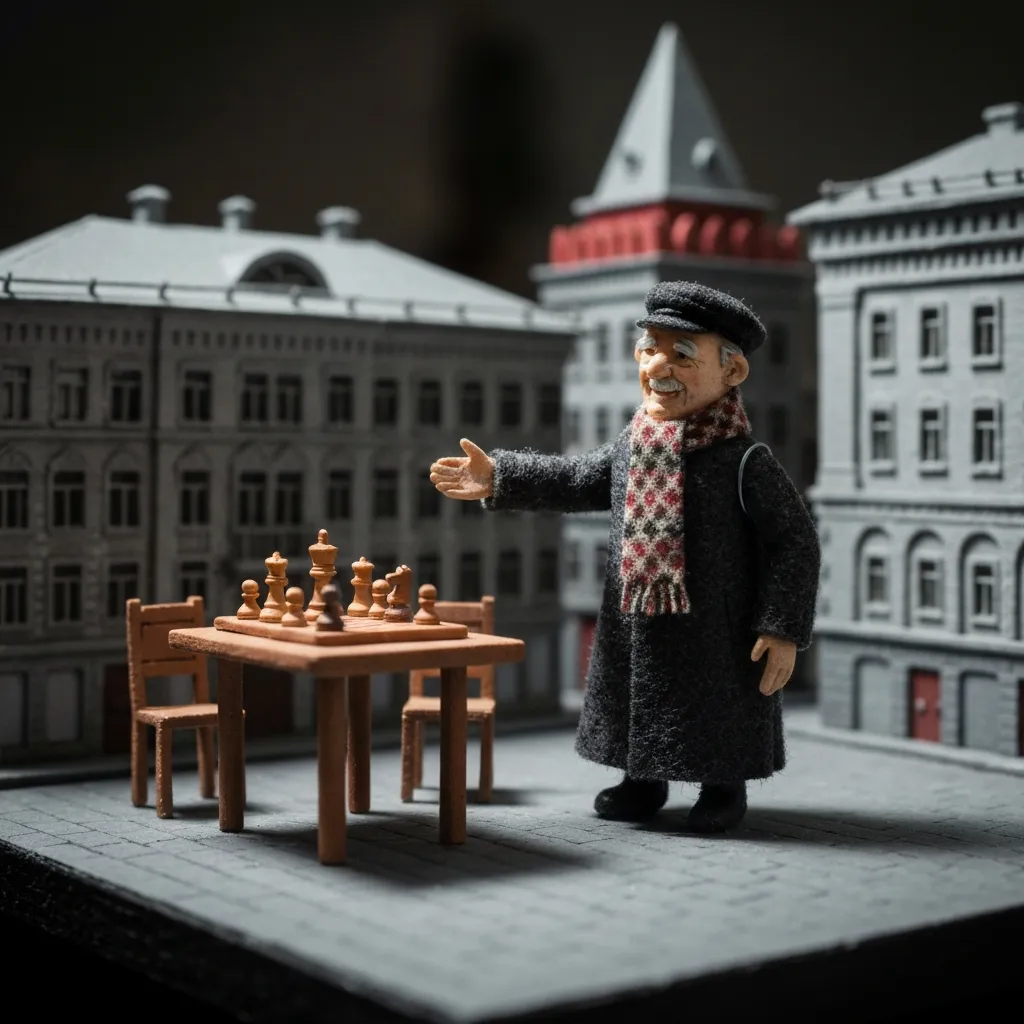
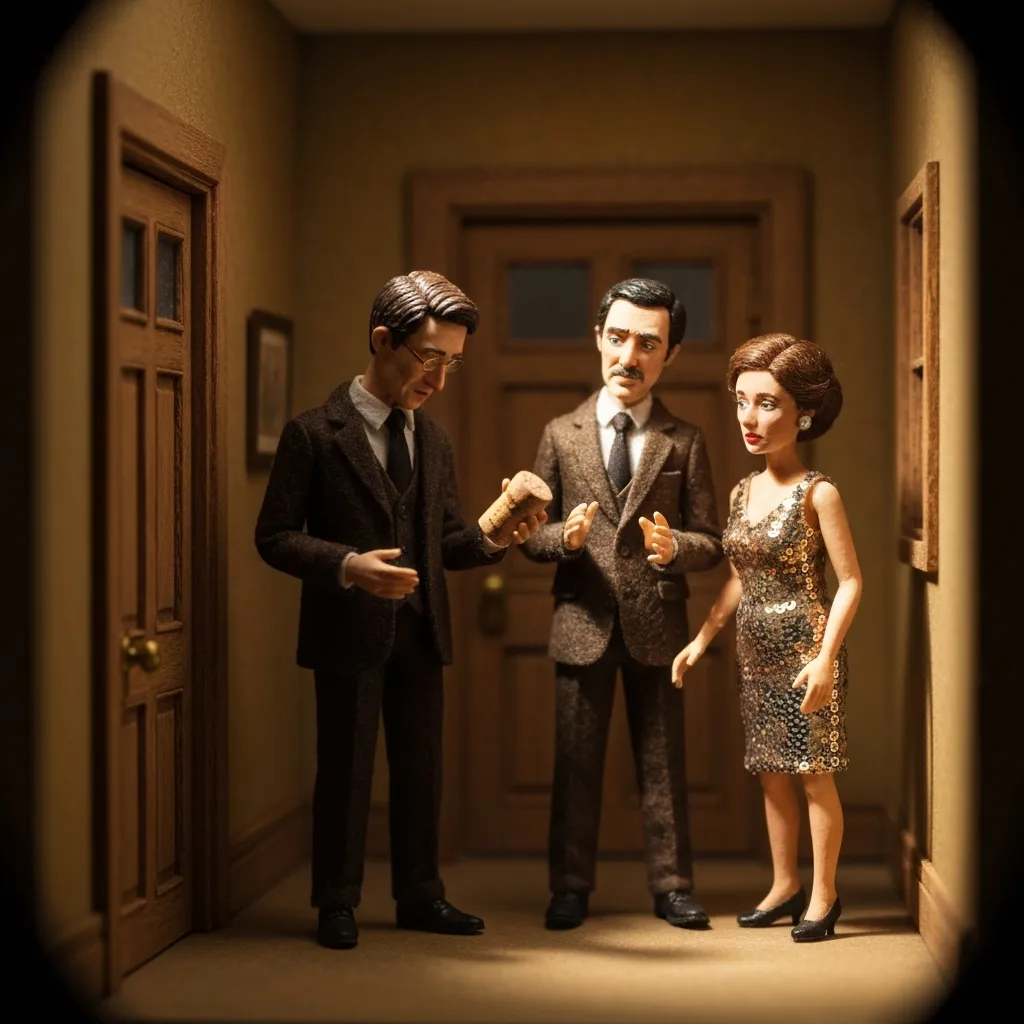

In [81]:
scene_image

## 05 - Add Image Generation to All Scenes

You've tested image and video generation on individual scenes using `.select().where()`. Now you'll add image generation as a computed column to process all scenes automatically.

**What changes when you use a computed column:**

1. **Processes all rows**: Generates images for all rows (here, we have 1 row per scene for each video) with a unique prompt per row
2. **Parallel execution**: Pixeltable parallelizes API calls automatically
3. **Persistent storage**: Results are stored in the table, not just in memory
4. **Incremental updates**: If you add new videos to the base table, the scene detection and image generation cascade automatically

We are using the `imagen-4.0-fast-generate-001` model to generate images. At the time of this workshop, Gemini limits this model to 10 requests per minute with a max of 70 images per day, so you can run this code on all rows within the free tier.

This computed column will automatically generate a "diorama" image for each scene - it takes about 2 minutes to execute.

In [82]:
scene_view.add_computed_column(
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    ),
    if_exists='replace',
    on_error='ignore' # Continue processing despite individual row-wise failures
)

Added 18 column values with 1 error in 39.48 s (0.46 rows/s)


18 rows updated, 1 exception.

**What happens when you execute this code:**

We've created a **declarative workflow** with three computed columns that form a processing pipeline:

1. `beginning_frame` - Extracts a frame from each video segment
2. `scene_prompt` - Generates a text description from the frame (multimodal AI)
3. `scene_image` - Generates an image from the text description (text-to-image AI)

Each computed column builds on the previous one. Pixeltable handles the orchestration - it knows the dependencies and executes them in the correct order automatically.

Let's take a look at our collection of generated images:

pos,scene_prompt,scene_image
0,"An intricate miniature diorama of Mabel, Oliver, and Charles standing in Mabel's dimly lit apartment, surrounded by a chaotic web of red string connecting photos, newspaper clippings, and handwritten notes on corkboards covering the walls. The murdered Tim Kono's bird is perched in its cage. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, dramatic side lighting from a miniature table lamp, tiny handcrafted details like individual strands of yarn and miniature thumbtacks, materials including felt, clay, and balsa wood, color palette featuring muted greens, browns, and a striking accent of red, creating a mood of suspenseful investigation and playful charm.",
1,"An intricate miniature diorama of home movie footage playing on an old projector, the scene depicting a young man on a bicycle next to a brick wall, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, side angle, dramatic miniature lighting, warm glow on the screen and spilling onto the crafted background, tiny handcrafted details of the projector, bicycle, brick texture, and blurred miniature figures in the background made of felt, clay, and wood, color palette of aged film tones, faded browns, and beiges, mood is nostalgic and slightly melancholic.",
2,"An intricate miniature diorama of a young girl, approximately 7 years old, on the phone, looking distressed and upset, in what appears to be a child's bedroom. The girl is made of clay and dressed in a simple blue and white shirt. The oversized black telephone receiver she is holding is also made of clay. The room behind her is minimalist, with light green felt walls. A handmade wooden bed is visible in the blurred background, covered with a plain white felt blanket. Soft, miniature dramatic lighting highlights the girl's face and the phone receiver, casting shadows that emphasize her emotional state. The walls and parts of the telephone are out of focus. The overall color palette is muted and slightly faded, giving a vintage feel. The scene feels both cinematic and charmingly handmade, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere.",
3,"An intricate miniature diorama of a flashback scene: a young boy, sculpted from clay, sits submerged in a blue, slightly-worn kiddie pool, the pool made of painted felt, surrounded by a meticulously crafted lawn of felt grass and miniature trees formed from wire and green flocking. Photographed with a tilt-shift lens creating selective focus, blurring the background and emphasizing the boy's face. Medium shot, eye-level. Dramatic miniature lighting from a single unseen source creates a melancholic, almost ethereal glow on the boy’s face and reflecting on the surface of the water. Tiny handcrafted details are paramount: individually glued grass blades, tiny water ripples, and textured clay skin. The color palette is dominated by muted blues, greens, and browns, creating a nostalgic and slightly unsettling atmosphere. Mood is introspective and wistful.",
4,"An intricate miniature diorama of Charles Haden-Savage’s dimly lit Upper West Side apartment, captured with a tilt-shift lens creating selective focus. The scene shows a cozy yet cluttered corner, featuring a dark green armchair with a draped blue-and-white striped blanket and a black jacket casually thrown over it; a small, ornate side table holds a plate with tiny clay cookies and a miniature crystal glass; behind the chair, a bookshelf packed with miniature books and a framed silhouette p ...... dark wood-paneled wall. Shot type: Close-up. Lighting: Dramatic and warm, with a single miniature lamp casting a soft glow on the scene and creating strong shadows. Tiny handcrafted details: the miniature books are made of paper, the blanket is finely knitted felt, and the cookies are realistically sculpted clay. Materials: Primarily fel
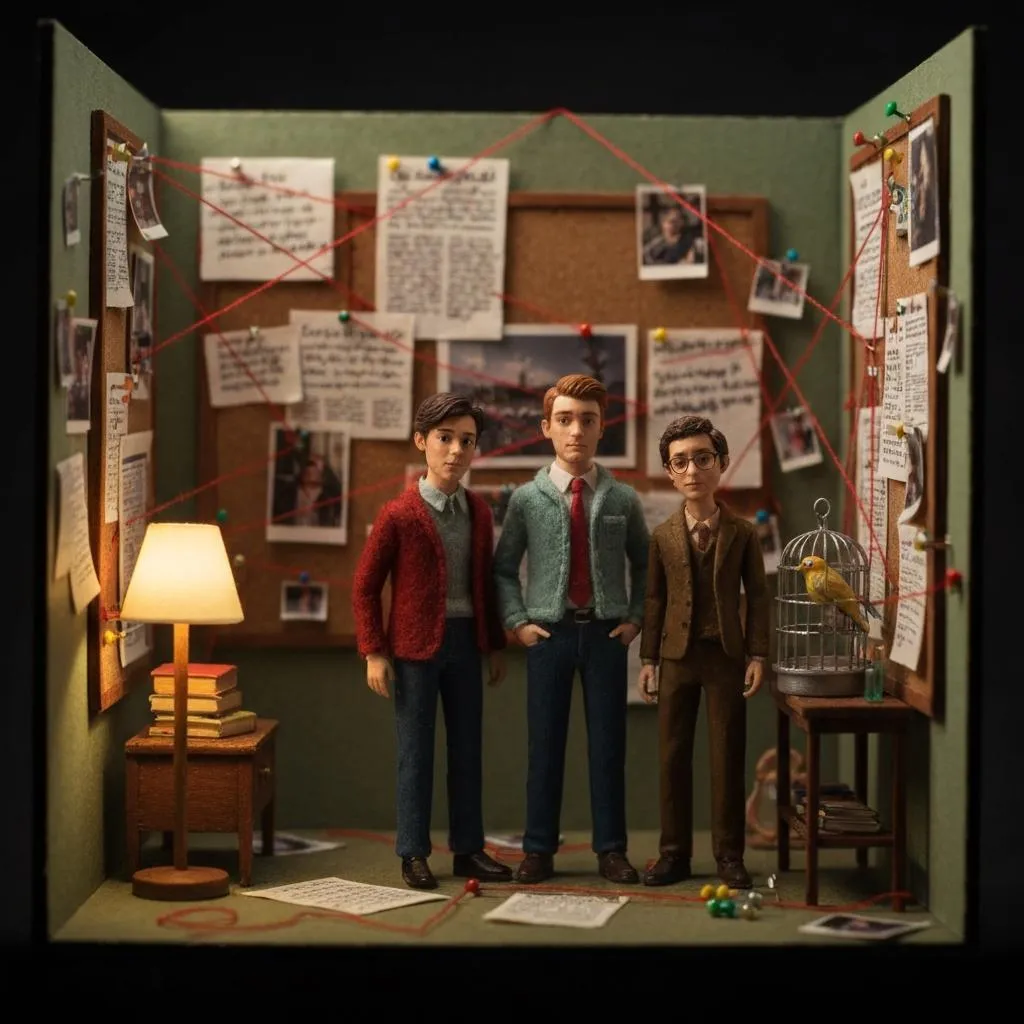
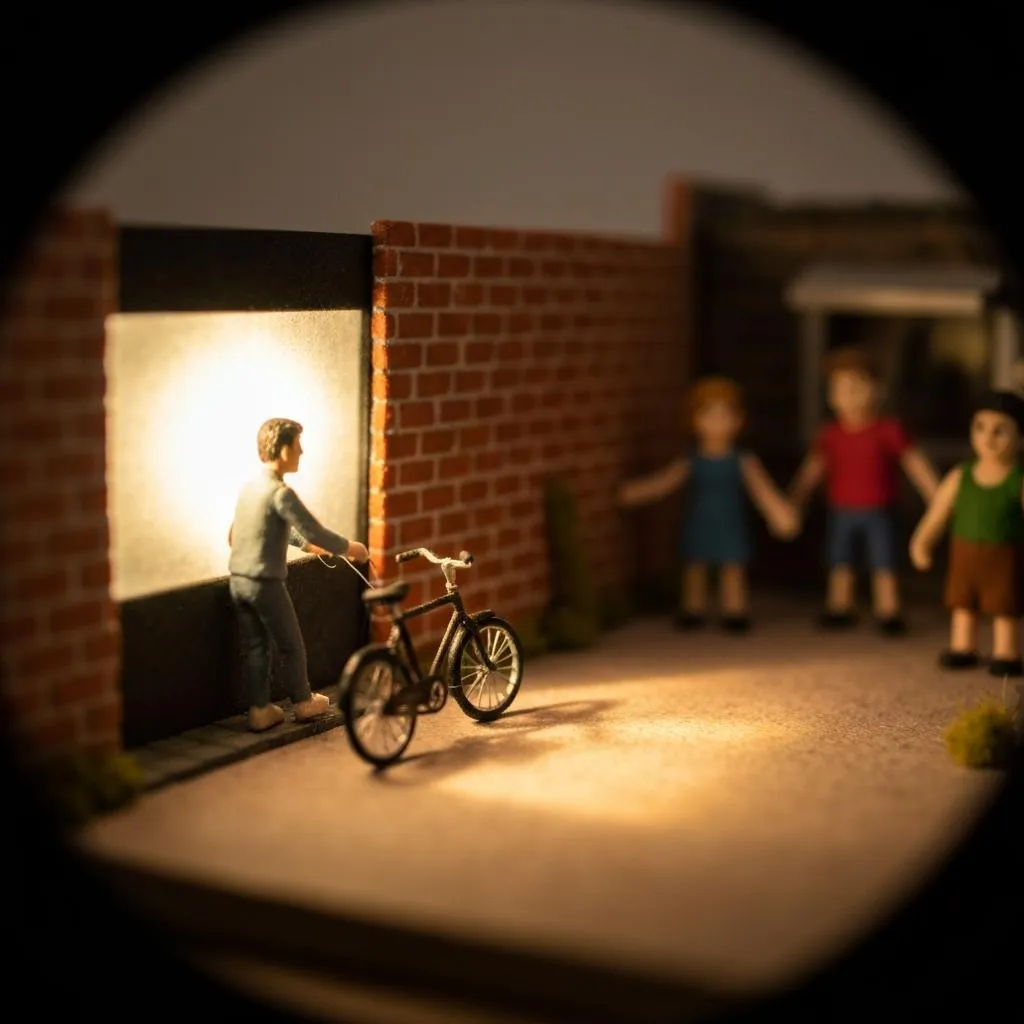
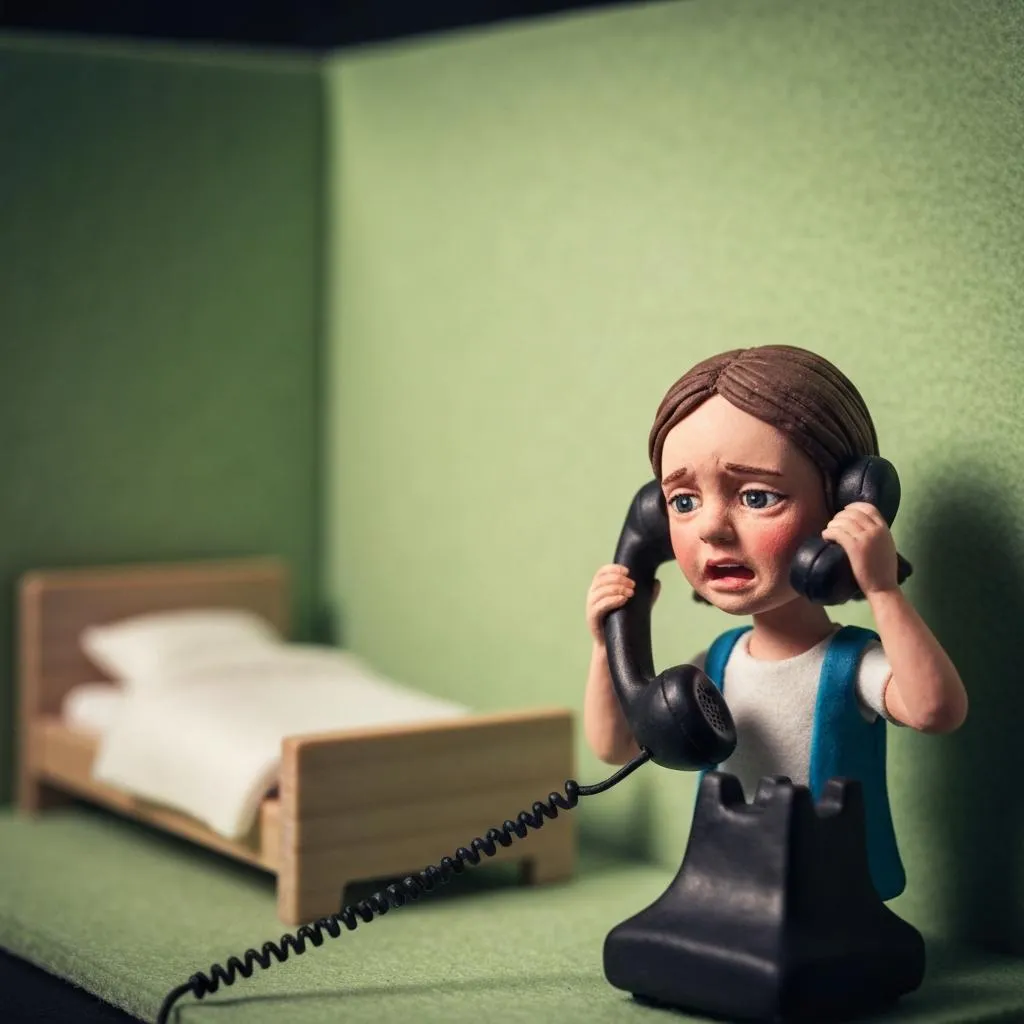
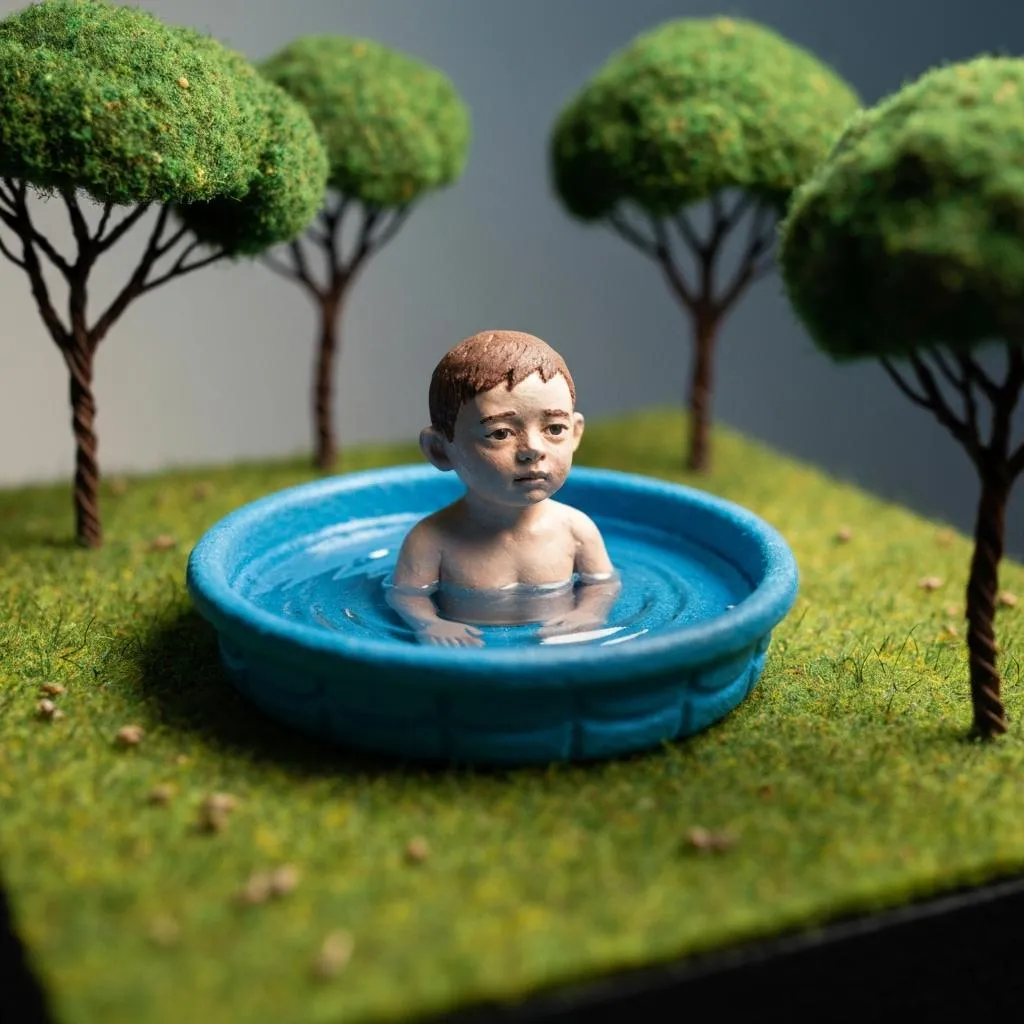
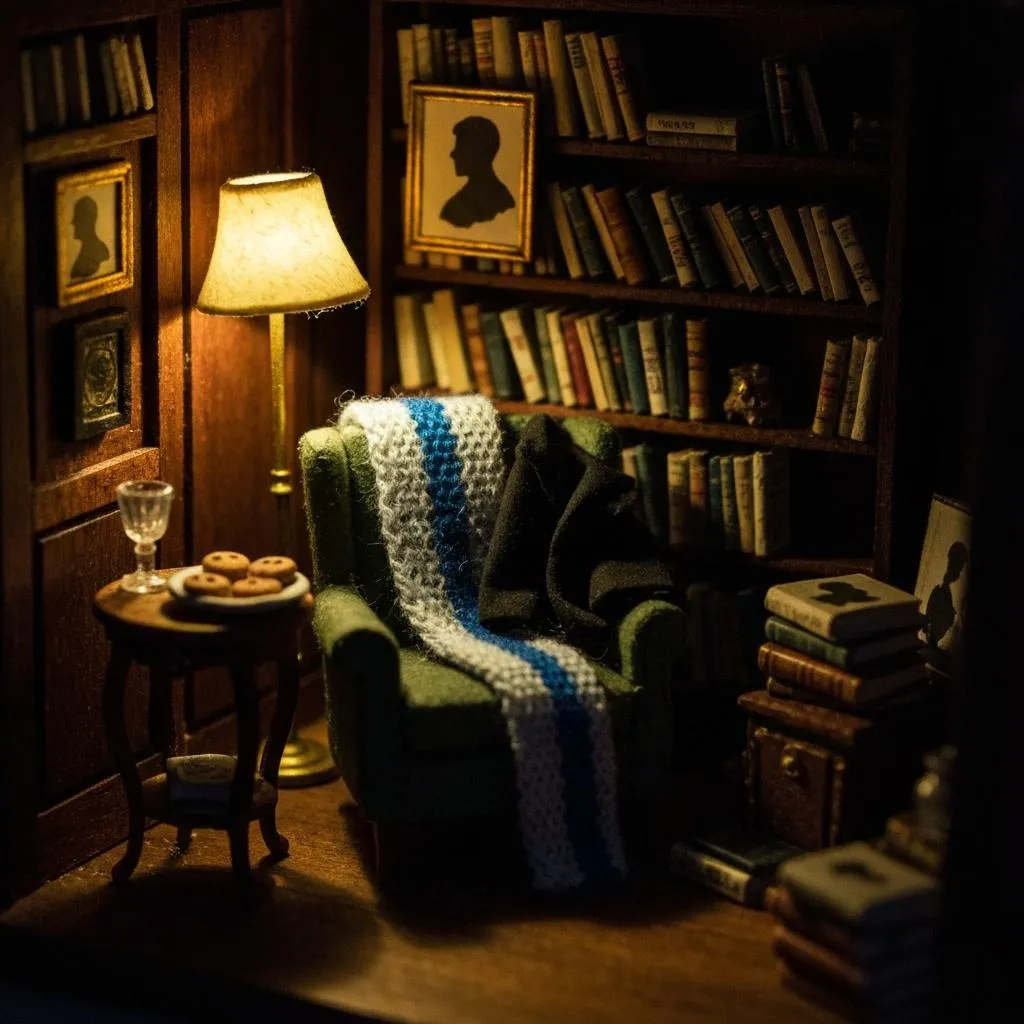
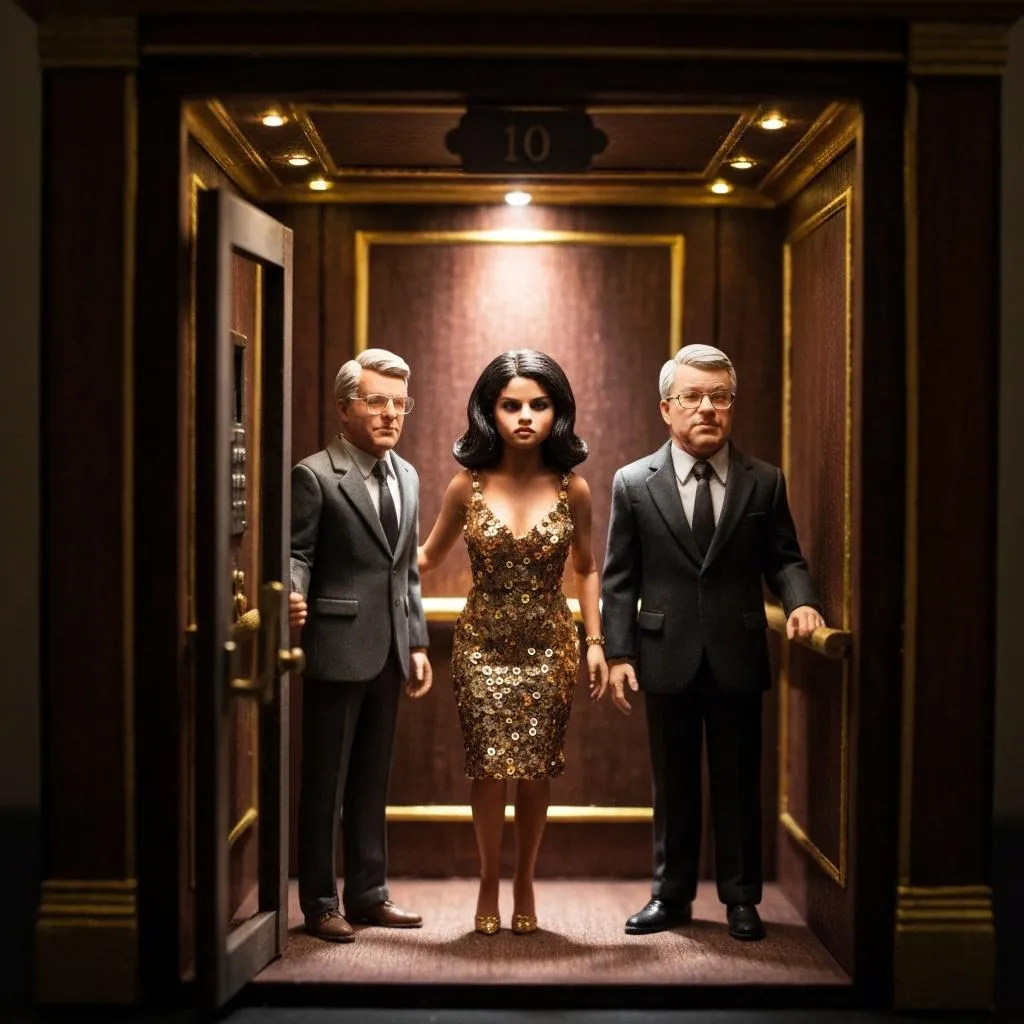
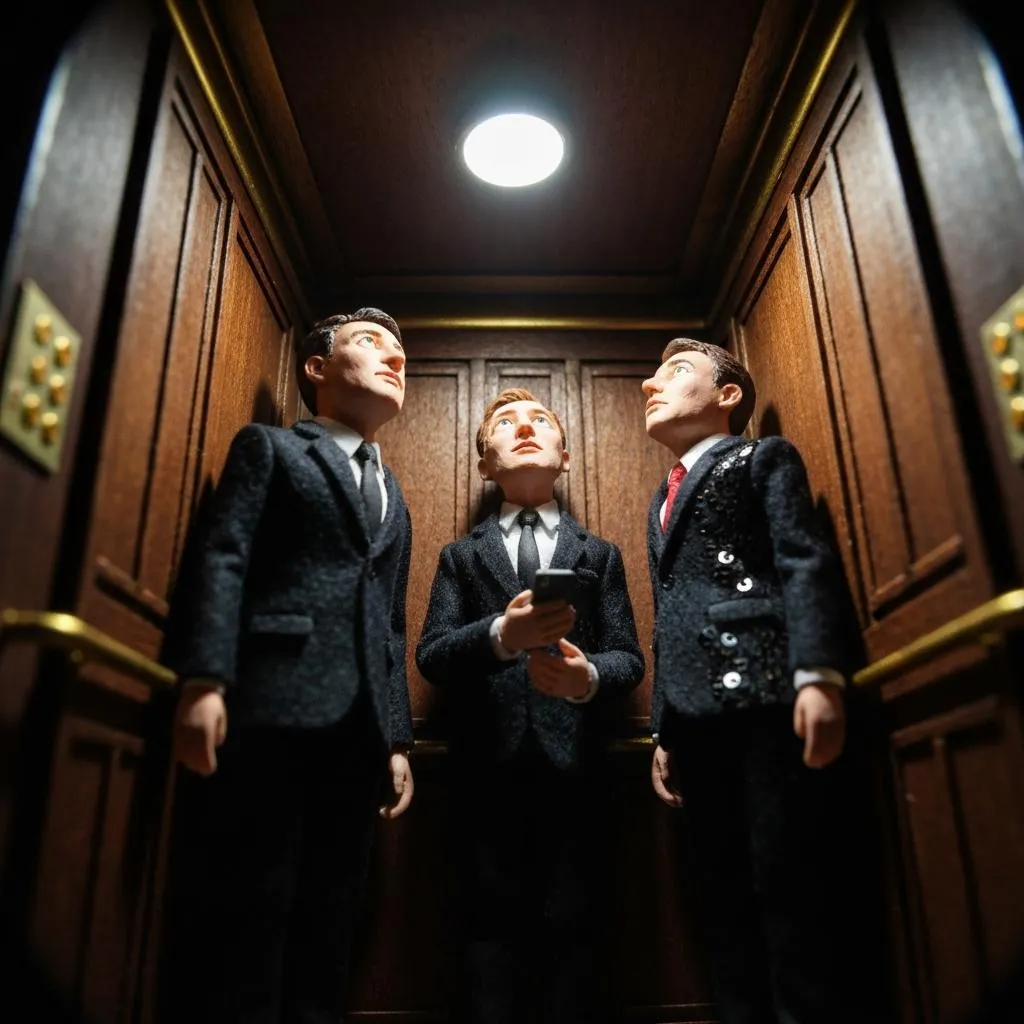
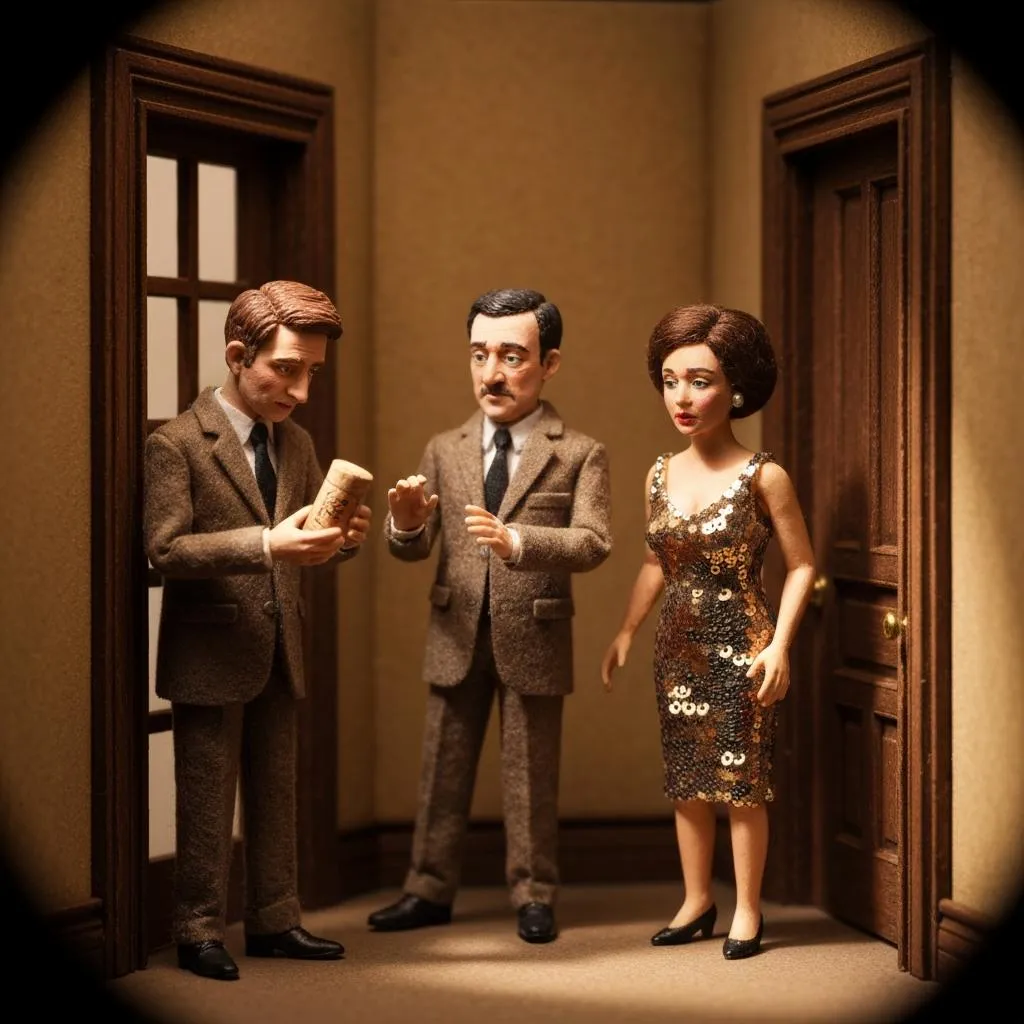

In [83]:
scene_view.where(
    scene_view.title.contains('Murders')
).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

pos,scene_prompt,scene_image
0,"An intricate miniature diorama of a large, old-fashioned black radio resting on a metal xylophone inside a dimly lit grand hall during a chess championship. The hall is densely packed with miniature figures representing spectators, all in mid-century clothing, blurred in the background. Photographed with a tilt-shift lens creating selective focus, isolating the radio and xylophone, resulting in a dreamlike toy-world atmosphere. A close-up shot, eye-level. Dramatic miniature lighting focuses ...... io is meticulously handcrafted, showing tiny knobs, a metal grill, and a telescoping antenna. The xylophone is constructed from individual wooden bars, each painted a slightly different shade of green. Materials include painted felt, carved clay for the figures, and realistically textured wood. A cool, muted color palette with grays, greens, and blacks predominates. The mood is suspenseful and anticipatory, reflecting the tension of the chess match and the crowd waiting to hear the results.",
1,"An intricate miniature diorama of Grandmaster Vasily Borgov in deep concentration during a tense chess match against Beth Harmon. His face, crafted from clay, shows a stoic expression with minute details of wrinkles etched in. He is wearing a tailored dark wool suit with a felt tie. Across from him is an empty chair, awaiting Beth. The chess board, made of wood, sits on a mahogany table under a single, bright, miniature spotlight highlighting the chess pieces. The backdrop is dark, with shadows suggesting a large, ornate room. Photographed with a tilt-shift lens creating selective focus on Borgov's face, conveying the atmosphere of intense pressure. Dramatic miniature lighting enhances the details, highlighting the handcrafted elements. A warm, muted color palette creates a serious, yet charmingly handmade feel. Close-up shot.",
2,"An intricate miniature diorama of a tense chess match, the black and cream squares of the handmade wooden chessboard dominate the scene. The chess pieces, crafted from clay and felt, are mid-game, poised for a critical move. A pale hand, disproportionately large for the diorama scale, delicately holds a white queen above the board. An old-fashioned black clock sits slightly out of focus in the background, next to a sheet of paper and a tiny pencil. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Shot type: extreme close-up, focusing on the hand and queen piece. Lighting: Dramatic miniature lighting from a single overhead source creates long shadows and highlights the textures of the tiny objects. The color palette is muted creams, blacks, and browns, evoking a sense of vintage elegance and Cold War austerity. Mood: Intense, suspenseful, and subtly melancholic.",
3,"An intricate miniature diorama of Beth Harmon, in her teens, in a darkened bedroom, hunched over, obsessively arranging pills on her nightstand; photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium close-up shot, low-key dramatic lighting with a single warm lamp creating long shadows, tiny handcrafted details like individual pills made of clay, a crocheted blanket on the bed, and a miniature chess book, materials like felt for the bedspread, clay for Beth's figure and the pills, wood for the nightstand, a muted color palette of browns, creams, and deep reds, conveying a mood of intense focus and inner turmoil.",None
4,"An intricate miniature diorama of Beth Harmon, the chess prodigy, arriving in Moscow, surrounded by shadowy figures of onlookers and a imposing Russian official standing guard at the entrance to the Central Chess Club, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, low-key lighting, dramatic miniature lighting emphasizing Beth's face and the cold stone facade. Tiny handcrafted details on the miniature figures, sculpted clay faces with hand-pa
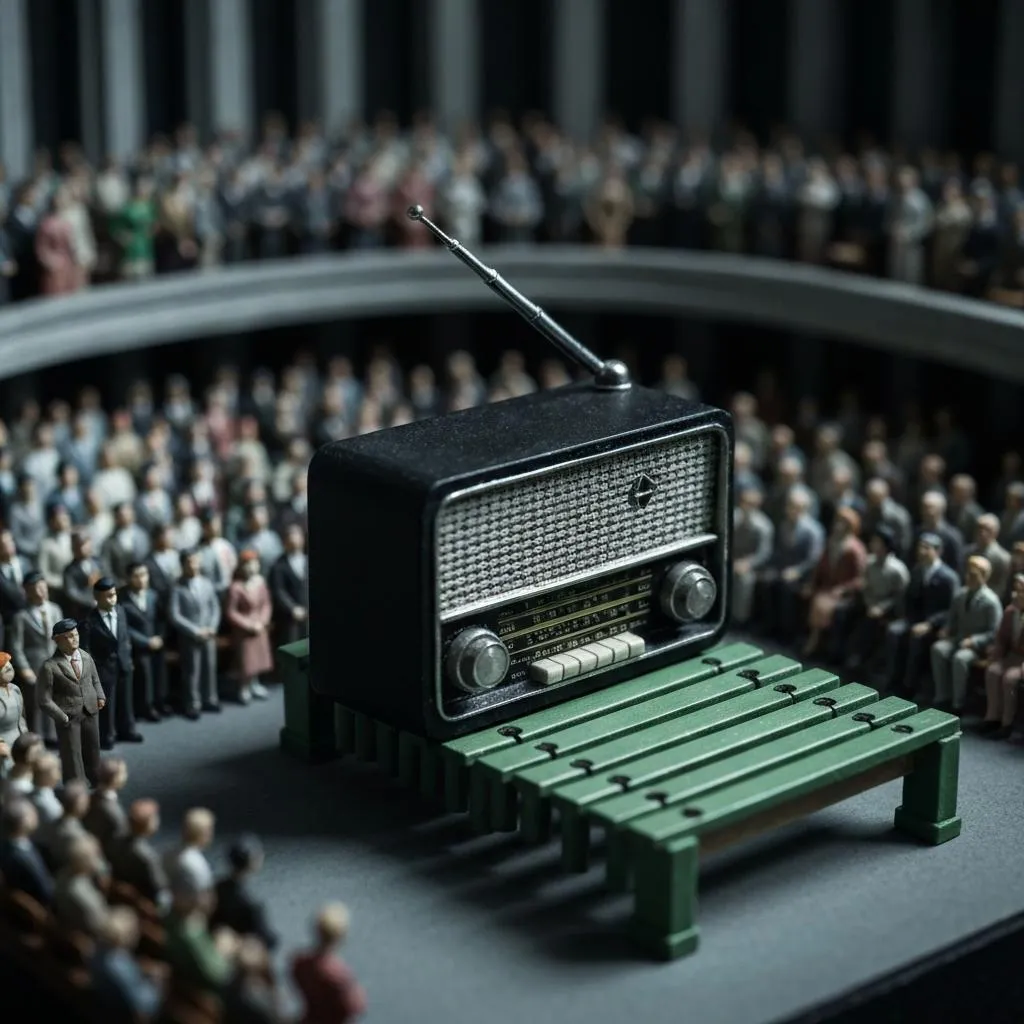
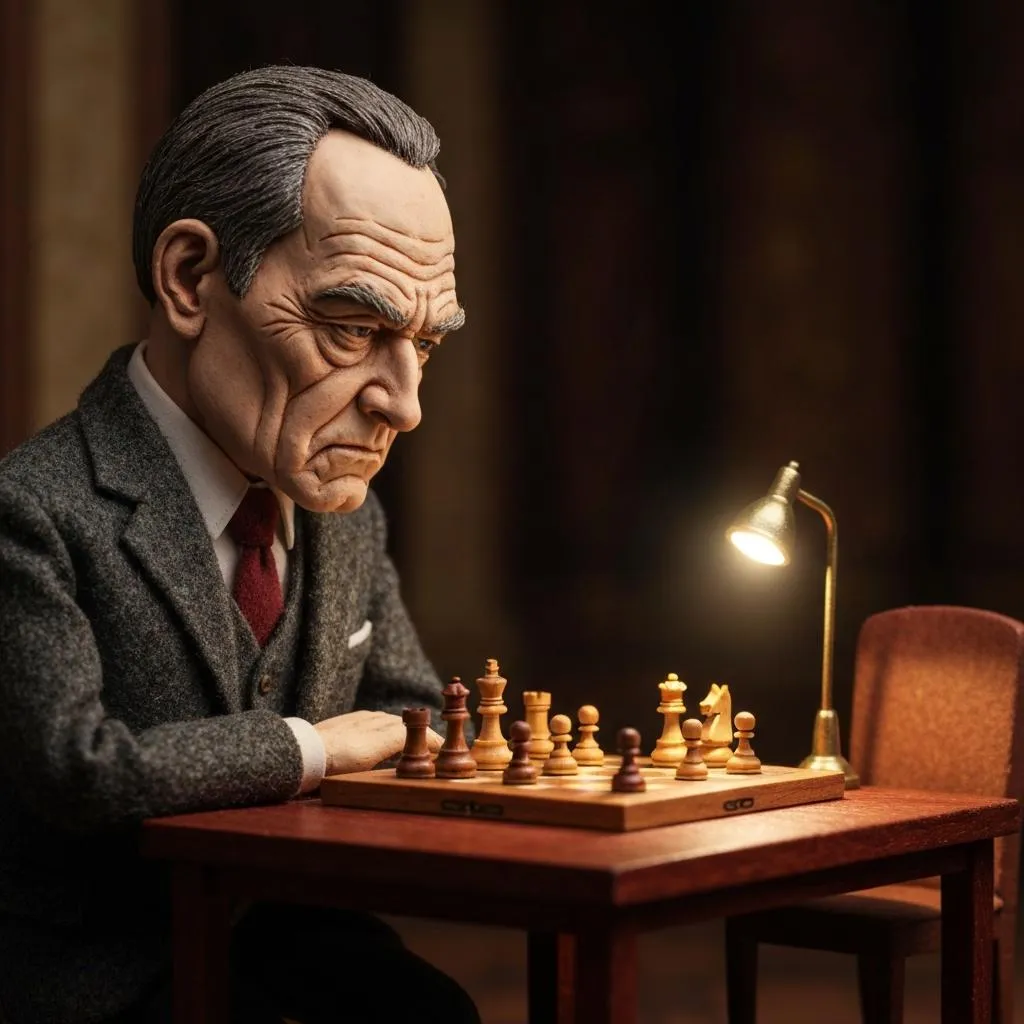
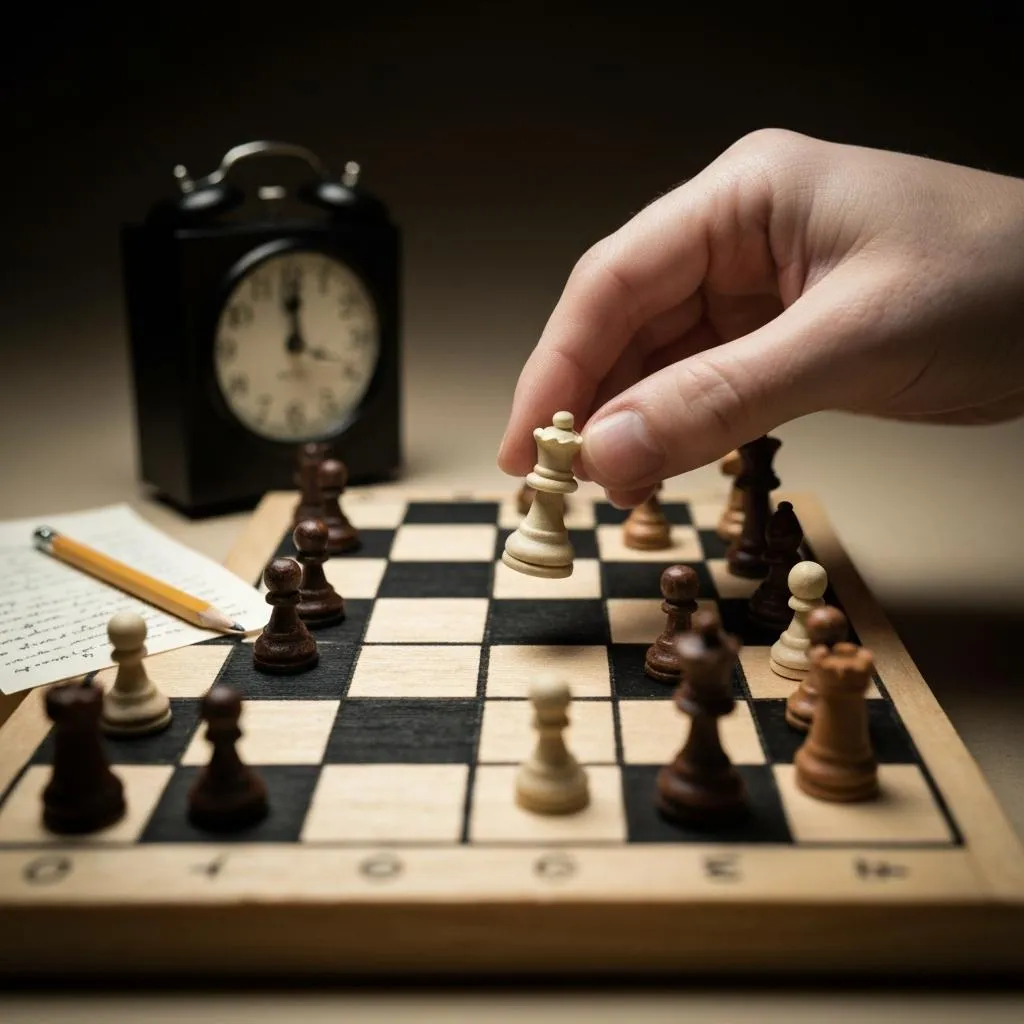
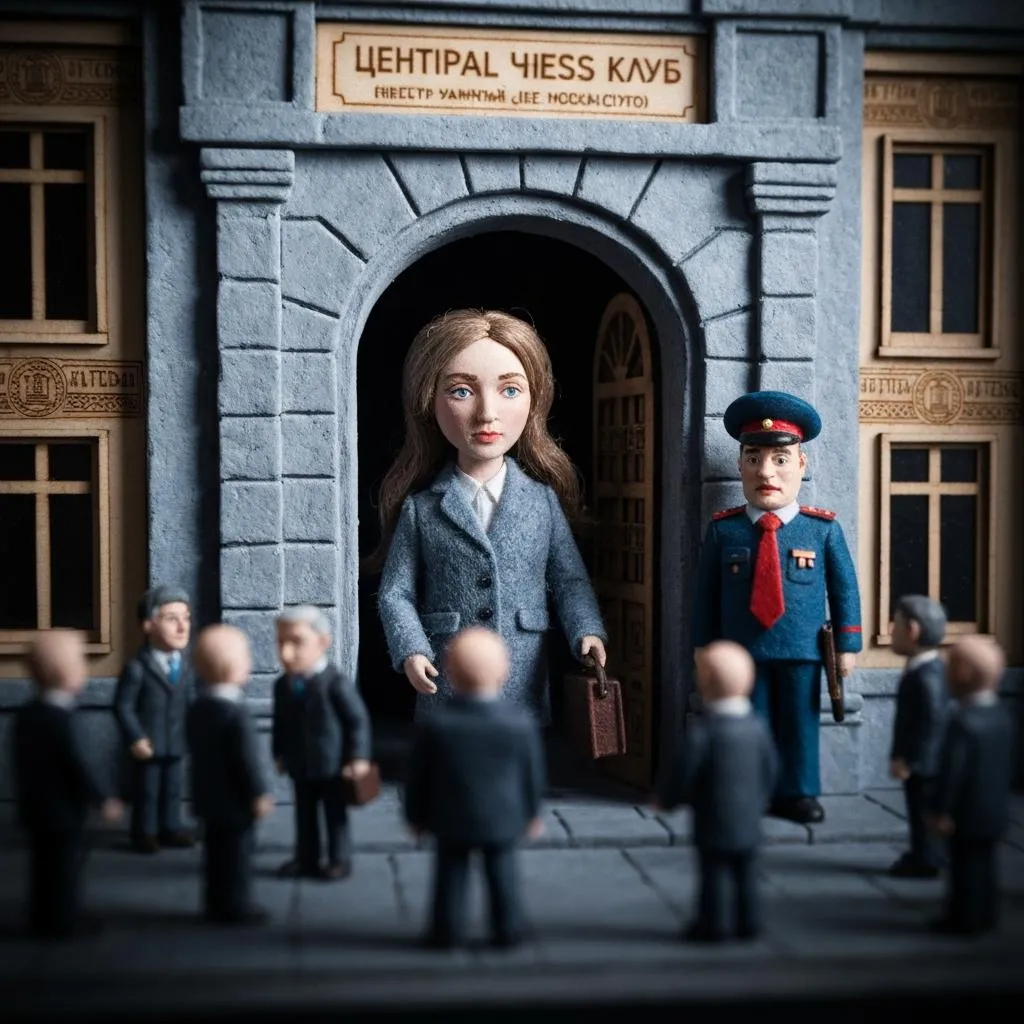
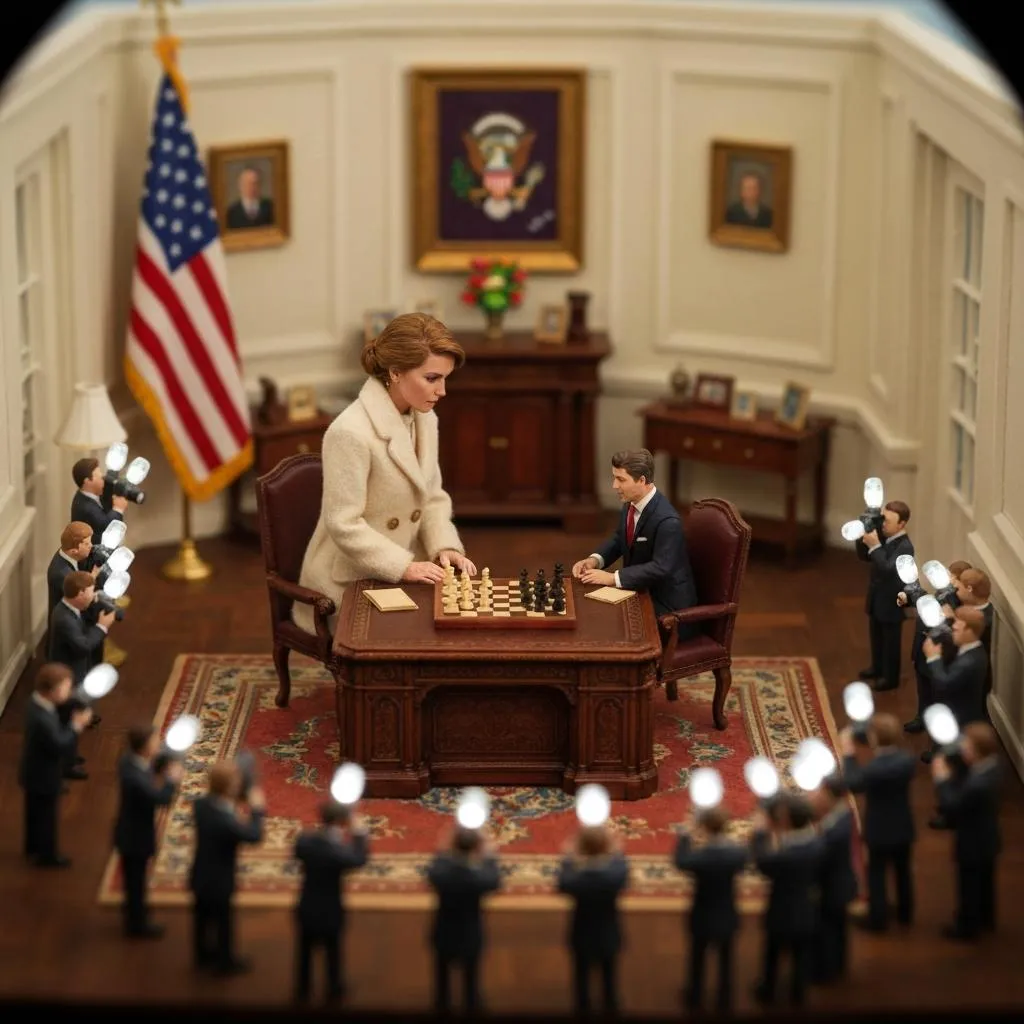
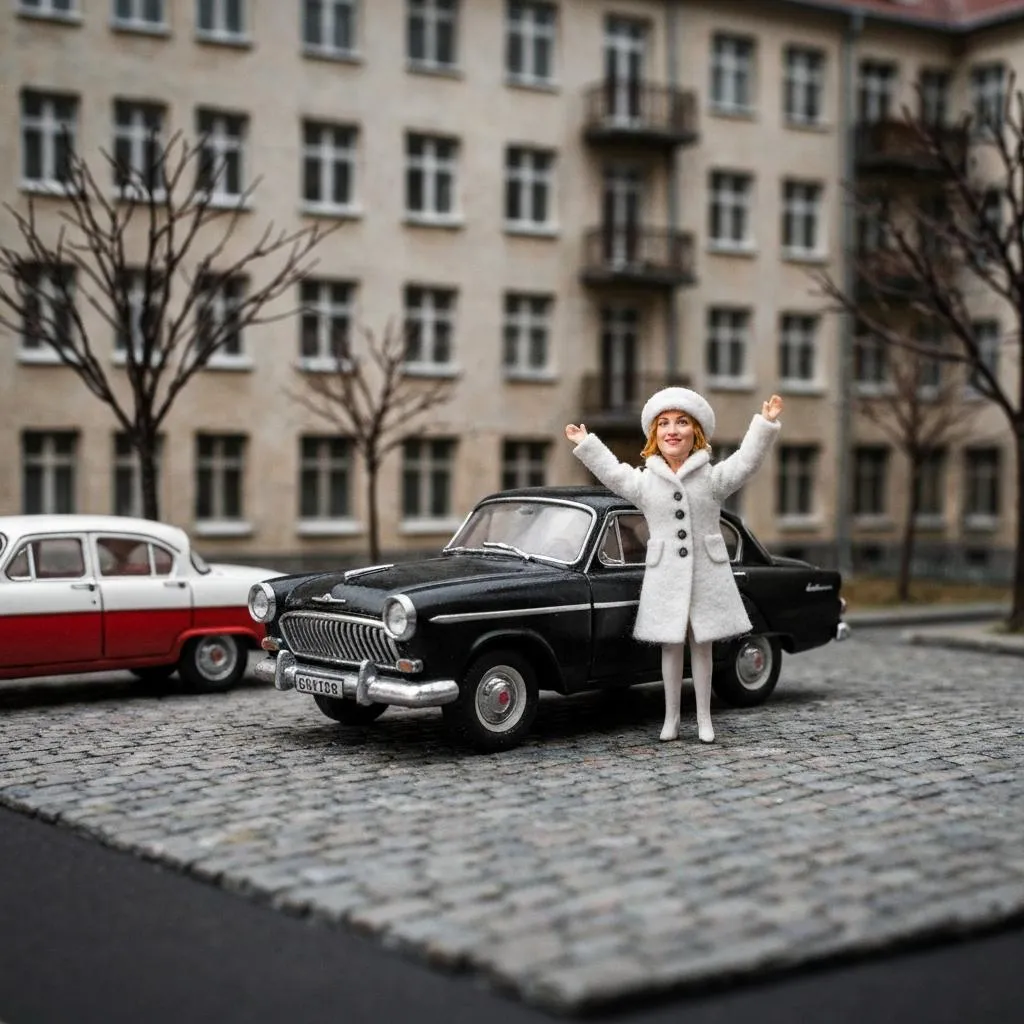
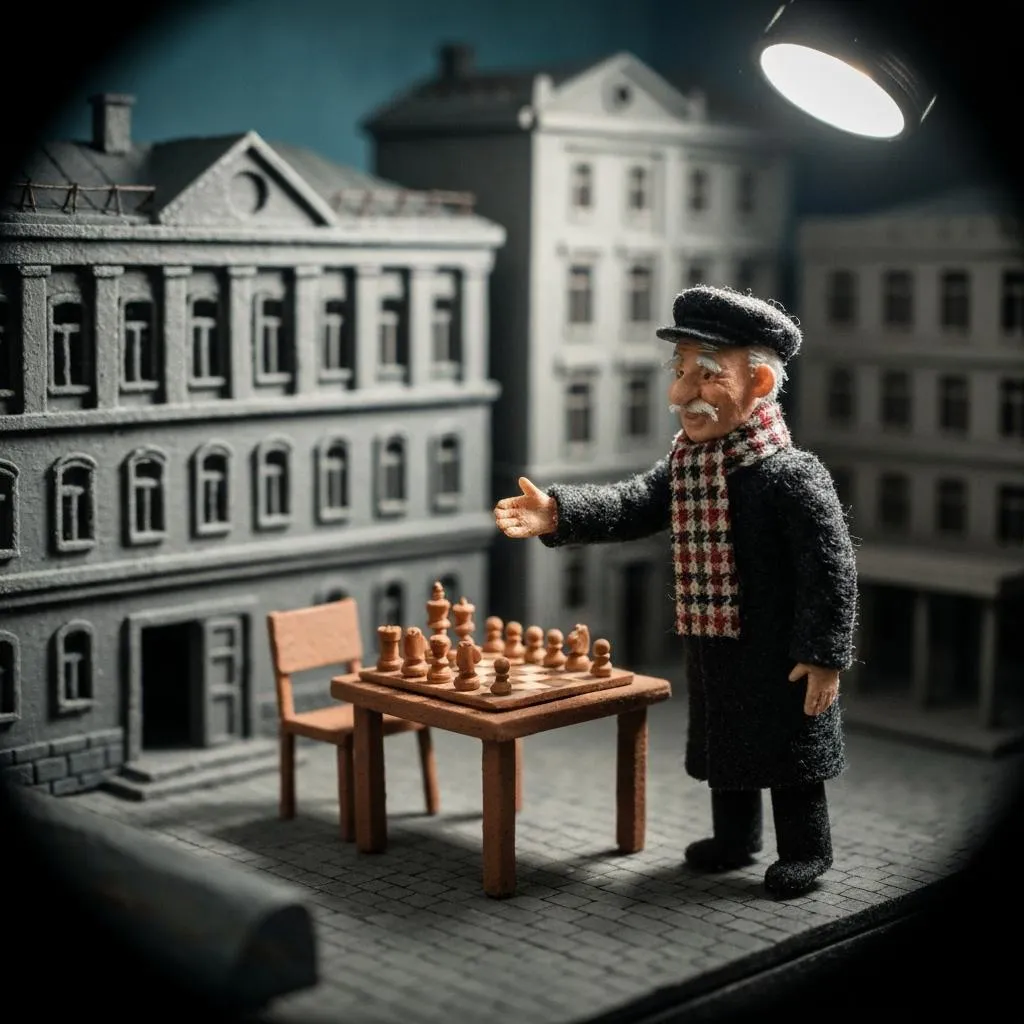
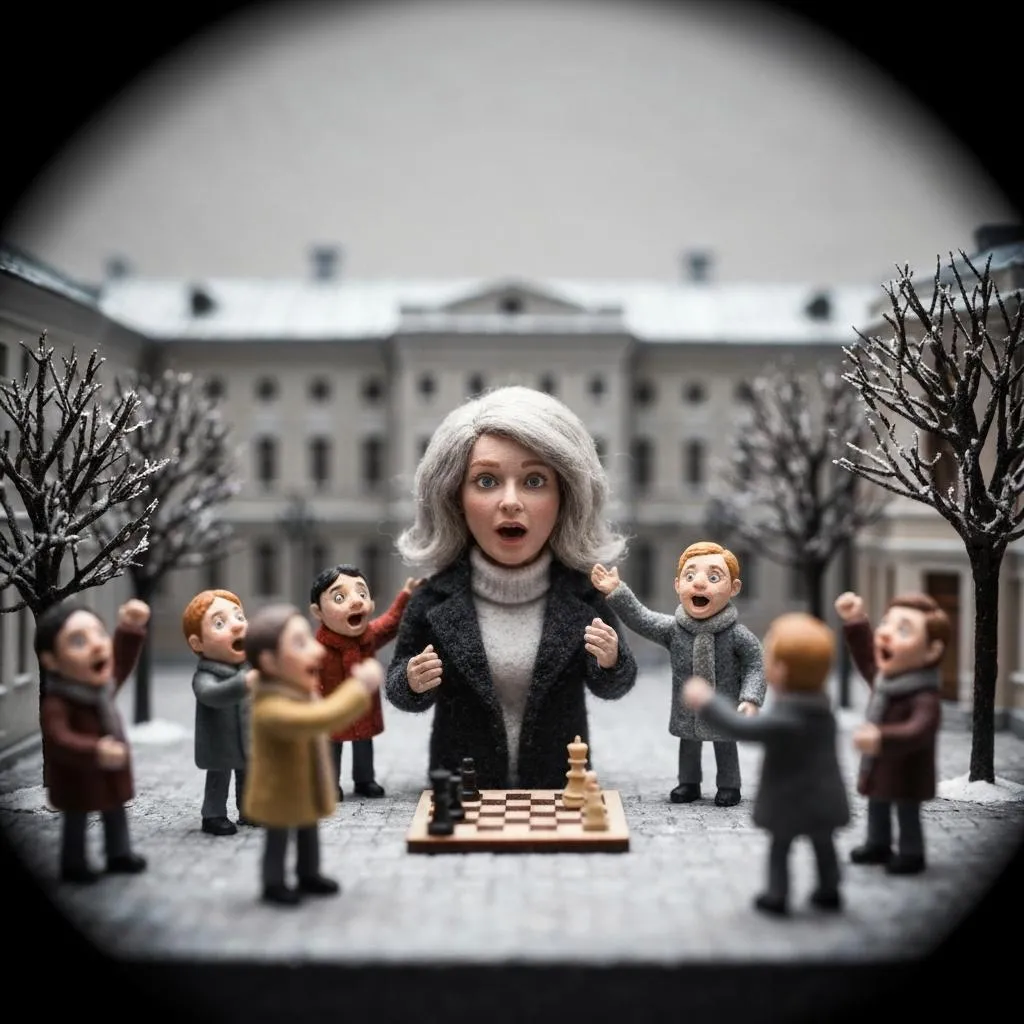
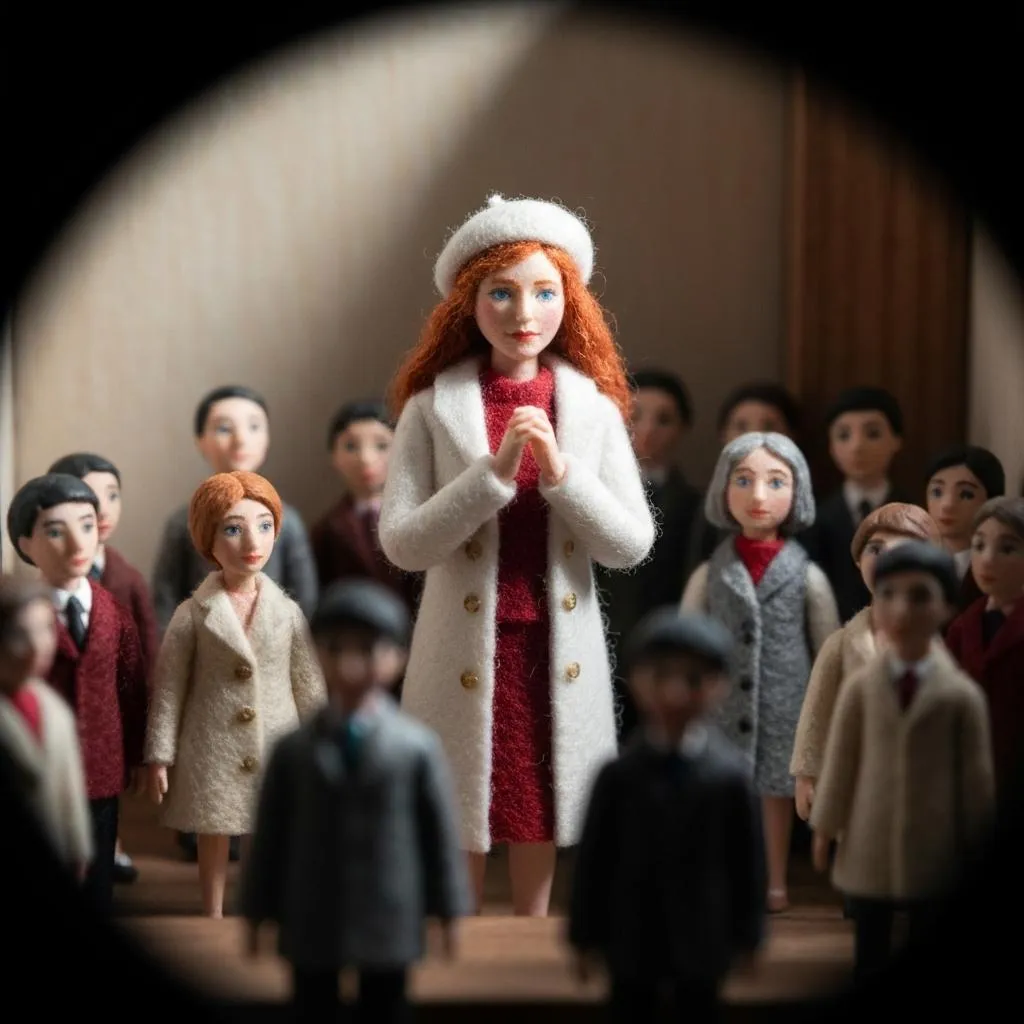

In [84]:
scene_view.where(
    scene_view.title.contains('Queen')
).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

Now that these are stored persistently, you can see the images have a spot in your local file cache. Read more about external files in our docs: https://docs.pixeltable.com/platform/external-files

scene_image,scene_image_localpath
,/Users/alison-pxt/.pixeltable/media/02b03fa115b94f17871203d6748e30ac/d3/d376/02b03fa115b94f17871203d6748e30ac_17_9_d3761448776e48b7b8752413dc36f482.jpeg

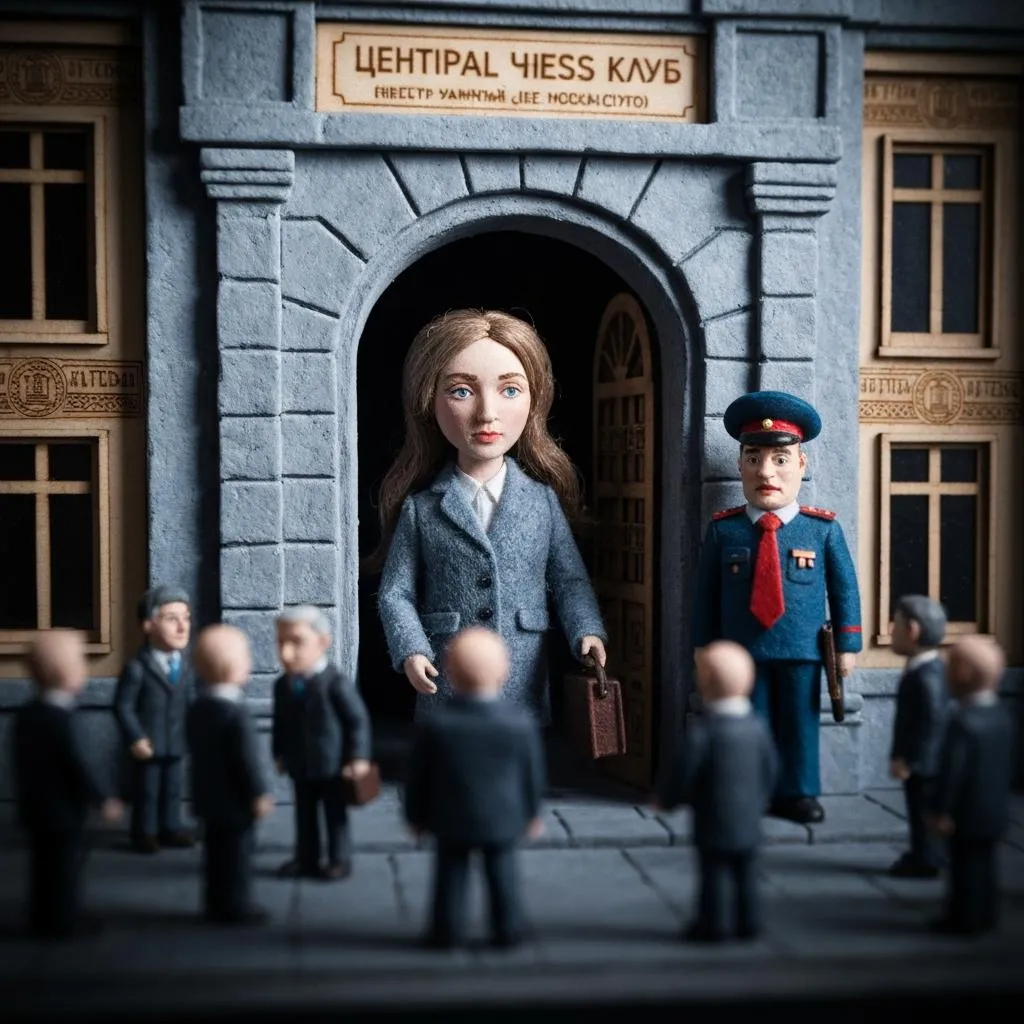

In [85]:
scene_view.select(
    scene_view.scene_image,
    scene_view.scene_image.localpath
).limit(1).collect()

If any rows encountered errors during processing (rate limits, API issues, etc.), you can recompute just those rows where Pixeltable logged errors:

In [27]:
# Recompute any rows that had errors
scene_view.recompute_columns(
    scene_view.scene_image,
    errors_only=True
)

No rows affected.

## 06 - (Optional) Video Generation

This section demonstrates two ways to use Gemini for video generation using queries to run each model on just two scenes total (one from each video in our base table). Video generation is slower and more expensive than text or image generation. At the time of this workshop, the code we provide here should keep you safely in the free tier of four videos per day.

- **Image Input: Generate Videos from Image Only** - Slower, simpler approach (`veo-3.1-generate-preview`)
- **Multimodal Inputs: Generate Videos from Prompt + Image** - Slower, more tokens, production quality (`veo-3.1-generate-preview`)

### Image Input: Animate an Image (No Text Prompt)

This simpler approach animates the frame without a text prompt - just the image itself.

In [86]:
scene_animation = scene_view.where(scene_view.pos == 7).select(
    scene_view.beginning_frame,
    scene_view.scene_image,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.scene_image.resize((640, 640)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

beginning_frame,scene_image,animated_video
,,
,,

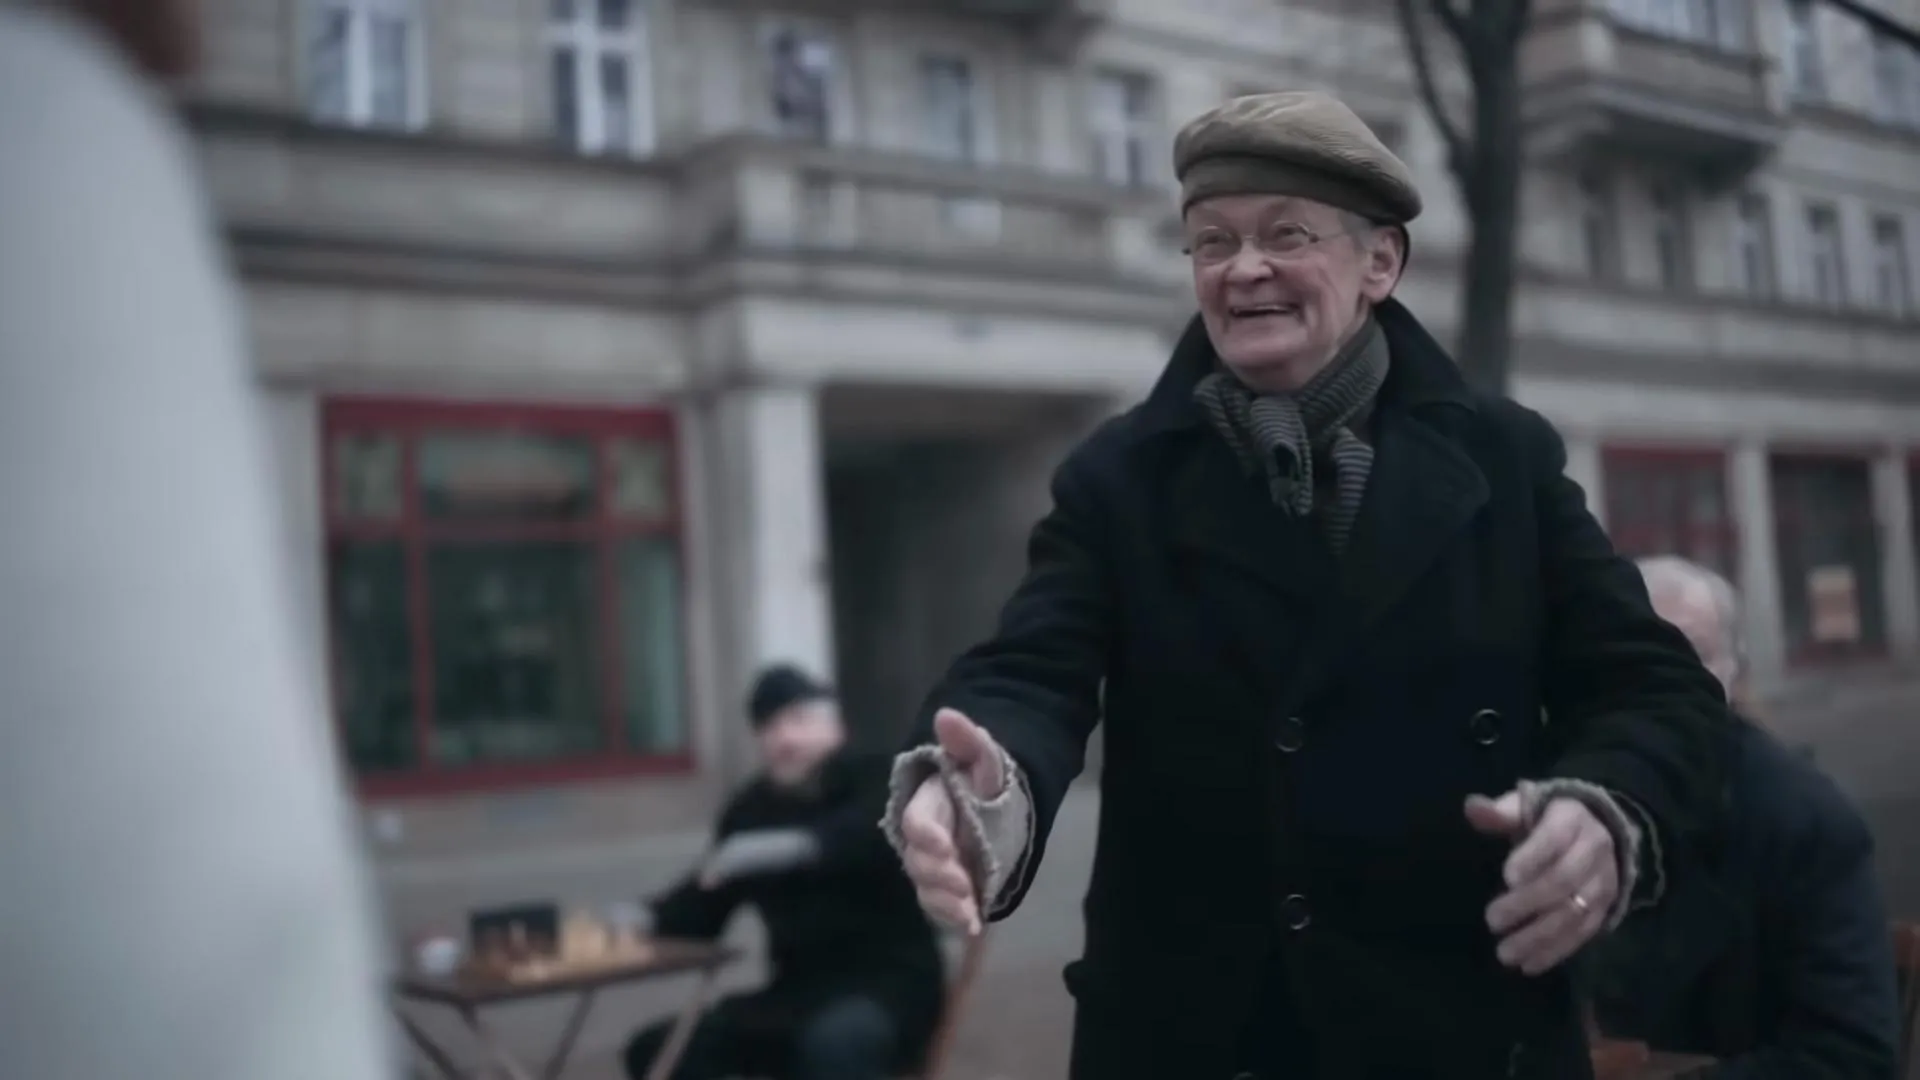
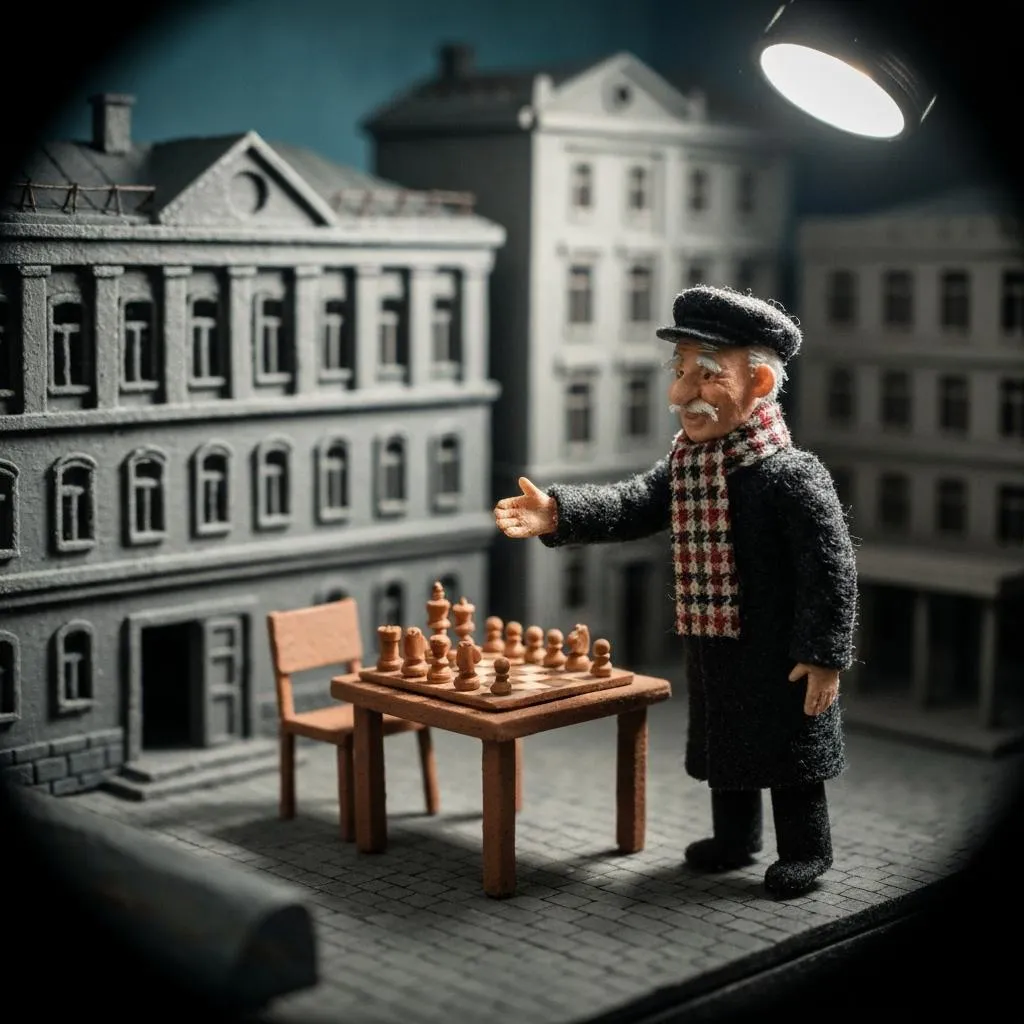
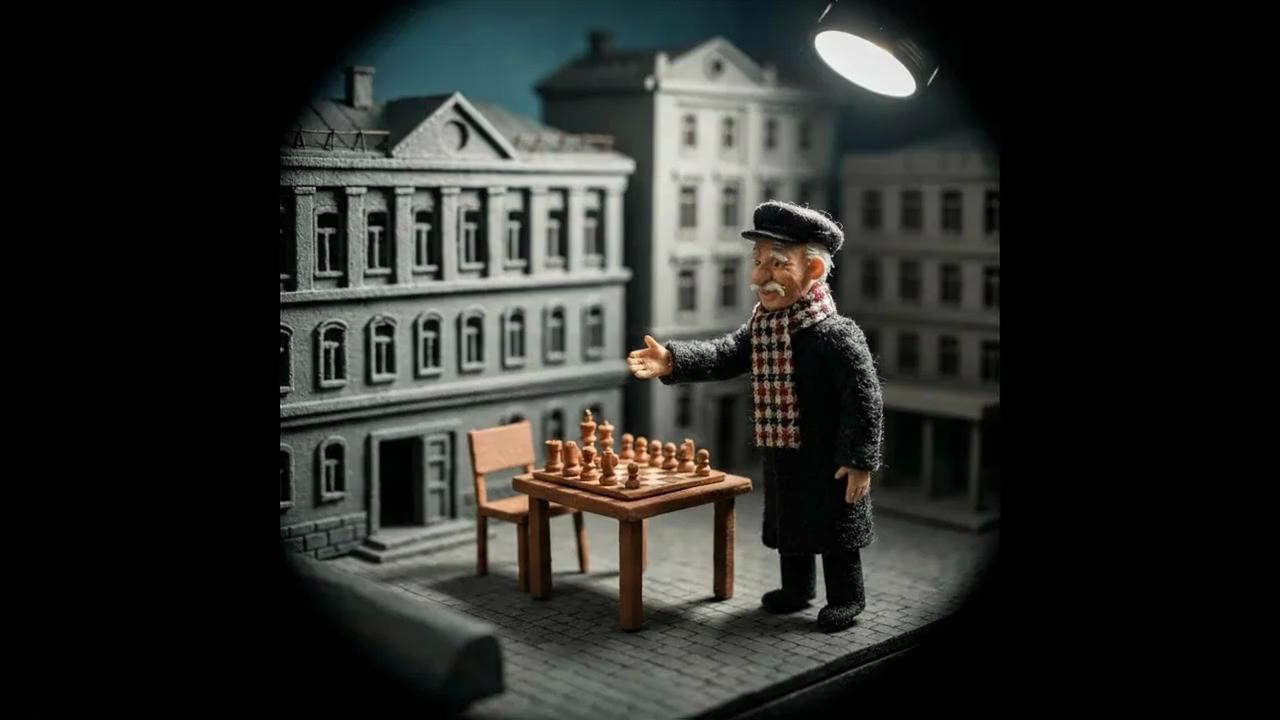
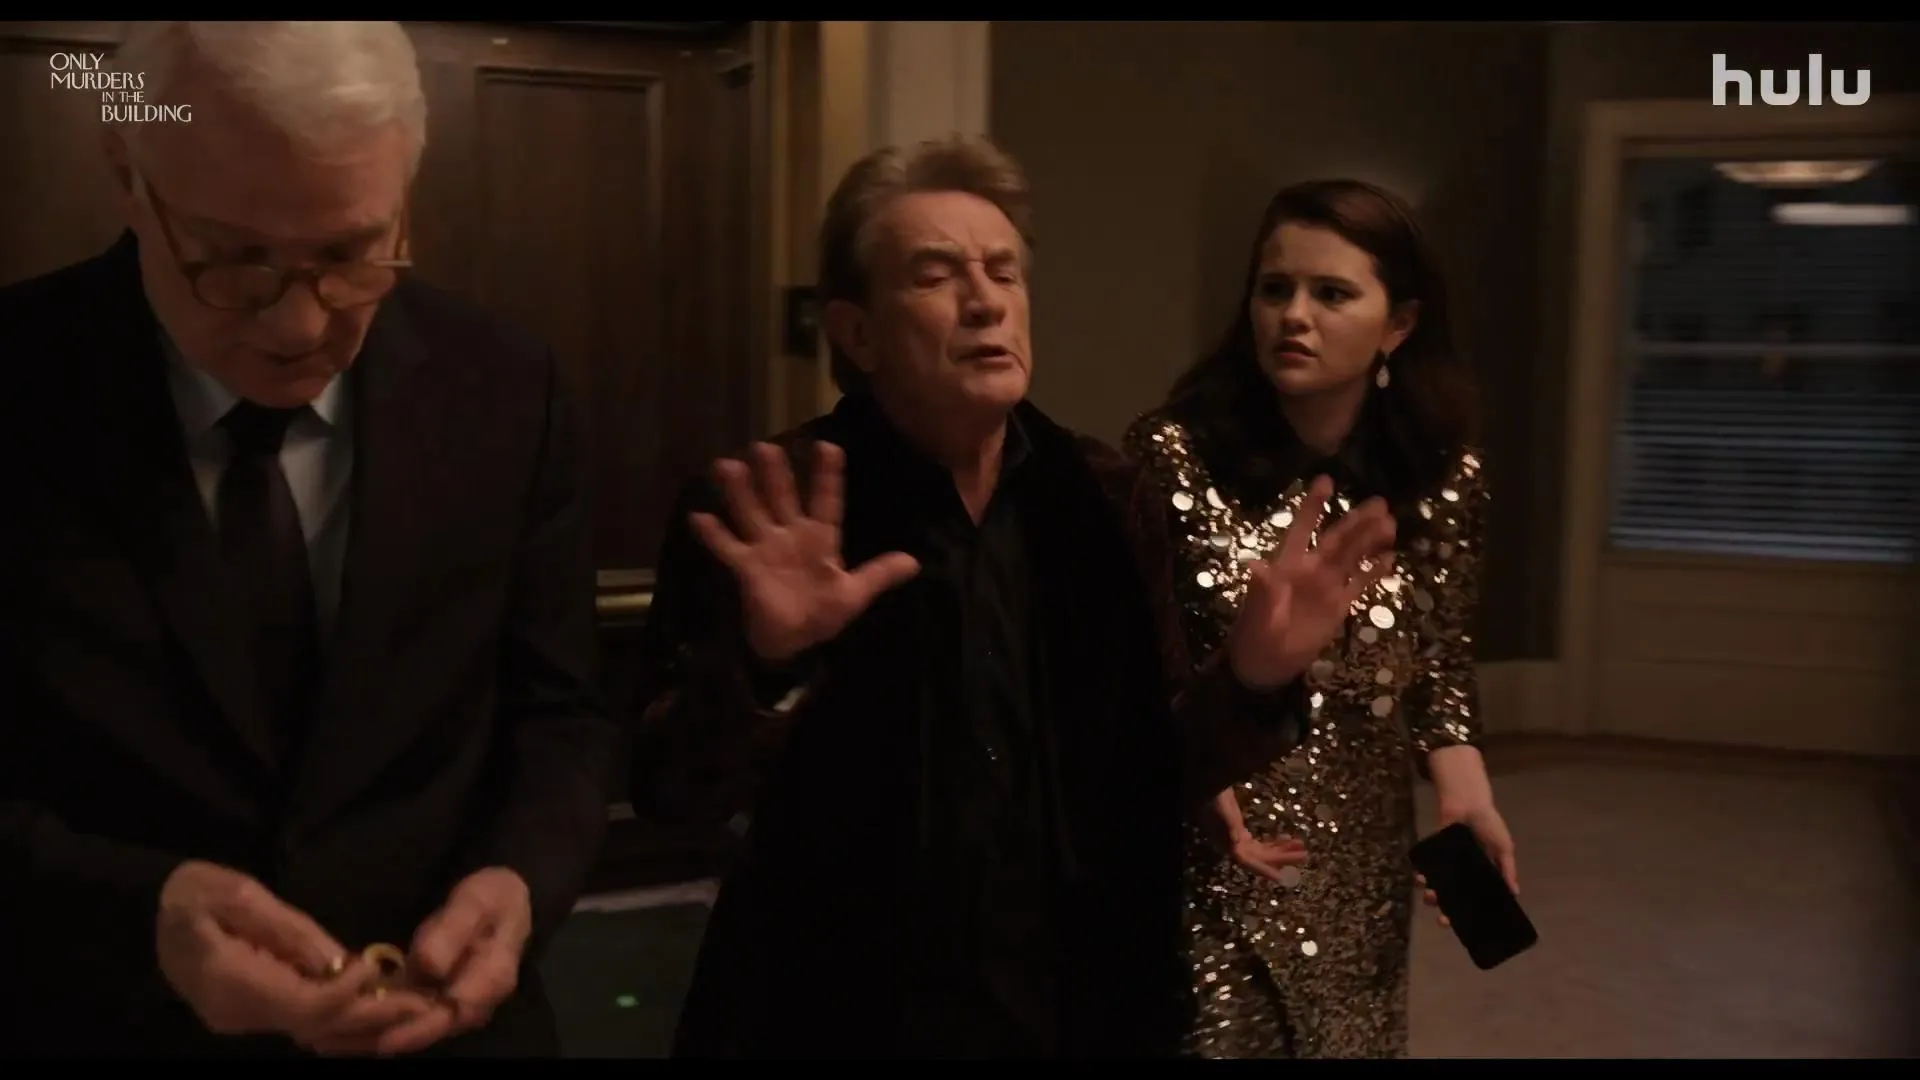
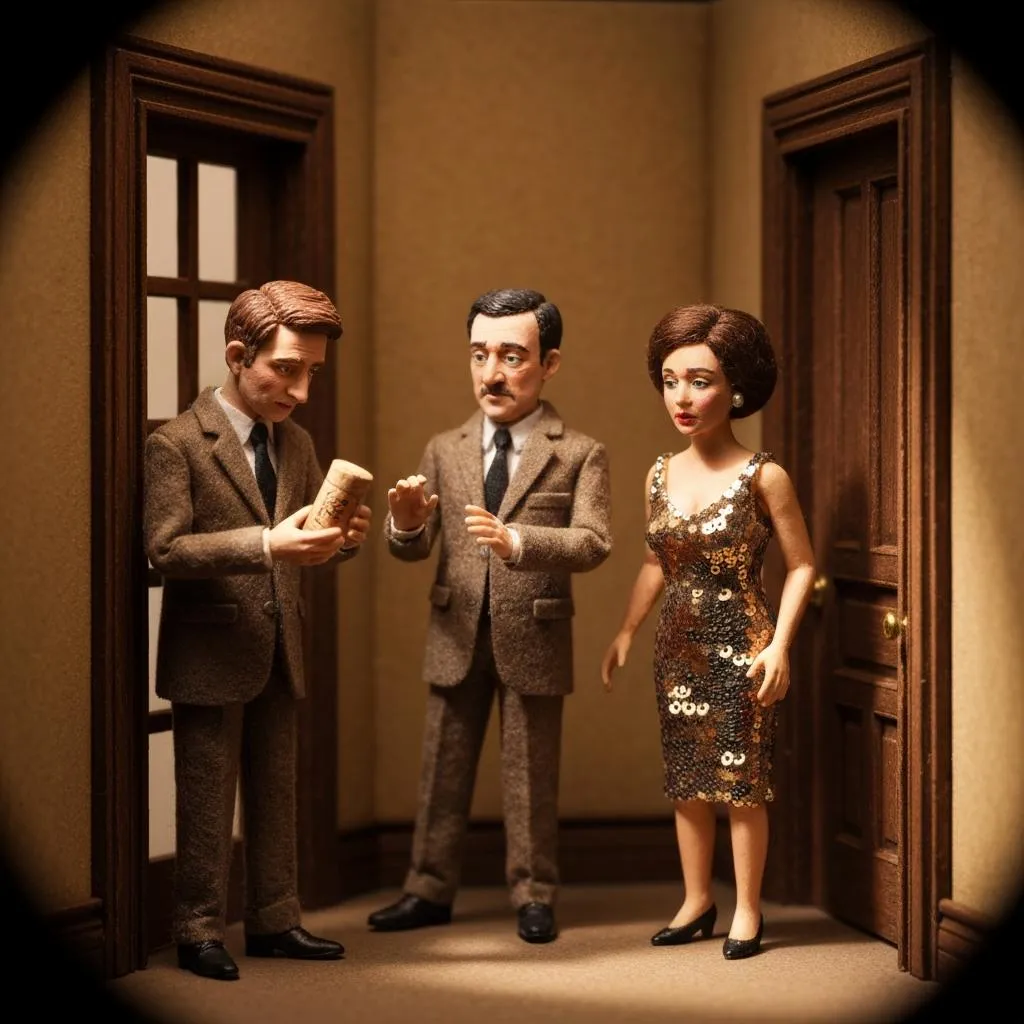
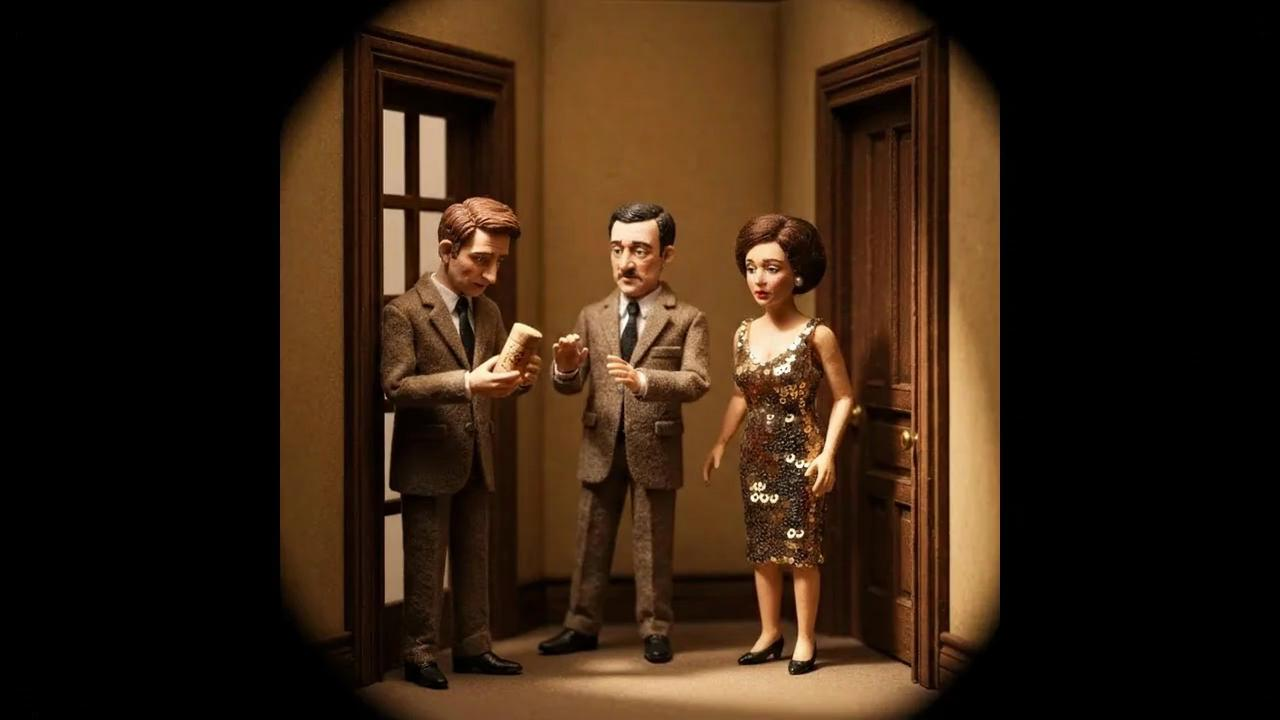

In [87]:
scene_animation

### Multimodal Inputs: Generate a Video from Prompt + Image

Test video generation using both the `scene_prompt` and the `scene_image`. Save the results of this query in memory as `scene_trailer`.

In [88]:
scene_trailer = scene_view.where(scene_view.pos == 7).select(
    scene_view.scene_image,
    scene_view.scene_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.scene_prompt,
        image=scene_view.scene_image.resize((640, 640)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

Error: In row 0 the expression generate_videos(prompt=scene_prompt, image=scene_image.resize([640, 640]), model='veo-3.1-generate-preview', config={'duration_seconds': 4}) encountered exception ClientError:
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. ', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}]}}
with 'scene_prompt' = 'An intricate miniature diorama of the "Only Murders in the Building" trio Charles, Oliver, and Mabel standing in a hallway of their Upper West Side apartment building; Charles holding a wine cork looking down at it, Oliver with his hands up in a halting manner, Mabel dressed in a sequin dress looking concerned. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot. Dramatic miniature lighting with a spotlight on Charles and the cork, casting long shadows. Tiny handcrafted details include felt suits, clay faces with expressive features, and a meticulously recreated wooden doorframe. The walls are a tan/beige color. Color palette is muted browns, tans, and golds with a touch of sparkle from Mabel's dress. Mood is suspenseful and slightly humorous.
', 'scene_image.resize([640, 640])' = <PIL.Image.Image image mode=RGB size=640x640 at 0x3E4210ED0>, ''veo-3.1-generate-preview'' = 'veo-3.1-generate-preview', '{'duration_seconds': 4}' = {'duration_seconds': 4}
Stack:
  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/errors.py", line 225, in raise_error_async
    raise ClientError(status_code, response_json, response)

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/errors.py", line 203, in raise_for_async_response
    await cls.raise_error_async(status_code, response_json, response)

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/_api_client.py", line 1310, in _async_request_once
    await errors.APIError.raise_for_async_response(response)

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/asyncio/__init__.py", line 114, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/alison-pxt/miniconda3/lib/python3.13/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception

  File "/Users/alison-pxt/miniconda3/lib/python3.13/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ~~~~~~~~~~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/__init__.py", line 187, in reraise
    raise self.last_attempt.result()
          ~~~~~~~~~~~~~~~~~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/__init__.py", line 420, in exc_check
    raise retry_exc.reraise()
          ~~~~~~~~~~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/_utils.py", line 99, in inner
    return call(*args, **kwargs)

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/asyncio/__init__.py", line 153, in iter
    result = await action(retry_state)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/tenacity/asyncio/__init__.py", line 111, in __call__
    do = await self.iter(retry_state=retry_state)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/_api_client.py", line 1365, in _async_request
    return await self._async_retry(  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        self._async_request_once, http_request, stream
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/_api_client.py", line 1432, in async_request
    result = await self._async_request(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
        http_request=http_request, http_options=http_options, stream=False
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/models.py", line 6944, in _generate_videos
    response = await self._api_client.async_request(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        'post', path, request_dict, http_options
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/google/genai/models.py", line 7628, in generate_videos
    return await self._generate_videos(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<6 lines>...
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/pixeltable/functions/gemini.py", line 271, in generate_videos
    operation = await _genai_client().aio.models.generate_videos(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        model=model, prompt=prompt, image=image_, config=config_
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^


scene_image,scene_prompt,trailer_video
,"An intricate miniature diorama of a hallway scene from ""Only Murders in the Building"", featuring three handcrafted miniature figures: Charles in a dark suit meticulously holding a wine cork, Oliver gesturing with both hands raised, and Mabel in a sequined dress looking bewildered. The diorama includes a miniature wooden door behind them. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, eye-level perspective, dramatic miniature lighting emphasizing the characters' faces and the hallway's details with soft, warm spotlights mimicking interior lighting. Tiny handcrafted details: individual sequins on Mabel’s dress, realistic folds in Charles and Oliver’s felt clothing, and wood grain in the door. Materials: felt, clay, wood. The color palette is predominantly beige and brown, with a glint of gold from Mabel's dress. The mood is both humorous and slightly suspenseful, capturing the essence of the show.",
,"An intricate miniature diorama of an outdoor chess scene in Moscow during the Cold War, inspired by ""The Queen's Gambit."" An elderly man in a black coat and tweed cap, sculpted from clay, reaches out his hand in greeting, a warm smile on his tiny face. Behind him, two men are seated at a miniature chess table crafted from wood, pieces meticulously arranged. Background shows a building with detailed window frames and architectural details. Photographed with a tilt-shift lens creating selectiv ...... nd building softened. Dramatic miniature lighting, a single warm spotlight highlighting the man's face, casting long, soft shadows. Tiny handcrafted details include felt scarves and minuscule buttons on the coats, cobblestone street made of painted clay. Color palette: muted grays, browns, and hints of red in the storefront details, creating a melancholic yet charming atmosphere. Mood: a heartwarming moment of camaraderie amid a stark and cold environment, cinematic and charmingly handmade.",

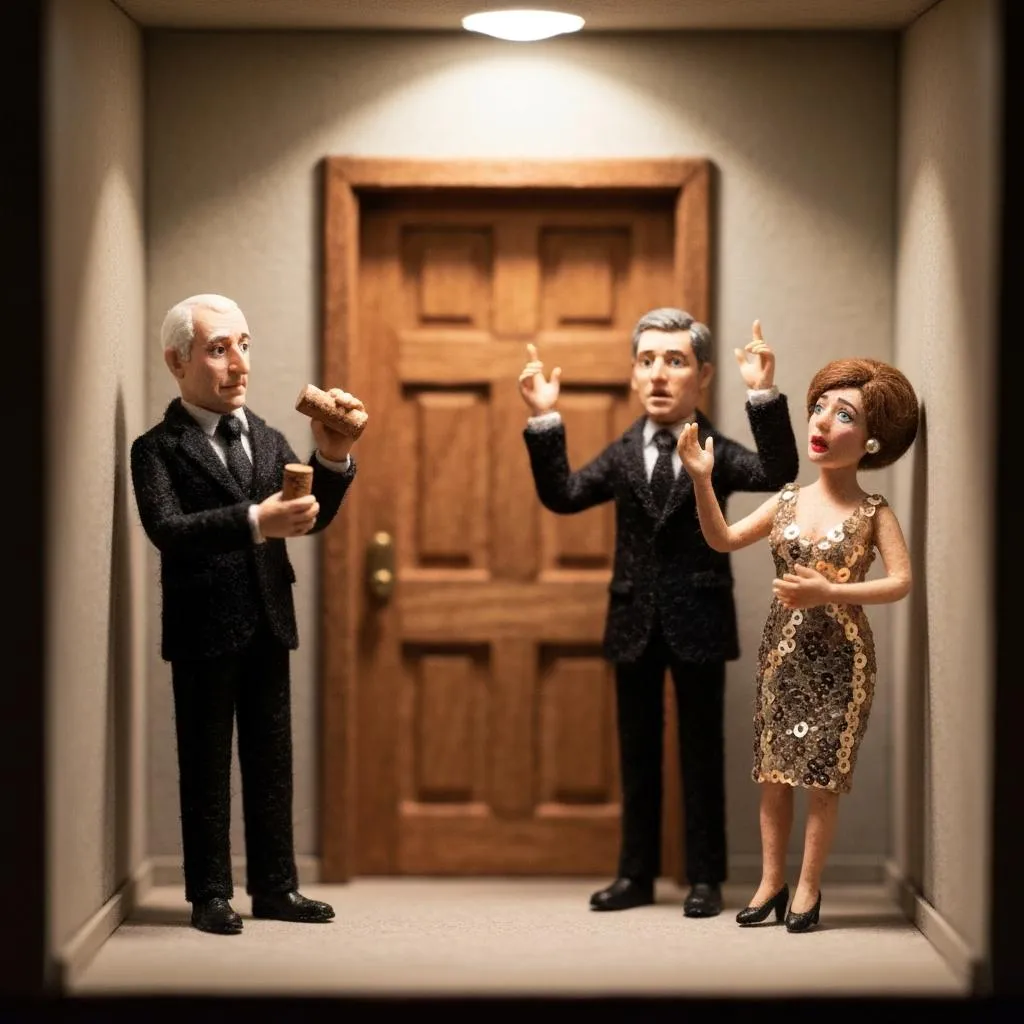
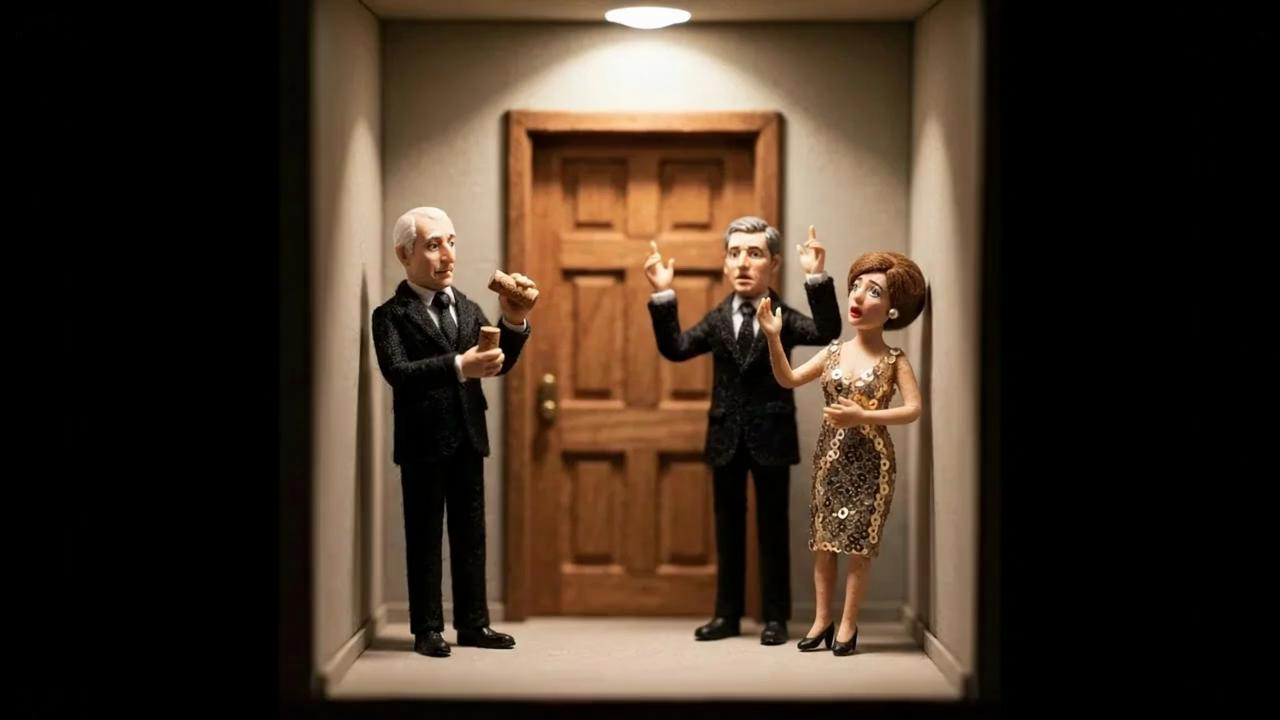
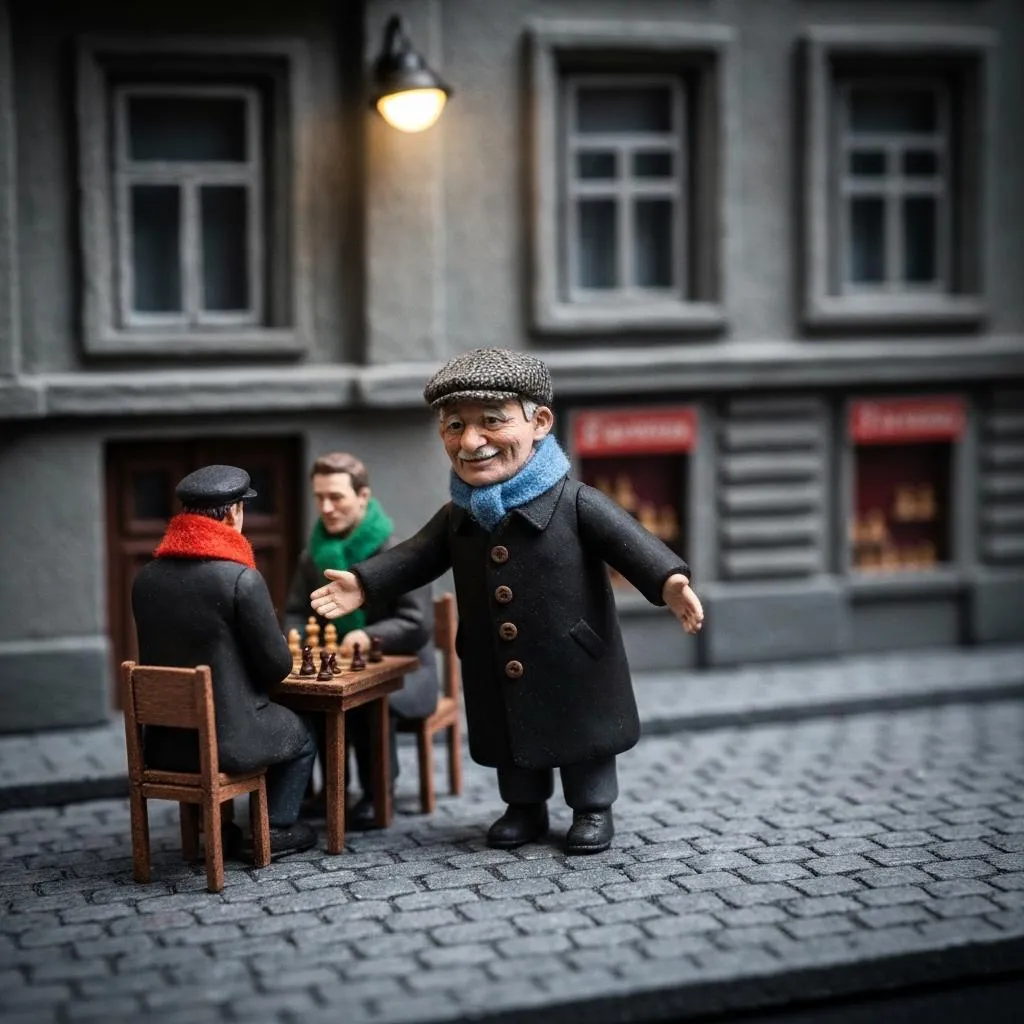
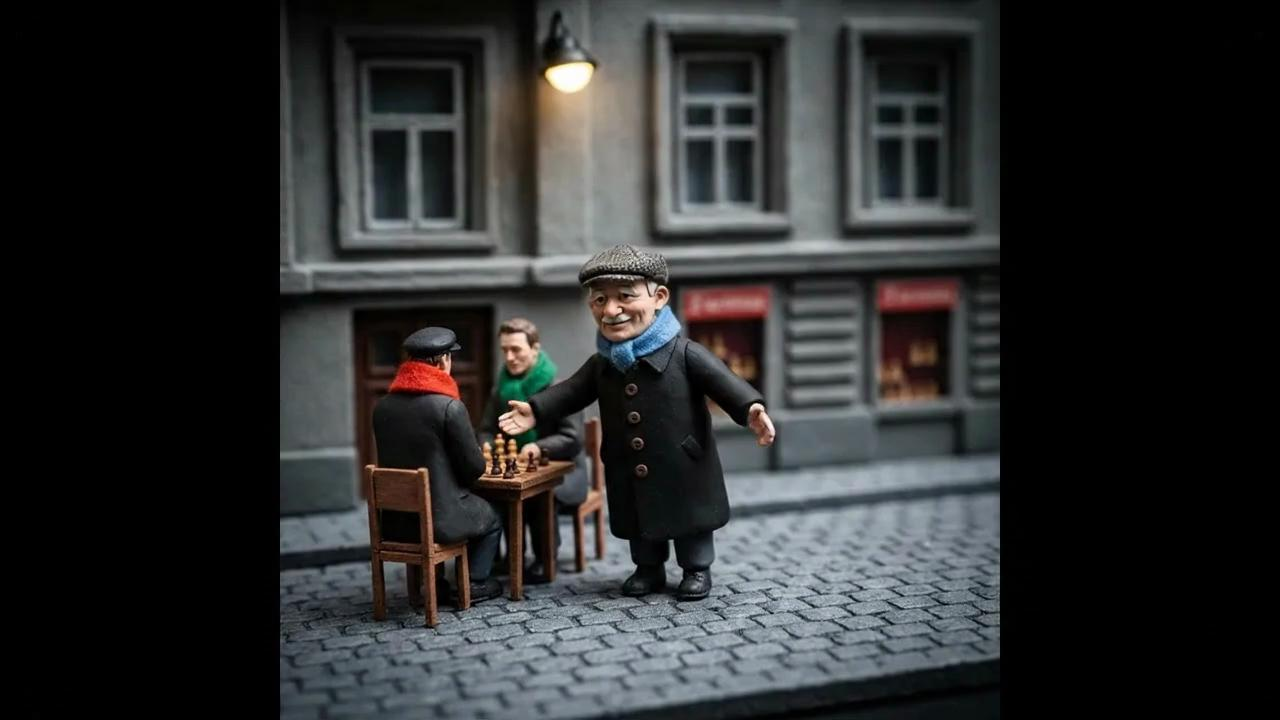

In [37]:
scene_trailer

## Wrap-Up

You built a content generation pipeline using Pixeltable:

```
┌────────────────────────────────────────────────────────────────────────────┐
│  SCENE             PROMPT             GENERATE            ANIMATE          │
│                                                                            │
│  ┌────────┐       ┌────────┐        ┌──────────┐       ┌──────────┐        │
│  │ Frame  │──────▶│ Gemini │───────▶│  Imagen  │──────▶│   Veo    │        │
│  │ + Text │       │        │        │          │       │          │        │
│  └────────┘       └────────┘        └──────────┘       └──────────┘        │
│      │                │                   │                  │             │
│  Frame +          Scene              Diorama            Animated           │
│  metadata         prompt             image              video              │
│                                                                            │
└────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added content generation to your video pipeline. 

- Act 1 gave you visual search.  
- Act 2 gave you audio search. 
- Act 3 gives you generative AI—create new images and videos from any scene.

**Each step is declarative:**

**Scene:** Frame and metadata from scene_view (built in Act 2)  
**Prompt:** Gemini generates scene descriptions from multimodal inputs  
**Generate:** Imagen creates images from prompts  
**Animate:** Veo turns images into video clips